# Youtube Trending - Data Exploration Project

### Maria Naklicka    
127313 ISWD

### Norbert Schlaffke 
127201 ISWD

## Installing libraries

In [0]:
!pip install -q --upgrade tables # To solve error with pd.read_hdf
!pip install -q cvlib
!pip install -q imbalanced-learn
!pip install -q --upgrade shap
!pip install -q stop-words
!pip install -q colorthief
!pip install -q langdetect

## Imports

In [14]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # To plot dates on histograms' axis

import calendar
import datetime
import time
import itertools
from datetime import datetime, date, timedelta # To convert datetime.date to seconds
from colorthief import ColorThief

from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from PIL import Image, ImageStat

import nltk
nltk.download('punkt')

import stop_words
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

import urllib
import csv
from urllib.error import HTTPError

import os
from os import path, listdir, cpu_count
import copy
from pathlib import Path
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox
import multiprocessing as mp
from skimage import io
import sys

# For progress bar
from IPython.display import HTML, display
import time

from google.colab import drive # Google Drive connection
from joblib import Memory # Memory cache

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics

from scipy.stats import chi2_contingency

from copy import deepcopy

# imblearn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from sklearn.externals.joblib import Memory
memory = Memory(location='./joblib', verbose=0)

In [0]:
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')

## Google-Drive

In [17]:
print('Connecting google drive...')
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/"
data_path = os.path.join(drive_path , 'datasets/youtube_data')
image_path = os.path.join(data_path, 'images')

print('Setting cache...')
memory = Memory(cachedir=drive_path + '/cache', verbose=0)

Connecting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setting cache...


# EDA

### Loading data

In [0]:
DATA_US = 'US_videos_5p.csv'
DATA_GB = 'GB_videos_5p.csv'

data_gb = pd.read_csv(path.join(data_path, DATA_US), sep=";")
data_us = pd.read_csv(path.join(data_path, DATA_GB), sep=";")
data = pd.concat([data_gb, data_us])
del data_gb
del data_us
data.reset_index(drop=True, inplace=True)
data.shape

(79816, 16)

We have **79816** records of **16** attributes

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79816 entries, 0 to 79815
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                79816 non-null  object 
 1   trending_date           79816 non-null  object 
 2   title                   79816 non-null  object 
 3   channel_title           79816 non-null  object 
 4   category_id             3930 non-null   float64
 5   publish_time            79816 non-null  object 
 6   tags                    79816 non-null  object 
 7   views                   79816 non-null  int64  
 8   likes                   79816 non-null  int64  
 9   dislikes                79816 non-null  int64  
 10  comment_count           79816 non-null  int64  
 11  thumbnail_link          79816 non-null  object 
 12  comments_disabled       79816 non-null  bool   
 13  ratings_disabled        79816 non-null  bool   
 14  video_error_or_removed  79816 non-null

Examples:

In [0]:
data.head()

video_id  ...                                       description 
0  2kyS6SvSYSE  ...  SHANTELL'S CHANNEL - https://www.youtube.com/s...
1  1ZAPwfrtAFY  ...  One year after the presidential election, John...
2  5qpjK5DgCt4  ...  WATCH MY PREVIOUS VIDEO ▶  SUBSCRIBE ► https:/...
3  puqaWrEC7tY  ...  Today we find out if Link is a Nickelback amat...
4  d380meD0W0M  ...  I know it's been a while since we did this sho...

[5 rows x 16 columns]

### Attribute analysis

#### Missing values

In [0]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df[['percent_missing']]

percent_missing
video_id                       0.000000
trending_date                  0.000000
title                          0.000000
channel_title                  0.000000
category_id                   95.076175
publish_time                   0.000000
tags                           0.000000
views                          0.000000
likes                          0.000000
dislikes                       0.000000
comment_count                  0.000000
thumbnail_link                 0.000000
comments_disabled              0.000000
ratings_disabled               0.000000
video_error_or_removed         0.000000
description                    1.480906

We can see missing values in `category_id` and `description`

#### video_id

In [0]:
def plot_dist_log(data, title=''):
    ax = sns.distplot(data);
    ax.set_yscale('log')
    ax.set_title(title)

In [0]:
data.video_id.value_counts()

#NAZWA?        725
8h--kFui1JA     65
vjSohj-Iclc     62
VYOjWnS4cMY     61
l884wKofd54     60
              ... 
PmH948yZwhE      1
bvf5DlhvJJE      1
676hNIhKO2M      1
YDyqnYhxTTw      1
y2l7bhf5fJo      1
Name: video_id, Length: 8510, dtype: int64

Among the records **725** appears `#NAZWA?`. It's an error in the data.  
After taking a closer look, we can see that we can retrieve erroneous `video_id`'s from `thumbnail_link` attribute.

In [0]:
def get_id(v_id, link):
    if v_id == "#NAZWA?":
        tokens = link.split('/')
        return tokens[-2]
    else: return v_id
data['video_id'] = data.apply(lambda row : get_id(row.video_id, 
                                                  row.thumbnail_link), axis = 1) 
data.to_csv(os.path.join(data_path,"videos_5p.csv"), sep=";", index=False) 
data.video_id.value_counts()

8h--kFui1JA    65
vjSohj-Iclc    62
VYOjWnS4cMY    61
l884wKofd54    60
5GHXEGz3PJg    59
               ..
A34O0pCAQ60     1
9L4-DV1nVek     1
tJLtDRrimAs     1
77e7n60Zs9E     1
FrK2j4cPxSc     1
Name: video_id, Length: 8606, dtype: int64

We have only **8606** unique ids. It mean's that the majority of the videos appeared on the list more than one time.

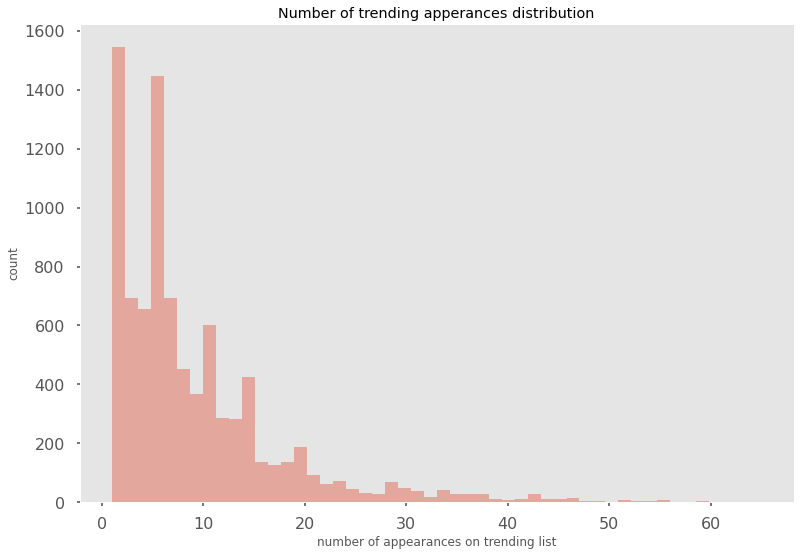

In [0]:
sns.distplot(data.title.value_counts(), kde=False);
plt.title('Number of trending apperances distribution')
plt.xlabel('number of appearances on trending list')
plt.ylabel('count');

As we can see on the list, a lot of the videos appeared on the trending list more than one time. We can see a power law distribution.

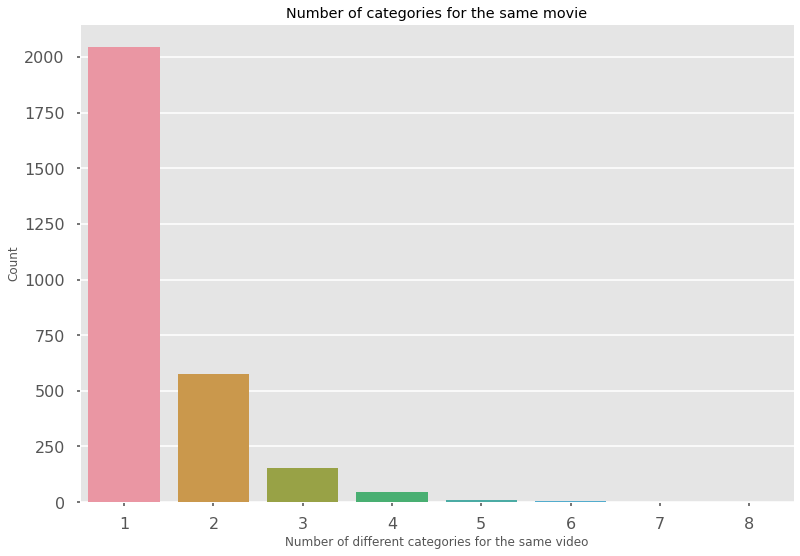

In [0]:
gb = data.loc[
              data.category_id.notna(),['video_id', 'category_id']
              ].groupby('video_id')
sns.countplot(gb.size());
plt.xlabel('Number of different categories for the same video')
plt.ylabel('Count')
plt.title('Number of categories for the same movie');

As we can see, sometimes the same video was lited many times under different categories. We will save the one-category movies' categories - we consider them non-ambigous. They may come handy later.

In [0]:
id_cat = gb.filter(lambda x: len(x) == 1).drop_duplicates().reset_index(drop=True)
id_cat.to_csv(path.join(data_path, 'trending_cat_map_final.csv'), index=False)

As we can see on the list, a lot of the videos appeared on the trending list more than one time. We can see a power law distribution.  

To perform further data exploration analysis, we will add a new attribute denotoing how many times the video has been on the _trending list_ and remove the duplicate entries, leaving only the first (earliest) occurence.

In [0]:
trending_no = pd.DataFrame(data.groupby('video_id').size(), 
                      columns=['trending_no'])
trending_no.reset_index(level=0, inplace=True)
trending_no

video_id  trending_no
0     --uXQQ0h-yQ            9
1     -0CMnp02rNY            6
2     -0NYY8cqdiQ            1
3     -1Hm41N0dUs            3
4     -1yT-K3c6YI            4
...           ...          ...
8601  zxUwbflE1SY            5
8602  zxjv0lo8bU8           17
8603  zxwfDlhJIpw           59
8604  zy0b9e40tK8            1
8605  zzQsGL_F9_c            2

[8606 rows x 2 columns]

In [0]:
data = data.merge(trending_no, on='video_id')

data.trending_date = pd.to_datetime(data.trending_date, format="%y.%d.%m")
data.sort_values(['trending_date'], inplace=True)
data.drop_duplicates(['video_id'], inplace=True, keep='first')

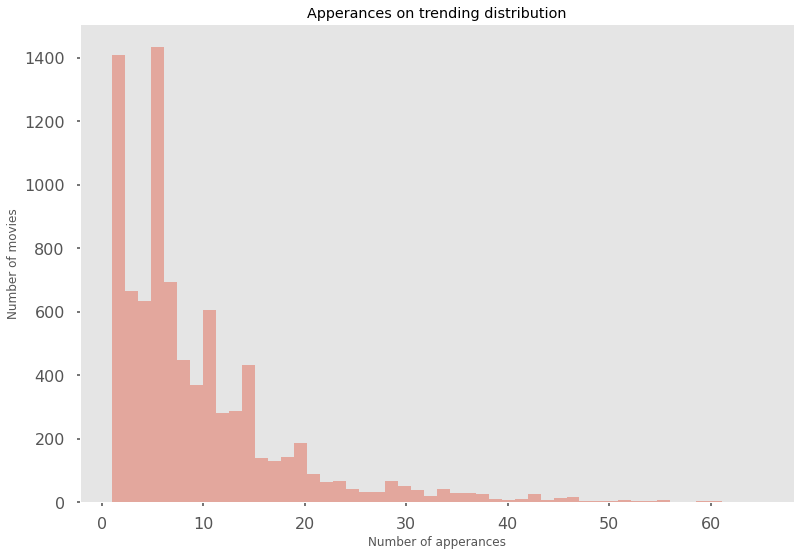

In [0]:
sns.distplot(data.trending_no, kde=False)
plt.xlabel('Number of apperances')
plt.ylabel('Number of movies')
plt.title('Apperances on trending distribution');

### trending_date

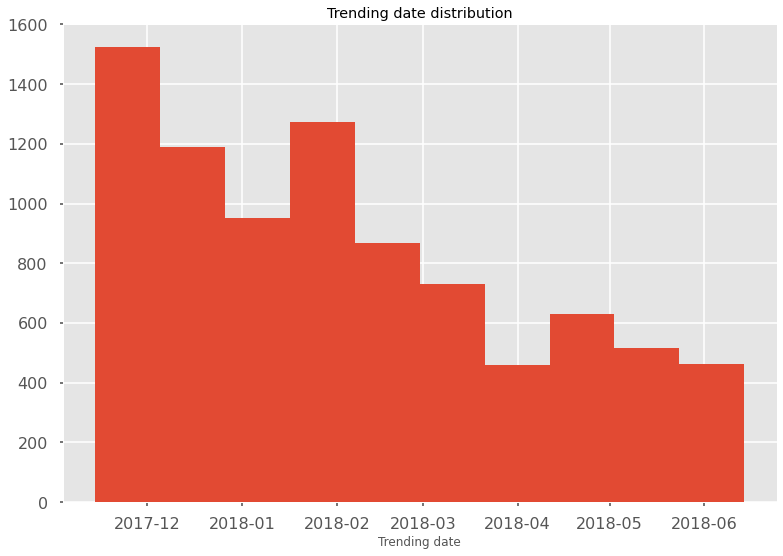

In [0]:
data.trending_date.hist()
plt.xlabel('Trending date')
plt.title('Trending date distribution');

Videos were _trending_ from November 2017 to June 2018. The interesting thing is their distribution by trending date. It is noticeably skew. We don't have access to information about the data aquisition process, so we don't know the reason for such a shape.

### Channel title

In [0]:
data.channel_title.nunique()

3077

We have around **3000** unique channels.

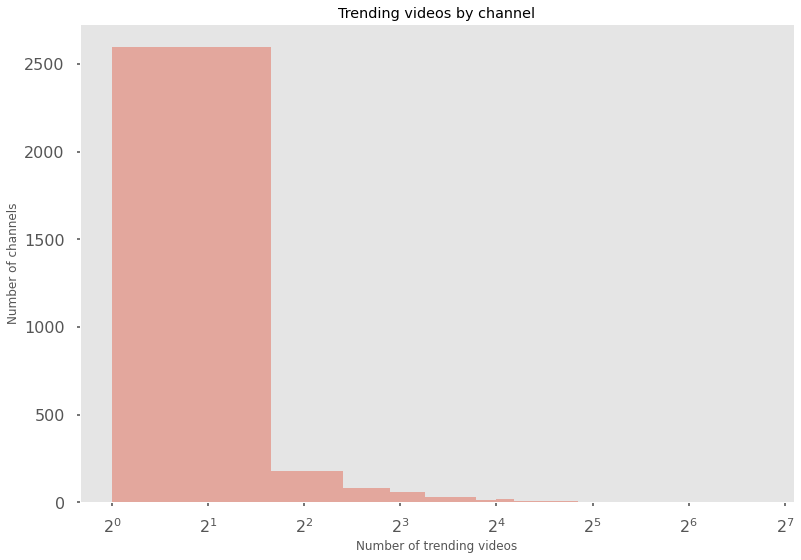

In [0]:
ax = sns.distplot(data.channel_title.value_counts(), kde=False);
ax.set_title('Trending videos by channel');
ax.set_xlabel('Number of trending videos');
ax.set_ylabel('Number of channels');
ax.set_xscale('log', basex=2)

We have some globally-known popular channels, which tend to have a lot of trending video. We can see a power law distribution here.

In [0]:
popular_channels = data.groupby('channel_title')\
                       .filter(lambda x: len(x) > 25)['channel_title'].unique()
print(len(popular_channels))

34


We have **34** channels having more than **25** trending videos.  
A new attribute will be made using this knowledge: `channel_attr`

In [0]:
data['channel_atr'] = data.channel_title.apply(
    lambda x: x if x in popular_channels else 'other')
data.channel_atr = pd.Categorical(data.channel_atr)

In [0]:
ax = sns.countplot(y='channel_title', 
                   data=data, 
                   order=data.channel_title.value_counts().iloc[:20].index, 
                   orient="h");
ax.set_title('Trending distribution by 20 most popular channels');
ax.set_xlabel('Number of Videos');

### category_id

In [0]:
data.category_id.value_counts(dropna=False)
result = data.category_id.isnull().sum()*100/len(data)
print('%.2f%%' % result)

95.36%


Category is unknown for **95%** of the cases.

### publish_time

In [0]:
data.publish_time.head()
data.publish_time = pd.to_datetime(data.publish_time)

#### year

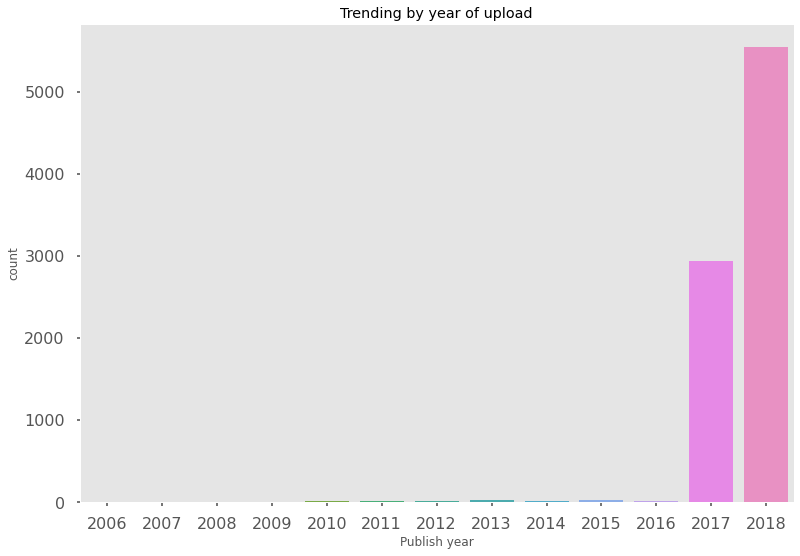

In [0]:
data['publish_year'] = data.publish_time.dt.year
ax = sns.countplot(data.publish_time.dt.year);
ax.set_title('Trending by year of upload');
ax.set_xlabel('Publish year');

The majority of the videos has been published in 2018 and 2017. It means, that the videos generally are reaching the trending list very soon after being uploaded. There are however some videos that have been published earlier.

#### month

In [0]:
data["publish_month"] = data.publish_time.dt.month
months = ['November', 'December', 'January', 'February', 
          'March', 'April', 'May', 'June', 'July', 'August', 
          'September', 'October']

sns.countplot(data.publish_time.dt.month_name(), 
              order=months)
plt.xticks(rotation=45)
plt.xlabel('Publish month');
plt.title('Trending by month of upload');

Looking at the plot we should put attention to **November** and **June**. _Trending_ data comes from a time window of **7 months**: from the 14th of November until the 14th of June. There are however almost 4 times less of videos from June than from November. We can make a hypothesis, that the movies need some time to get trending. To verify it we will check the distribution of a difference between `trending_date` and `publish_date`.

In [0]:
data["publish_date"] = data.apply(lambda row: row["publish_time"].date(), axis=1)
data["trending_date_conv"] = data.apply(lambda row: row["trending_date"].date(), axis=1)
data["time_to_viral"] = data.apply(lambda row: (row["trending_date_conv"] - row["publish_date"]).days, axis=1)

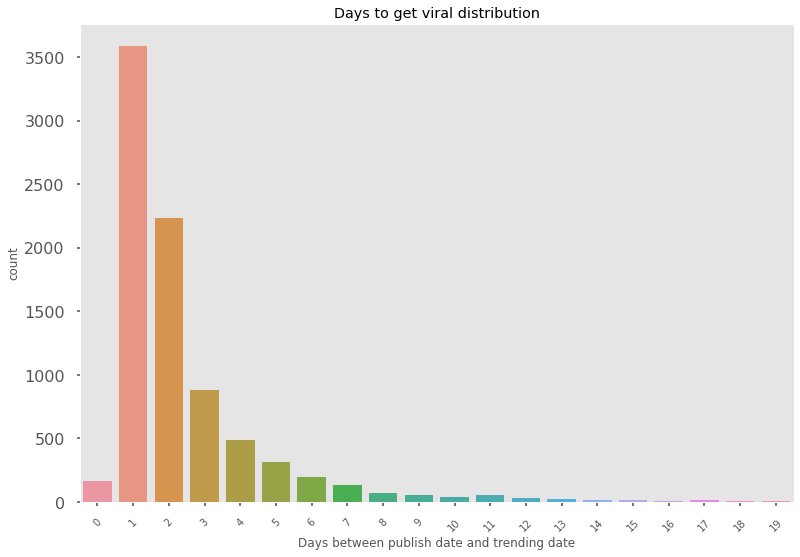

In [0]:
sns.countplot(data.time_to_viral, order=range(20))
plt.xticks(rotation=45, fontsize=10)
plt.xlabel('Days between publish date and trending date')
plt.title('Days to get viral distribution');

As we can see the majority of the videos makes it to the treniding list during the first week. However, reaching it on the day of the publication is unlikely - the most probable day is the 1st one after uploading.

#### hour

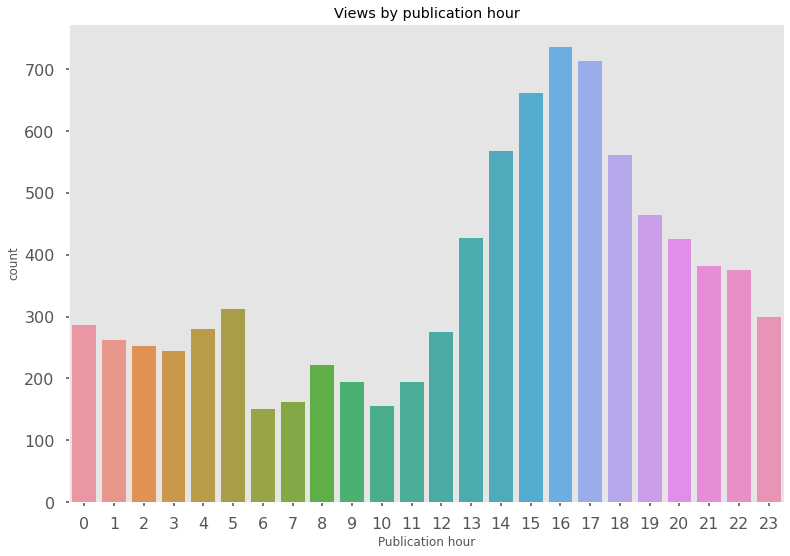

In [0]:
data["publish_hour"] = data.publish_time.dt.hour + data.publish_time.dt.minute/60
sns.countplot(data.publish_time.dt.hour)
plt.xlabel("Publication hour");
plt.title('Views by publication hour');

As we can see, the publication number goes up at 16 and 17. We can also see an increase at 5. This may be caused by multiple reasons. It's possible that people publish the videos after work, or the videos are published on purposes after the working hours, because the youtubers know, that on that time there is a lot of people active on the network.

#### day

In [0]:
data["publish_day"] = data.publish_time.dt.weekday

In [0]:
days = data.publish_time.dt.day_name().unique()
print(days[[0,5,4,3,1,2,6]])

['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']


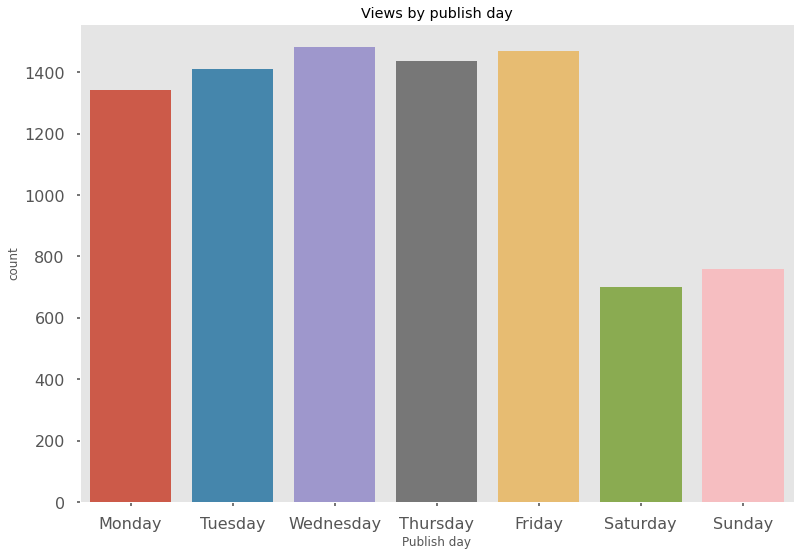

In [0]:
sns.countplot(data.publish_time.dt.day_name(), order=days[[0,5,4,3,1,2,6]])
plt.xlabel("Publish day");
plt.title('Views by publish day');

The majority of the _trending_ videos is being published during the week. Without additional data, we can't find out if it's a general trend, or maybe the videos published during the week have a higher chance of getting into _trending_.

### Tags

In [0]:
data.tags.head()
data.tags.values[0]
data.tags.values[0].replace('"',"").split('|')

def prepare_tags(tags):
    return tags.lower().replace('"', '').split('|') if tags != '[none]' else None

data['tags_split'] = data.tags.apply(prepare_tags)

In [0]:
all_tags = [tags for tags in data.tags_split if tags != None]
all_tags = list(itertools.chain.from_iterable(all_tags))
tags100 = {a: b for a, b in Counter(all_tags).most_common(100)}

wordcloud = WordCloud(background_color='white',
                      max_words=50, 
                      max_font_size=40,
                      random_state=42).generate_from_frequencies(tags100)

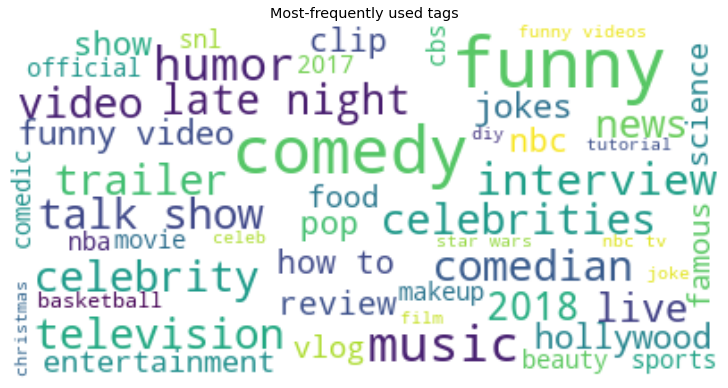

In [0]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.grid(b=None)
plt.axis("off")
plt.title("Most-frequently used tags");

On the plot above we can see the most popular tags. The majority of them is connected to entertainment.

In [0]:
# Get top1000 tags for each month
data["trending_month"] = data.apply(lambda row: row["publish_time"].month, axis=1)

tags_monthly = {}
all_top_monthly = {}

for i in range(1, 13):
    all_tags = [tags for tags in data.loc[data.trending_month==i, 'tags_split'] if tags != None]
    all_tags = list(itertools.chain.from_iterable(all_tags))
    tags = {a: b for a, b in Counter(all_tags).most_common(1000)}
    tags_monthly[i] = tags
    all_top_monthly[i] = list(tags.keys())

# Get unique ones from recieved tops
unique_monthly = [entry for entry, num in Counter(itertools.chain.from_iterable(all_top_monthly.values())).most_common() if num==1]

# Remove non-unique ones from each month's top1000
for month in tags_monthly:
    to_delete = []
    for tag in tags_monthly[month]:
        if not(tag in unique_monthly):
            to_delete.append(tag)
    for tag in to_delete:
        del tags_monthly[month][tag]

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate_from_frequencies(tup)
    return wordcloud

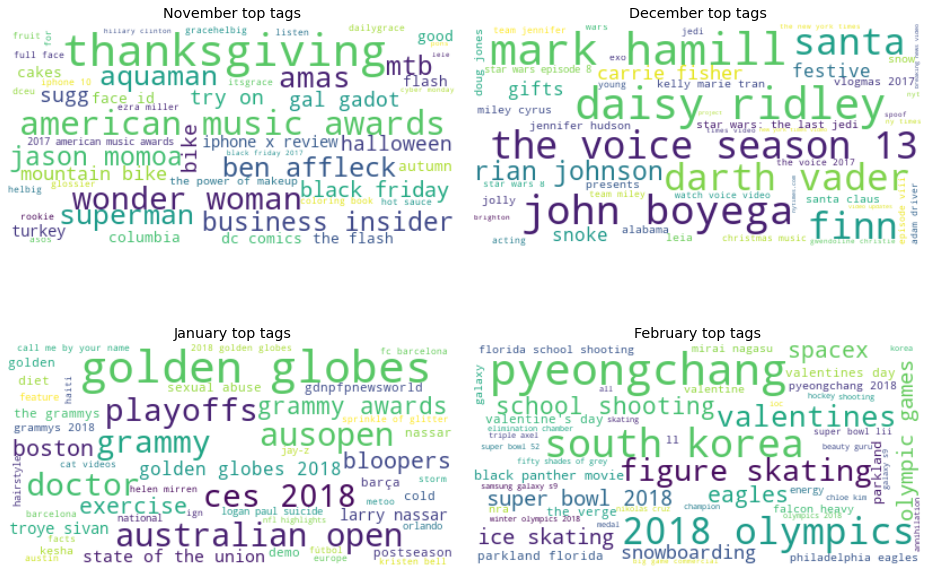

In [0]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[11]), interpolation="bilinear")
axs[0,0].title.set_text("November top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[12]), interpolation="bilinear")
axs[0,1].title.set_text("December top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[1]), interpolation="bilinear")
axs[1,0].title.set_text("January top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[2]), interpolation="bilinear")
axs[1,1].title.set_text("February top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

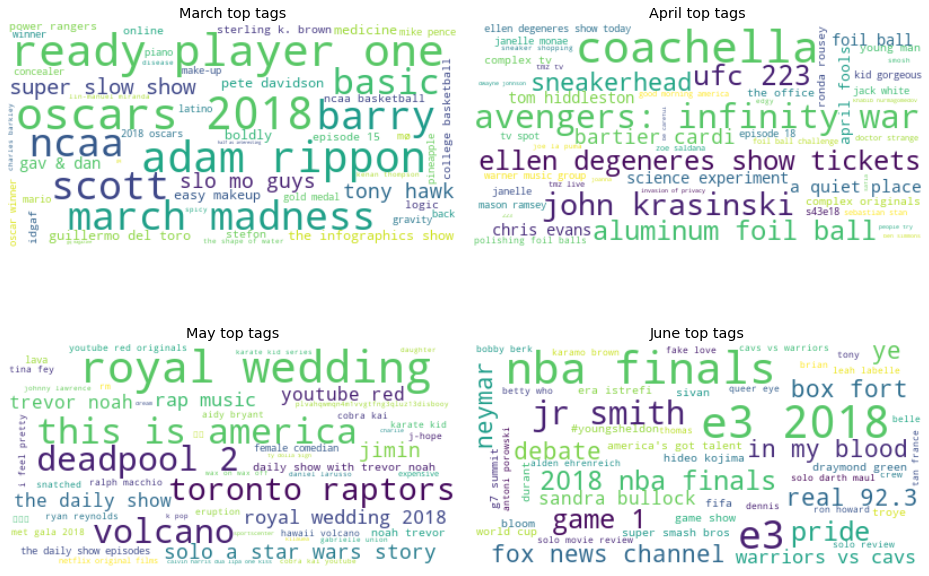

In [0]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[3]), interpolation="bilinear")
axs[0,0].title.set_text("March top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[4]), interpolation="bilinear")
axs[0,1].title.set_text("April top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[5]), interpolation="bilinear")
axs[1,0].title.set_text("May top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[6]), interpolation="bilinear")
axs[1,1].title.set_text("June top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

### Views

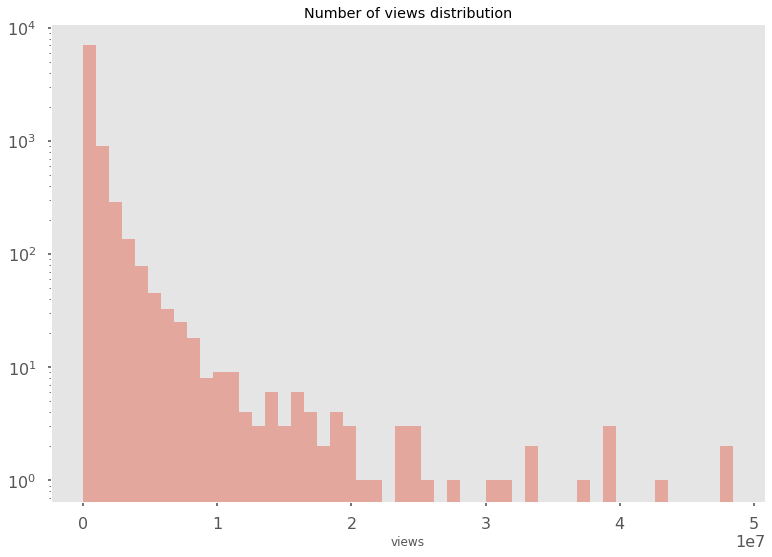

In [0]:
ax = sns.distplot(data.views, kde=False)
ax.set_yscale('log')
ax.set_title('Number of views distribution');

### Likes

In [0]:
ax = sns.distplot(data.likes, kde=False);
ax.set_yscale('log');

### Dislikes

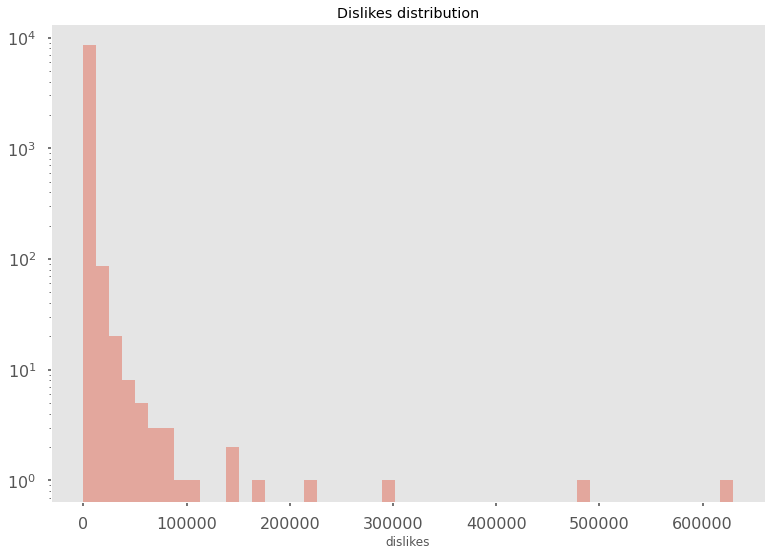

In [0]:
ax = sns.distplot(data.dislikes, kde=False)
ax.set_title('Dislikes distribution')
ax.set_yscale('log');

### Comment count

In [0]:
ax = sns.distplot(data.comment_count, kde=False);
ax.set_title('Comments distribution');
ax.set_yscale('log');

_Views, Likes, Dislikes_ and _Comments_  have a similar, skew distribution. There is a small number of movies with very high views, stiting up highly positive or negative emotions or collecting a lot of comments.

### Thumbnail_link

In [0]:
data.thumbnail_link.head()

0      https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg
406    https://i.ytimg.com/vi/lY_0mkYDZDU/default.jpg
403    https://i.ytimg.com/vi/abGCYPCk294/default.jpg
400    https://i.ytimg.com/vi/cccyOn99s4Y/default.jpg
397    https://i.ytimg.com/vi/UFYCTJlayS4/default.jpg
Name: thumbnail_link, dtype: object

All the links are similar - the only difference is the video id.

### comments_disabled

In [0]:
plt.pie(data.comments_disabled.value_counts()/data.comments_disabled.count(), 
        labels=["Comments enabled", "Comments disabled"], 
        autopct='%1.1f%%');
plt.title('Comments');

Almost all (**98.4%**) of the videos have the comments function enabled. It would be interesting to take a closer look at the ones with the comments disabled an try to find out why - maybe they were some kind of government announcments or controversial content ones.

### Rating disabled

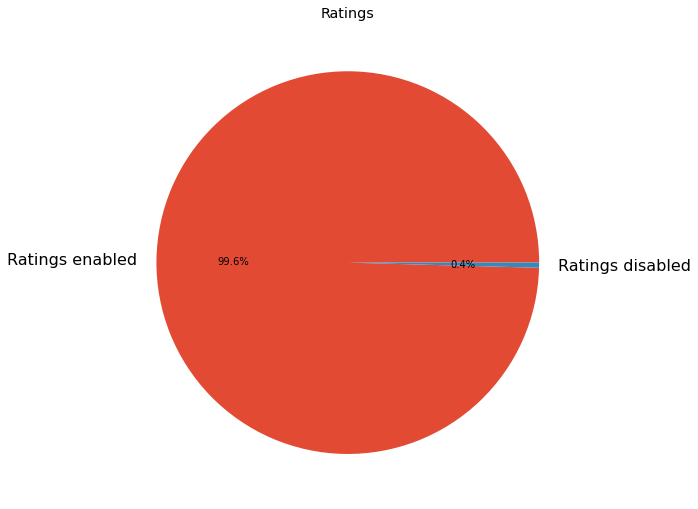

In [0]:
plt.pie(data.ratings_disabled.value_counts()/data.ratings_disabled.count(),
        labels=["Ratings enabled", "Ratings disabled"], 
        autopct='%1.1f%%');
plt.title('Ratings');

The videos with the rating turned-off are makeing only  **0,4%** of the data. Like above, it could be interesting to analyze them.

### video_error_or_removed 

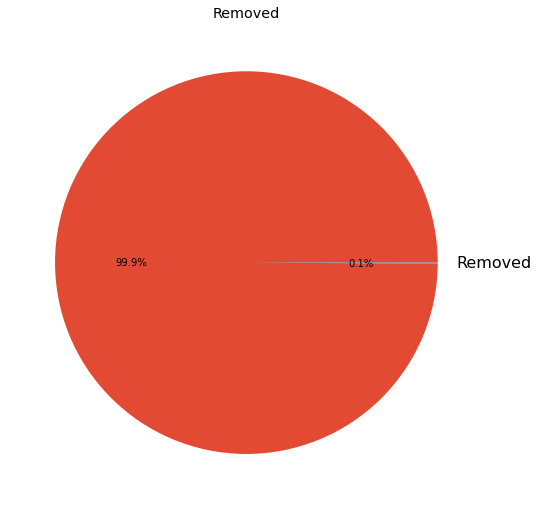

In [0]:
plt.pie(data.video_error_or_removed.value_counts()/data.video_error_or_removed.count(),
        labels=["", "Removed"], 
        autopct='%1.1f%%');
plt.title('Removed');

There are some removed videos in the data set. Maybe they gained their popularity because of being controversial and later they got removed or they were breaking some copyright laws. It could be analyzed later.

### description

In [0]:
data.columns = data.columns.str.replace('description ', 'description')

In [0]:
data[['description']].head()

description
0    SHANTELL'S CHANNEL - https://www.youtube.com/s...
406  Experience the Sit Next to Me video best on yo...
403  On this episode of The John Campea Show (Recor...
400  But are you subscribed tho: https://www.youtub...
397  Best phone apps for creativity & being product...

# Feature engineering

Dostępne atrybuty są mniej lub bardziej informatywne dla postawionego problemu. Na przykład można zastanowić się, czy liczba pozytywnych reakcji sprzyja wyższej oglądalności, jednak nie jest to czynnik, który autor filmu ma pod kontrolą. Niektóre z artybutów można poddać dodatkowym operacjom mającym na celu ekstrakcję cech, które będą przydatne w procesie odkrywania wiedzy. Do takich atrybutów należą na pewno: 

In [0]:
def length(wordlist):
    if wordlist is None: return 0
    else: return len(wordlist)

def onlyalpha(string):
    return word_tokenize(''.join([char for char in string if char.isalpha() or char.isspace()]))

def count_capitals(alphalist):
    string = ''.join(alphalist)
    if len(string) == 0:
        return 0
    else: return len([char for char in string if char.isupper()])/ len(string)
    
def tokenize(column):
    if column is None:
        return []
    else:
        string = str(column)
        return word_tokenize(string)

def count_words(linklist, word):
    return ''.join(linklist).count(word)

### Title

New features:
 * `title_num_words` - number of words in title (numbers excluded) 
 * `title_capital` - percentage of capital letters
 * `title_exc_count` - number of exclamation marks
 * `title_que_count` - number of question marks

In [0]:
data['title_split'] = data.title.apply(word_tokenize)
title_alpha = data.title.apply(onlyalpha)
data['title_num_words'] = title_alpha.apply(length)
data['title_capital'] = title_alpha.apply(count_capitals)
data['title_exc_count'] = data.apply(lambda row: row['title'].count('!'), axis=1)
data['title_que_count'] = data.apply(lambda row: row['title'].count('?'), axis=1)

In [0]:
data[['video_id','title_split', 'title_num_words', 
      'title_capital', 'title_exc_count', 'title_que_count']].head(8)

video_id  ... title_que_count
0      2kyS6SvSYSE  ...               0
406    lY_0mkYDZDU  ...               0
403    abGCYPCk294  ...               0
400    cccyOn99s4Y  ...               0
397    UFYCTJlayS4  ...               0
55911  X9VlCV1ZflQ  ...               0
383    2Vv-BfVoq4g  ...               0
56123  xq9FgX_mXiE  ...               0

[8 rows x 6 columns]

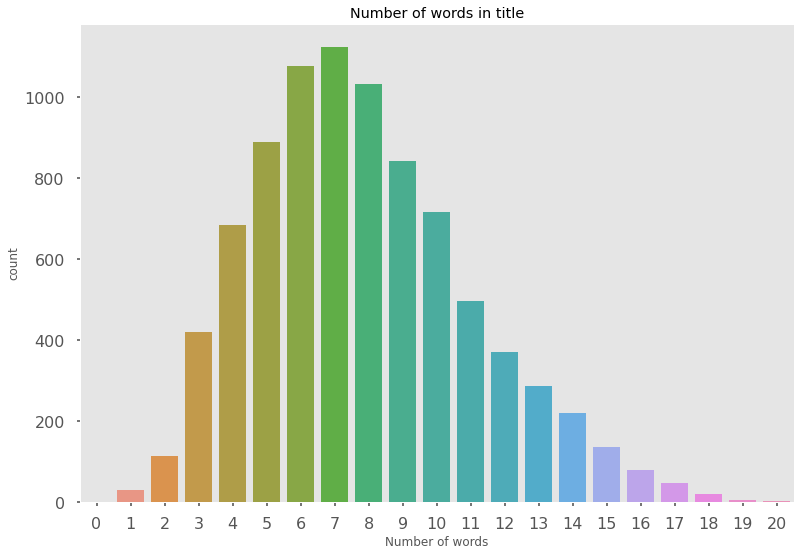

In [0]:
sns.countplot(data.title_num_words)
plt.xlabel("Number of words");
plt.title('Number of words in title');

The distribution is centered around 7 words in title.

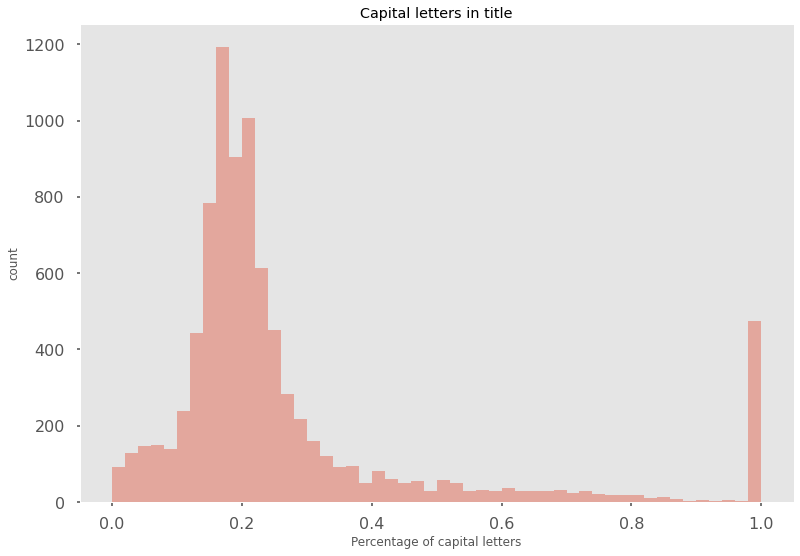

In [0]:
sns.distplot(data.title_capital, kde=False);
plt.xlabel("Percentage of capital letters");
plt.ylabel('count')
plt.title('Capital letters in title');

We can see that some of the titles were written entirely with capital letters. For the other ones, we can see, that the distribution is centered around **20%** of capitals.

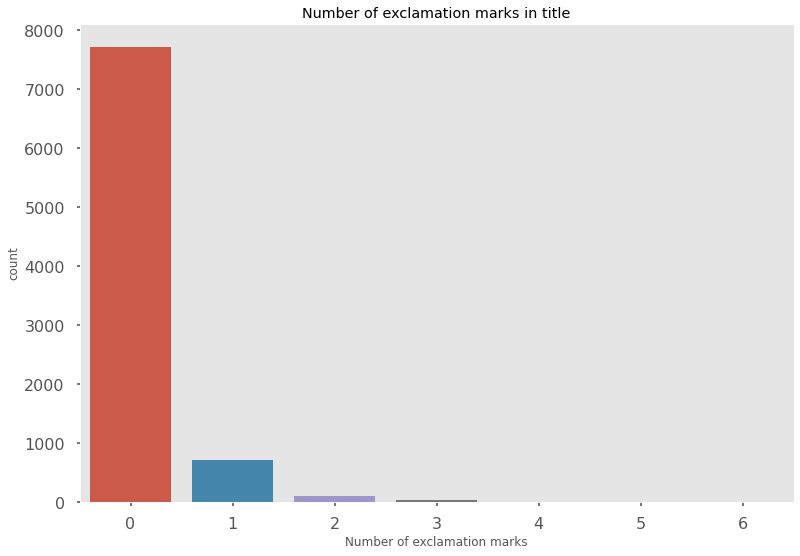

In [0]:
sns.countplot(data.title_exc_count)
plt.xlabel("Number of exclamation marks");
plt.title('Number of exclamation marks in title');

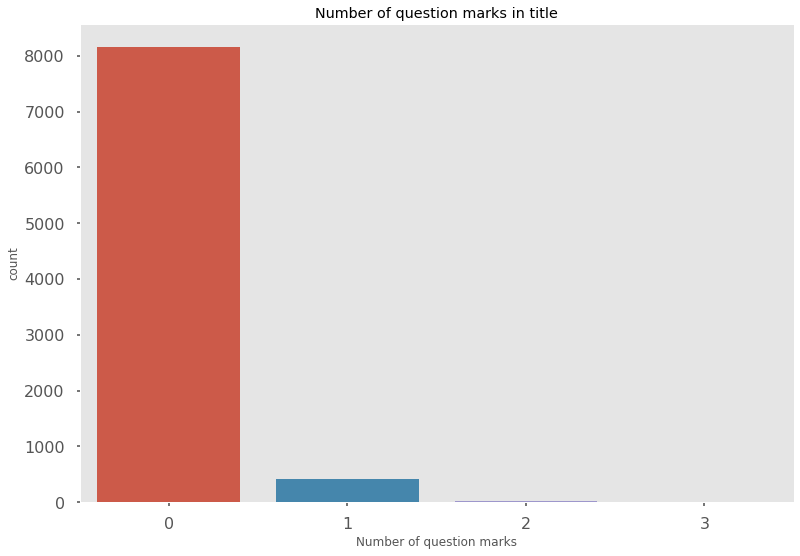

In [0]:
sns.countplot(data.title_que_count)
plt.xlabel("Number of question marks");
plt.title('Number of question marks in title');

### trend_pub_date_diff

In [0]:
data["trend_pub_date_diff"] = data.trending_date.dt.date - data.publish_time.dt.date

* `trend_pub_date_diff` - a difference in days between the publish and trending date

### Tags

* `tags_count` - number of tags
* `uses_previous_tags` - how many of the tags used were previously used in other videos (30 days window)
* `most_common_tags` - the number of 100 hundred most common tags used

#### most_common_tags

In [0]:
most_common100 = [tag for tag, _ in Counter(all_tags).most_common(100)]
data['most_common_tags'] = data.tags_split.apply(
    lambda tags: len(set(tags) & set(most_common100)) if tags else None)

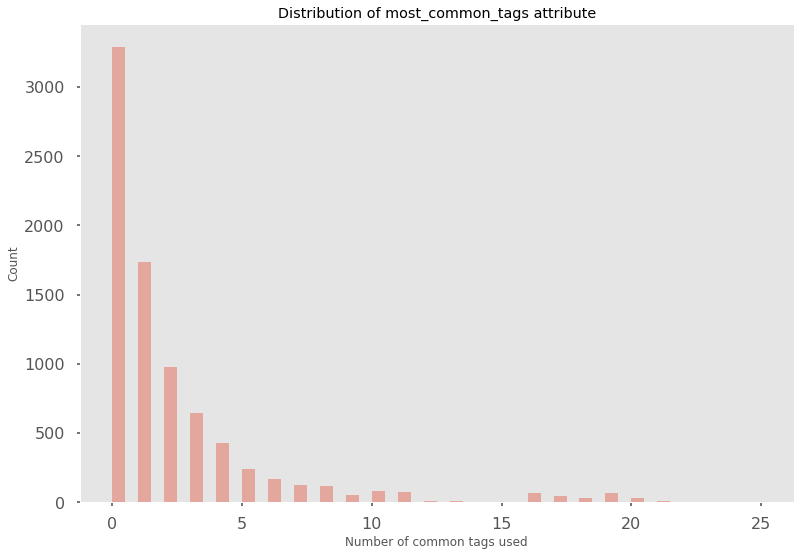

In [0]:
sns.distplot(data.most_common_tags, kde=False);
plt.title('Distribution of most_common_tags attribute');
plt.xlabel('Number of common tags used');
plt.ylabel('Count');

#### uses_previous_tags

In [0]:
@memory.cache
def get_trending_30():
    has_tags = data.tags_split.values != None
    publish_dates = data.publish_time.apply(lambda x: x.date()).unique()
    trending_date_no_zone = data.trending_date.apply(lambda x: x.date())
    trending_30 = {}
    
    for date in publish_dates:
        diff = -(trending_date_no_zone - date)
        last_30 = diff <= timedelta(days=30)
        before = diff >= timedelta(days=0)
        tags_nested = data.loc[last_30 & before & has_tags, 'tags_split']
        trending_30[date] = set(itertools.chain.from_iterable(tags_nested))
    return trending_30

trending_30 = get_trending_30()

In [0]:
def uses_trending_30(row):
    if row.tags_split == None:
        return None
    intersection = set(row.tags_split) & trending_30[row.publish_time.date()]
    return len(intersection)/len(row.tags_split)

In [0]:
@memory.cache
def get_uses_previous_tags():
  return data.progress_apply(
      lambda x: uses_trending_30(x)
      if x.publish_time.date() >= data.trending_date.min() 
      else np.NaN, axis=1
      )

data["uses_previous_tags"] = get_uses_previous_tags()

100%|██████████| 8606/8606 [00:05<00:00, 1592.10it/s]


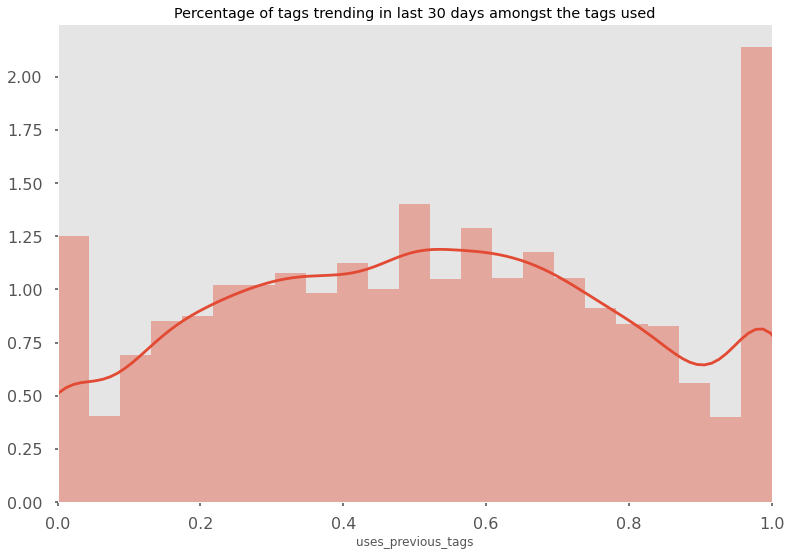

In [0]:
sns.distplot(data.uses_previous_tags).set_title('Percentage of tags trending in last 30 days amongst the tags used');
plt.xlim(0, 1);

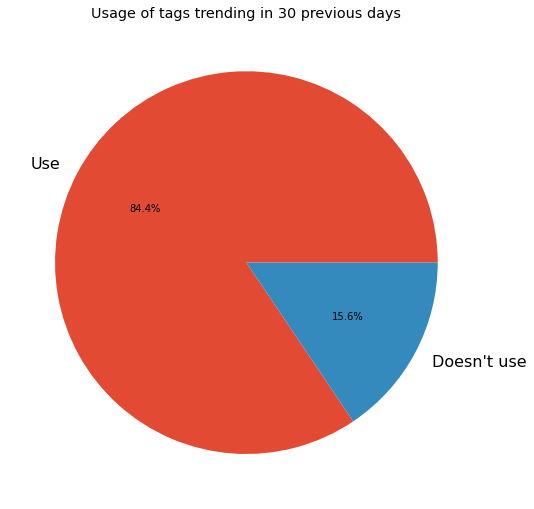

In [0]:
uses_previous_tags_bool = data.uses_previous_tags > 0
plt.pie(uses_previous_tags_bool.value_counts()/uses_previous_tags_bool.count(), 
        labels=["Use", "Doesn't use"], 
        autopct='%1.1f%%');
plt.title("Usage of tags trending in 30 previous days");
del uses_previous_tags_bool

The majority of videos uses tags that appeared in the last 30 days.
We can say that youtubers follow the trends.

#### tags_count

In [0]:
data['tags_count'] = data.tags_split.apply(length)

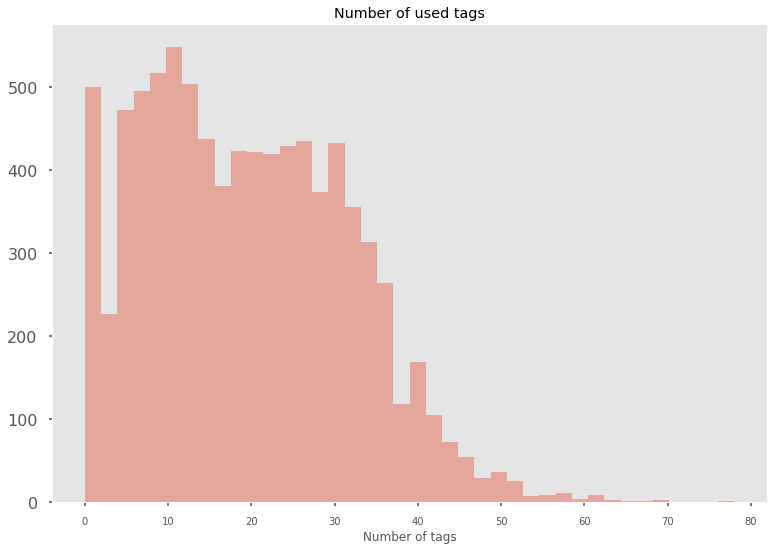

In [0]:
sns.distplot(data.tags_count, kde=False)
plt.xticks(fontsize=10)
plt.xlabel("Number of tags");
plt.title('Number of used tags');

### Description

 * `desc_lines_count` - number of lines
 * `desc_num_words` - number of words
 * `links_count` - number of links
 * `fb_links`, `ig_links`, `tt_links`, `sc_links` - number of Facebook, Instagram, Twitter and Snapchat links
 * `social_links` - sum of the aforementioned

In [0]:
# Source: https://mail.python.org/pipermail/tutor/2002-September/017228.html

urls = '(?: %s)' % '|'.join("""http telnet gopher file wais ftp https""".split())
ltrs = r'\w'
gunk = r'/#~:.?+=&%@!\-'
punc = r'.:?\-'
any = "%(ltrs)s%(gunk)s%(punc)s" % { 'ltrs' : ltrs,
                                     'gunk' : gunk,
                                     'punc' : punc }

url = r"""
    \b                            # start at word boundary
        %(urls)s    :             # need resource and a colon
        [%(any)s]  +?             # followed by one or more
                                  #  of any valid character, but
                                  #  be conservative and take only
                                  #  what you need to....
    (?=                           # look-ahead non-consumptive assertion
            [%(punc)s]*           # either 0 or more punctuation
            (?:   [^%(any)s]      #  followed by a non-url char
                |                 #   or end of the string
                  $
            )
    )
    """ % {'urls' : urls,
           'any' : any,
           'punc' : punc }

url_re = re.compile(url, re.VERBOSE | re.MULTILINE)

def grabUrls(text):
    """Given a text string, returns all the urls we can find in it."""
    return url_re.findall(text)

In [0]:
@memory.cache
def get_desc_lines_count():
    return data.apply(lambda row: str(row['description']).count("\\n"), axis=1)

@memory.cache
def get_desc_clean():
    return data.apply(lambda row: str(row['description']).replace("\\n", " "), axis=1)

@memory.cache
def get_desc_split():
    return data.apply(lambda row: str(row['desc_clean']).split(" "), axis=1)
    
data['desc_lines_count'] = get_desc_lines_count()
data['desc_clean'] = get_desc_clean()
data['desc_split'] = get_desc_split()
data['desc_num_words'] = data.desc_split.apply(length)

In [0]:
@memory.cache
def get_links():
    return data.desc_clean.apply(grabUrls)

@memory.cache
def get_fb_links():
    return data.apply(lambda row: count_words(row['links'], 'facebook'), axis=1)

@memory.cache
def get_tt_links():
    return data.apply(lambda row: count_words(row['links'], 'twitter'), axis=1)

@memory.cache
def get_ig_links():
    return data.apply(lambda row: count_words(row['links'], 'instagram'), axis=1)

@memory.cache
def get_sc_links():
    return data.apply(lambda row: count_words(row['links'], 'snapchat'), axis=1)

data['links'] = get_links()
data['links_count'] = data.links.apply(len)
data['fb_links'] = get_fb_links()
data['tt_links'] = get_tt_links()
data['ig_links'] = get_ig_links()
data['sc_links'] = get_sc_links()
data['social_links'] = data.apply(lambda row: sum([row['fb_links'], row['tt_links'], row['ig_links'], row['sc_links']]), axis=1)

In [0]:
data[['video_id','description','desc_lines_count', 'desc_clean', 'desc_split', 'desc_num_words']].head(8)

video_id  ... desc_num_words
0      2kyS6SvSYSE  ...            159
406    lY_0mkYDZDU  ...             94
403    abGCYPCk294  ...            290
400    cccyOn99s4Y  ...             58
397    UFYCTJlayS4  ...            244
55911  X9VlCV1ZflQ  ...            244
383    2Vv-BfVoq4g  ...            162
56123  xq9FgX_mXiE  ...            187

[8 rows x 6 columns]

In [0]:
data[['video_id', 'links', 'links_count', 'fb_links', 'tt_links', 'ig_links', 'sc_links', 'social_links']].head(8)

video_id  ... social_links
0      2kyS6SvSYSE  ...            3
406    lY_0mkYDZDU  ...            3
403    abGCYPCk294  ...            0
400    cccyOn99s4Y  ...            3
397    UFYCTJlayS4  ...            0
55911  X9VlCV1ZflQ  ...            2
383    2Vv-BfVoq4g  ...            3
56123  xq9FgX_mXiE  ...            3

[8 rows x 8 columns]

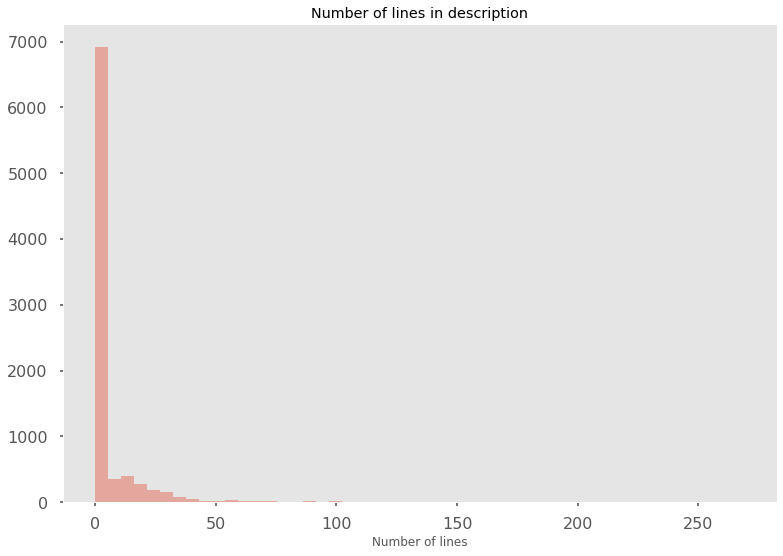

In [0]:
sns.distplot(data.desc_lines_count, kde=False)
plt.xlabel("Number of lines");
plt.title('Number of lines in description');

We can see that there are a lot of videos with one-line description. The majority lies between 0 and 50 lines.

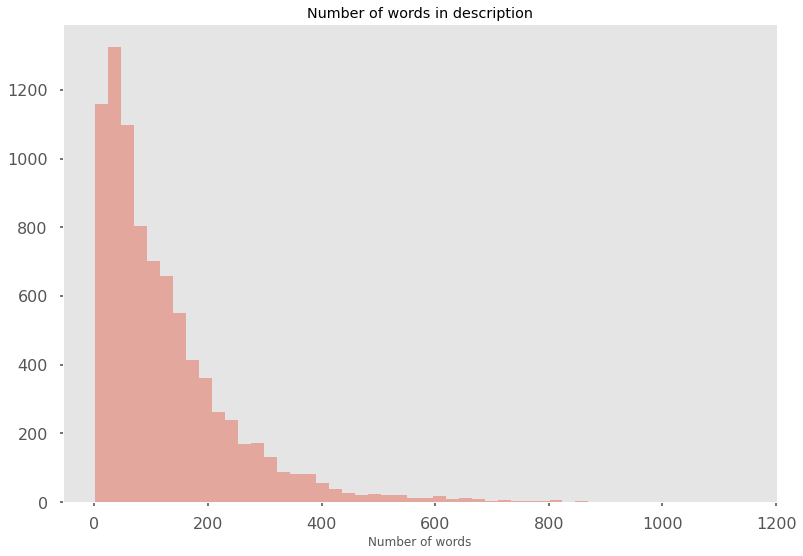

In [0]:
sns.distplot(data.desc_num_words, kde=False)
plt.xlabel("Number of words");
plt.title('Number of words in description');

Taking into account the number of words, the descriptions are also short

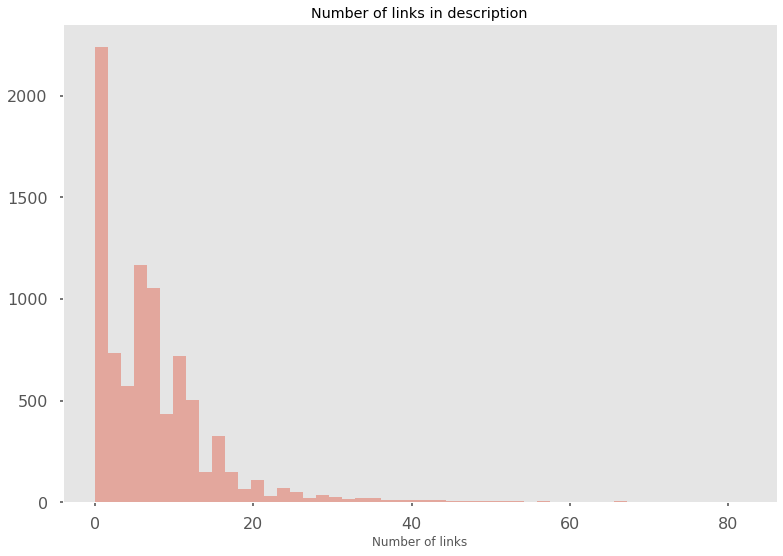

In [0]:
sns.distplot(data.links_count, kde=False)
plt.xlabel("Number of links");
plt.title('Number of links in description');

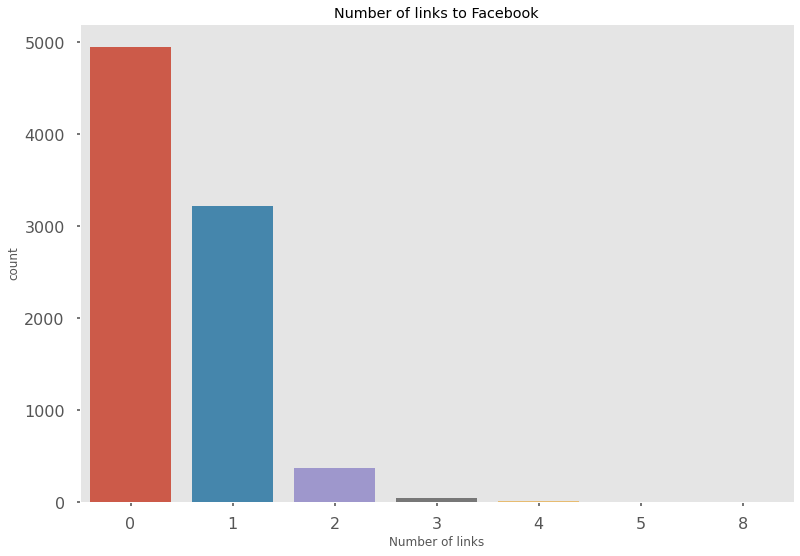

In [0]:
sns.countplot(data.fb_links)
plt.xlabel("Number of links");
plt.title('Number of links to Facebook');

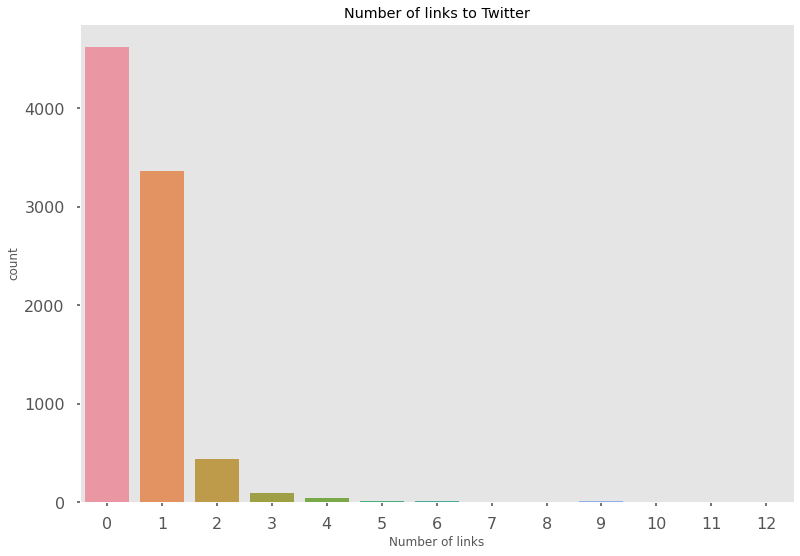

In [0]:
sns.countplot(data.tt_links)
plt.xlabel("Number of links");
plt.title('Number of links to Twitter');

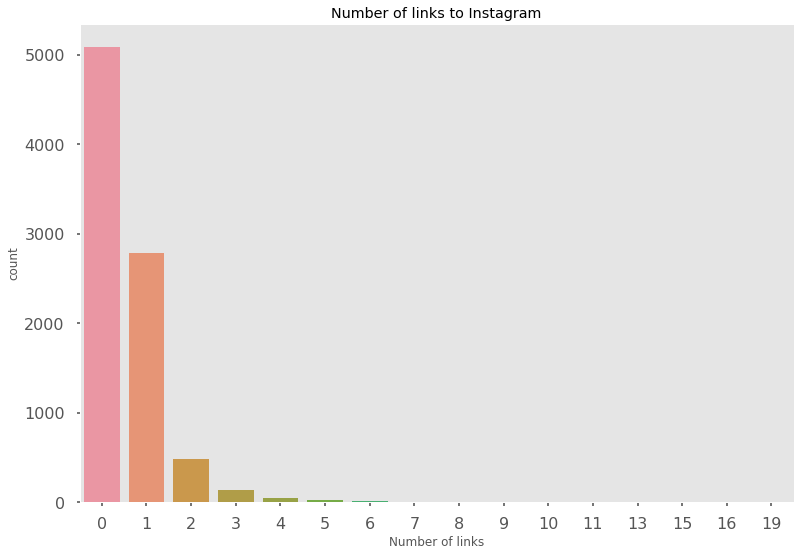

In [0]:
sns.countplot(data.ig_links)
plt.xlabel("Number of links");
plt.title('Number of links to Instagram');

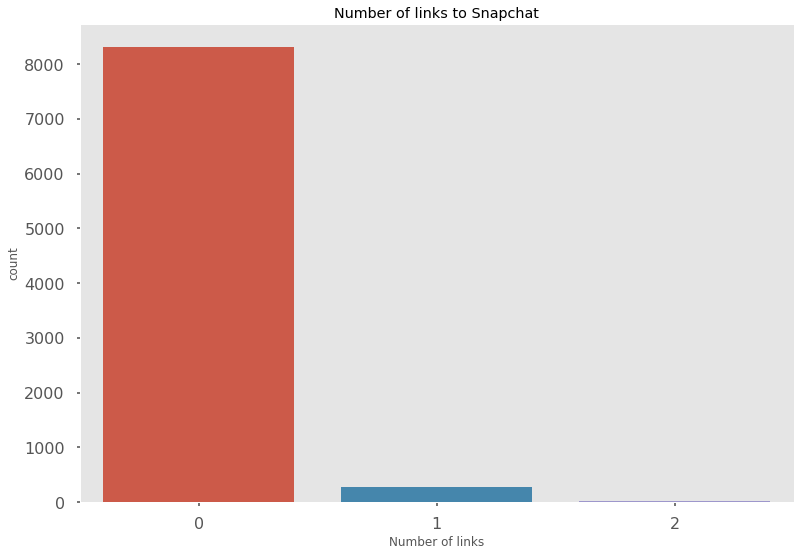

In [0]:
sns.countplot(data.sc_links)
plt.xlabel("Number of links");
plt.title('Number of links to Snapchat');

In [0]:
sns.countplot(data.social_links)
plt.xlabel("Number of links");
plt.title('Number of links to social media');

Almost the half of the videos doesn't have any social media links. We can see, that often the videos have 3 social media links. It can be supposed that those would be to Facebook, Instagram and Twitter. Snapchat is significantly less popular.

### Cyclical attributes
The distance between 10 and 11 o'clock should be equal to the distance between 11 and 12 o'clock.  
Using simple numerical hour representation we loose this desired property. The same applies to month and day of the week.

In order to solve the problem, every ciclical feature _x_ will be represented using 2 variables:
 * $x_{sin} = sin(\frac{2\pi x}{max(x)})$
 * $x_{cos} = cos(\frac{2\pi x}{max(x)})$

#### Hour

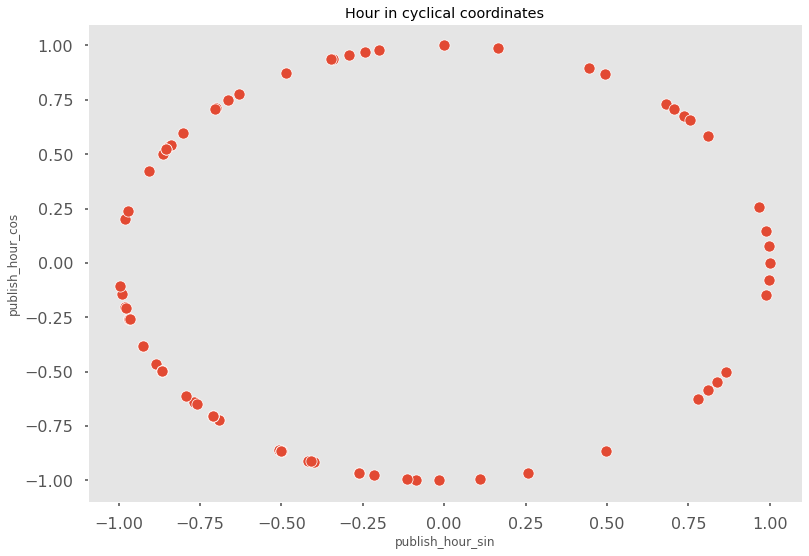

In [0]:
inner_term = 2*np.pi*data.publish_hour/np.max(data.publish_hour)
data["publish_hour_sin"] = np.sin(inner_term)
data["publish_hour_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_hour_sin', y='publish_hour_cos', data=data[::100]).set_title("Hour in cyclical coordinates");

As we can see, we've managed to restore the cyclical character of the attribute.

#### Day of the week

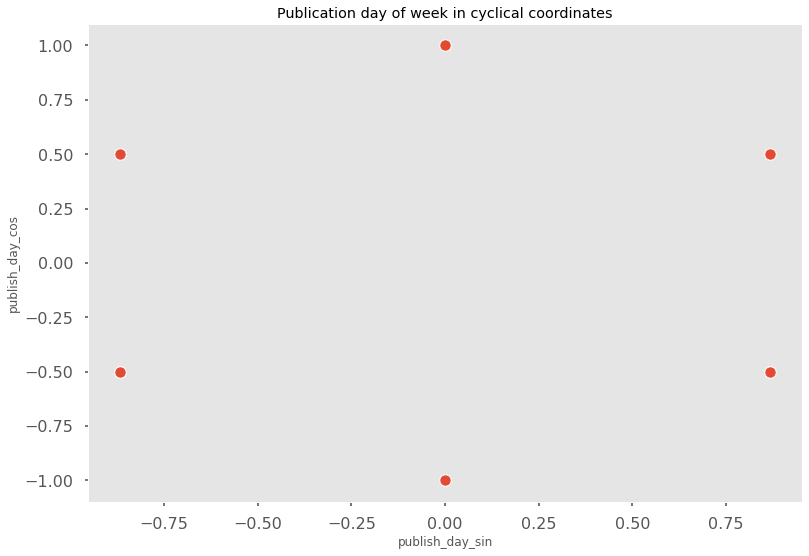

In [0]:
inner_term = 2*np.pi*data.publish_day/np.max(data.publish_day)
data["publish_day_sin"] = np.sin(inner_term)
data["publish_day_cos"] = np.cos(inner_term)
ax = sns.scatterplot(x='publish_day_sin', y='publish_day_cos', data=data)
ax.set_title("Publication day of week in cyclical coordinates");

#### Month

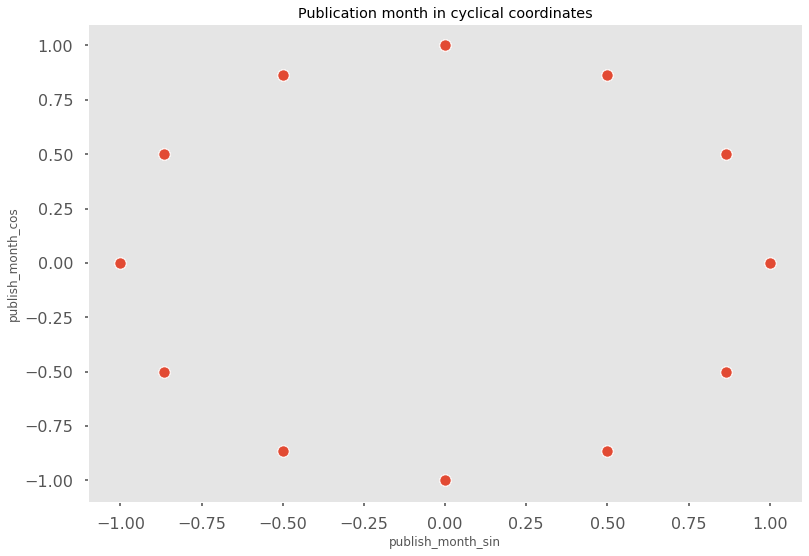

In [0]:
inner_term = 2*np.pi*data.publish_month/np.max(data.publish_month)
data["publish_month_sin"] = np.sin(inner_term)
data["publish_month_cos"] = np.cos(inner_term)
ax = sns.scatterplot(x='publish_month_sin', y='publish_month_cos', data=data)
ax.set_title("Publication month in cyclical coordinates");

New features (for each one `_sin` and `_cos` version):
 * `publish_hour`
 * `publish_day`
 * `publish_month`

### Data dump

In [0]:
LAST_DATA = 'checkpoint1_final.csv'
data.to_csv(path.join(data_path, LAST_DATA), index=False)

NameError: ignored

# Image features

### Load data

In [0]:
LAST_DATA = 'checkpoint1_final.csv'
data = pd.read_csv(path.join(data_path, LAST_DATA))

### Control variables

In [0]:
DOWNLOAD_IMAGES = False # Set if want to download thumbnail images
RUN_DETECTION = False # Set if want to run object detection 

## Helpers

In [0]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Downloading thumbnails 

In [0]:
if DOWNLOAD_IMAGES:
  out = display(progress(0, len(data)), display_id=True)
  failed_links = []
  for i, (index, row) in enumerate(data.iterrows()):
    out.update(progress(i, len(data)))
    try:
        urllib.request.urlretrieve(row['thumbnail_link'], 
                                   path.join(
                                       data_path, 
                                       "images/", row['video_id']+'.jpg'))
    except HTTPError:
        failed_links.append(row['video_id'])
        
  with open(path.join(data_path , 'failed_thumbnails.txt'), 'w') as file:
      wr = csv.writer(file, quoting=csv.QUOTE_ALL)
      wr.writerow(failed_links)

In [0]:
failed_indexes = pd.read_csv(data_path + "/failed_thumbnails.txt").transpose()
failed_indexes = failed_indexes.reset_index()
len(failed_indexes)

680

710 images were not found. Let's check if this fact is linked with attribute `video_error_or_removed`.

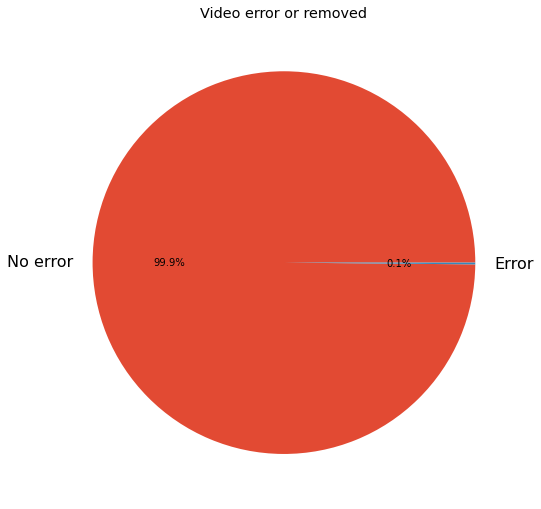

In [0]:
failed_data = data.loc[data['video_id'].isin(failed_indexes['index'])]
plt.pie(failed_data.video_error_or_removed.value_counts()/failed_data.video_error_or_removed.count(),
        labels=["No error", "Error"], 
        autopct='%1.1f%%');
plt.title('Video error or removed');

The lack of image is not linked with `video_error_or_removed` attribute.

## Attributes created from the image

### Object Recognition

Before using the library for object recognition, we chcecked it on sample data:

In [0]:
if RUN_DETECTION:
  sample_images = ['_0Wz8e4W-oE', '_ASpoeFRTZ0', '_iGAptGAweo', 
                  '_IoOJu2_FKE', '_w58R1OGQFA', '0C3pC-uonZU', 
                  '0mAS2Gxs08w', '0noUI5HLY4I', '_5d-sQ7Fh5M' ]

  output_images = []
  labels = []
  for img in sample_images:
    im = cv2.imread(os.path.join(data_path, 'images', 'thumbnails', img + '.jpg'))
    bbox, label, conf = cv.detect_common_objects(im)
    output_image = draw_bbox(im, bbox, label, conf)
    output_images.append(output_image)
    labels.append(label)
  fig=plt.figure()
  columns = 3
  rows = 3

  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      io.imshow(cv2.cvtColor(output_images[i-1], cv2.COLOR_BGR2RGB))
  plt.show()

  print(labels)

#### Recognizing objects on whole dataset

Object recognition works quite well, so we will use it for recognition on the whole dataset:

In [0]:
if RUN_DETECTION:
  img_path = os.path.join(data_path, 'images', 'thumbnails')
  img_names = listdir(img_path)
  objects = []
  i=0
  for name in img_names:
      recognized = dict()
      im = cv2.imread(os.path.join(img_path + name))
      recognized['video_id'] = name
      _, recognized['labels'], recognized['conf'] = cv.detect_common_objects(im)
      objects.append(recognized)

  objects_all = {}
  for d in objects:
      how_many = len(d['labels'])

      for key, val in d.items(): 
          if key not in objects_all:
              objects_all[key] = []

          if how_many == 0:
              if key == 'video_id':
                  objects_all[key].append(val)
              else:
                  objects_all[key].append('NaN')

          for i in range(how_many):
              if key == 'video_id':
                  objects_all[key].append(val)
              else:
                  objects_all[key].append(val[i])

  recognized_objects = pd.DataFrame.from_dict(objects_all)
  recognized_objects.to_csv(os.path.join(data_path, 'recognized_objects.csv'), sep=';')

#### Results analysis

The algorithm is not perfect, so we will consider only these objects, for which confidence is equal or greater than 80%.

In [0]:
objects = pd.read_csv(os.path.join(data_path, 'detected_objects.csv'), sep=';')
objects = objects.loc[objects['conf'] >= 0.8]

In [0]:
objects.head(6)

video_id  labels      conf
1  -43MBOJnVks  person  0.989490
2  -39ysKKpE7I  person  0.994256
3  -39ysKKpE7I     tie  0.943891
5  -5WBCrazSfg  person  0.822747
6  -66xHRJSPxs     dog  0.962326
7  -66xHRJSPxs  person  0.931500

In [0]:
counts = objects["labels"].value_counts()
print('number of categories: ', len(objects.labels.unique()))
print(counts)

number of categories:  54
person           6628
tie               259
tv                125
dog                60
car                52
cup                37
bottle             25
cell phone         21
cake               16
bicycle            15
laptop             15
truck              13
donut              12
bowl               10
chair               9
potted plant        8
cat                 8
sandwich            7
frisbee             6
horse               6
train               6
bear                5
sports ball         5
pizza               4
stop sign           4
refrigerator        3
skateboard          3
traffic light       3
clock               3
microwave           2
vase                2
wine glass          2
teddy bear          2
keyboard            2
motorcycle          2
fire hydrant        2
handbag             2
book                1
backpack            1
giraffe             1
bed                 1
oven                1
couch               1
carrot              1
hot do

There are 54 cattegories of objects. People occur most often on the images, which is not surprising. Some objects occur on one thumbnail only, so we will not consider them in further analysis.

In [0]:
categories = []
for key, val in counts.items():
    if val > 1:
        categories.append(key)

In [0]:
len(categories)

37

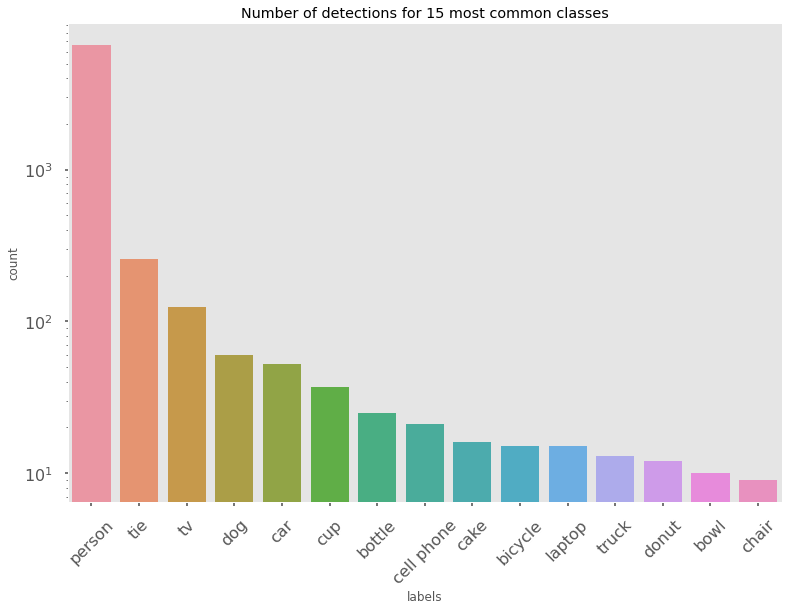

In [0]:
sns.countplot(objects["labels"], order=objects.labels.value_counts().iloc[:15].index, orient="h").set_yscale('log')
plt.xticks(rotation=45)
plt.title('Number of detections for 15 most common classes');

For each image we will construct a vector representation of detected objects. Each position will correspond to one of 37 categories and each value will represent number of objects of the category occuring on given image.

In [0]:
cat_dict = dict()
for i, cat in enumerate(categories):
  cat_dict[cat] = i

In [0]:
def get_objects_vector(vid_id, categories):
  vec = np.zeros((len(categories), 1))
  img = objects.loc[objects['video_id']==vid_id]
  cat_count = img.labels.value_counts()

  for key, val in cat_count.items():
    if key in categories:
      index = categories[key]
      vec[index] = val
  
  return vec.flatten().astype(int)

@memory.cache
def def_get_objects_vectors():
  return data.apply(lambda row: get_objects_vector(row['video_id'], cat_dict), axis=1)

In [0]:
objects.head()

video_id  labels      conf
1  -43MBOJnVks  person  0.989490
2  -39ysKKpE7I  person  0.994256
3  -39ysKKpE7I     tie  0.943891
5  -5WBCrazSfg  person  0.822747
6  -66xHRJSPxs     dog  0.962326

In [0]:
vectors = np.stack(def_get_objects_vectors())
vectors = vectors.reshape(data.shape[0], -1)
vectors = pd.DataFrame(vectors, columns=categories)
data = pd.concat([data, vectors], axis=1)
#data = data.iloc[:,1:] # drop index column

In [0]:
data.head()

video_id trending_date  ... fire hydrant handbag
0  2kyS6SvSYSE    2017-11-14  ...            0       0
1  lY_0mkYDZDU    2017-11-14  ...            0       0
2  abGCYPCk294    2017-11-14  ...            0       0
3  cccyOn99s4Y    2017-11-14  ...            0       0
4  UFYCTJlayS4    2017-11-14  ...            0       0

[5 rows x 90 columns]

### Dominant color

For each image we created two attributes: one containing dominant colour and the second one containing pallette of 6 colours.

In [0]:
def get_dominant_color(id):
  try:
    color_thief = ColorThief(os.path.join(data_path, 'images', id + '.jpg'))
    return color_thief.get_color(quality=1)
  except FileNotFoundError:
    return None

def get_palette(id):
  try:
    color_thief = ColorThief(os.path.join(data_path, 'images', id + '.jpg'))
    return color_thief.get_palette(color_count=6)
  except FileNotFoundError:
    return None
    
def get_dominant_colors():
    return data.progress_apply(lambda row: get_dominant_color(row['video_id']), axis=1)

def get_palettes():
    return data.progress_apply(lambda row: get_palette(row['video_id']), axis=1)

In [0]:
color_data = pd.read_csv(path.join(data_path, 'colors_palette.csv'), sep=';')

In [0]:
data = data.merge(color_data, on='video_id')

In [0]:
data.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes',
       ...
       'palette3_b', 'palette4_r', 'palette4_g', 'palette4_b', 'palette5_r',
       'palette5_g', 'palette5_b', 'palette6_r', 'palette6_g', 'palette6_b'],
      dtype='object', length=111)

### HSV mean

We will convert images into HSV color space and get the mean of hue, saturation and value for each of them

In [0]:
@memory.cache
def get_hsv_mean(img):
  im = cv2.imread(os.path.join(data_path, 'images', img + '.jpg'))
  if im is not None:
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    return [np.mean(hsv[:,:,0]), np.mean(hsv[:,:,1]), np.mean(hsv[:,:,2])]
  else:
    return None

In [0]:
# data['hsv_mean'] = data.progress_apply(lambda row: get_hsv_mean(row['video_id']), axis=1)
# data.to_csv(data_path, 'hsv.csv', sep=';', index=False, columns=['video_id', 'hsv_mean'])
hsv_mean = pd.read_csv(path.join(data_path, 'hsv.csv'),
                       sep=';',
                       error_bad_lines=False)

In [0]:
hsv_mean.head(6)

video_id        hue  saturation       value
0  Jw1Y-zhQURU        NaN         NaN         NaN
1  3s1rvMFUweQ        NaN         NaN         NaN
2  n1WpP7iowLc  56.559630   55.025278   81.459074
3  PUTEiSjKwJU  74.728519   94.542315   94.070185
4  rHwDegptbI4        NaN         NaN         NaN
5  AumaWl0TNBo  49.453796   80.833241  109.009815

In [0]:
data = data.merge(hsv_mean, on='video_id')

### Brightness

The last attribute will be image brightness. The higher value of brightness, the more bright image. 

In [0]:
def brightness(idx):
    try:
        im = Image.open(os.path.join(data_path, 'images', 'thumbnails', idx + '.jpg')).convert('L')
        stat = ImageStat.Stat(im)
        return stat.mean[0]
    except FileNotFoundError:
        return None

In [0]:
#data['brightness'] = data.apply(lambda row: brightness(row['video_id']), axis=1 )
# data.to_csv(os.path.join(data_path, 'brightness.csv'), sep=';', index=False, columns=['video_id', 'brightness'])

In [0]:
data = data.merge(pd.read_csv(os.path.join(data_path, 'brightness.csv'), sep=';'), on='video_id')

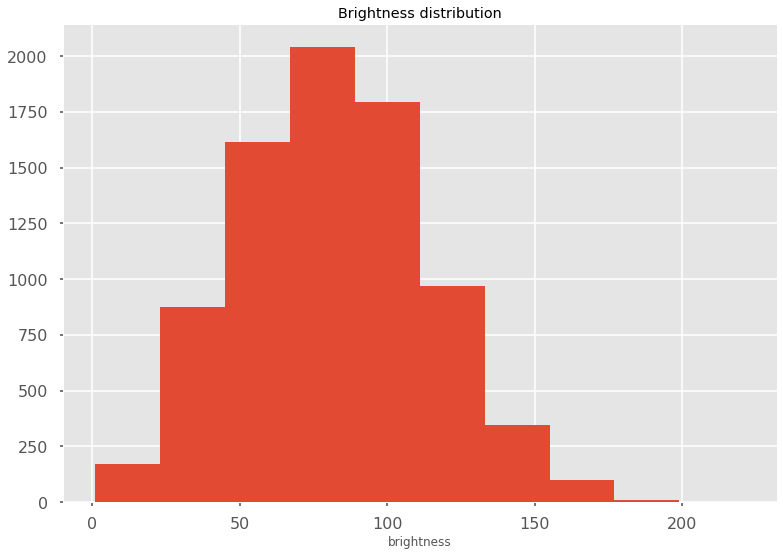

In [0]:
data.brightness.hist()
plt.xlabel('brightness')
plt.title('Brightness distribution');

As we can see, most pictures are moderate bright. The brightness histogram resembles normal distribution.

## Data dump

Let's clean data and delete some helpers columns.

In [0]:
data.columns[0:100]

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'trending_no', 'channel_atr',
       'publish_year', 'publish_month', 'publish_date', 'trending_date_conv',
       'time_to_viral', 'publish_hour', 'publish_day', 'tags_split',
       'trending_month', 'title_split', 'title_num_words', 'title_capital',
       'title_exc_count', 'title_que_count', 'trend_pub_date_diff',
       'most_common_tags', 'uses_previous_tags', 'tags_count',
       'desc_lines_count', 'desc_clean', 'desc_split', 'desc_num_words',
       'links', 'links_count', 'fb_links', 'tt_links', 'ig_links', 'sc_links',
       'social_links', 'publish_hour_sin', 'publish_hour_cos',
       'publish_day_sin', 'publish_day_cos', 'publish_month_sin',
       'publish_month_cos', 'person', 'tie', 'tv', 'dog', 'car', '

In [0]:
data = data.drop(['trending_date_conv', 'time_to_viral', 'tags_split', 'title_split', 'desc_clean', 'desc_split'], axis=1)

In [0]:
LAST_DATA = 'checkpoint2_final.csv'
data.to_csv(path.join(data_path, LAST_DATA), index=False)

## Data load

In [0]:
LAST_DATA = 'checkpoint2_final.csv'
data = pd.read_csv(path.join(data_path, LAST_DATA))

In [19]:
data.head(4)

video_id trending_date  ...      value brightness
0  2kyS6SvSYSE    2017-11-14  ...  85.561667  77.575833
1  lY_0mkYDZDU    2017-11-14  ...  47.178056  42.662037
2  abGCYPCk294    2017-11-14  ...  90.014259  69.746852
3  cccyOn99s4Y    2017-11-14  ...  65.818426  58.986759

[4 rows x 109 columns]

## Attributes summary

* **Quantitive attributes**
     * `views` - number of views - `Int` 
     * `likes` - number of likes- `Int` 
     * `dislikes` - number of dislikes - `Int` 
     * `comment_count` - number of comments - `Int`
     * `trending_no` - number of occurences on trending lists - `Int`
     * `title_num_words` - number of words in title (without numbers) - `Int`
     * `title_capital` - procentage of capital letters in title - `Float <0, 1>`
     * `title_exc_count` - number of exclamation marks - `Int`
     * `title_que_count` - number of question martks - `Int`
     * `tags_count` - number of tags - `Int`
     * `uses_previous_tags` - fraction of tags, which were used before (30 days before publication of video) - `Float <0,1>`  
     * `desc_lines_count` - number of lines in description - `Int`
     * `desc_num_words` - number of words in description - `Int`
     * `links_count` - number of links in description - `Int`
     * `fb_links` - number of Facebook links - `Int`
     * `ig_links` - number of Instagram links - `Int`
     * `tt_links` - number of Twitter links - `Int`
     * `sc_links` - number of SnapChata links - `Int`
     * `social_links` - number of links to social media - sum of Fb, Ig, Tt, Sc - `Int`
     * `publish_hour_sin` - sine of cyclic attribute for publication hour - `Float`
     * `publish_hour_cos` - cosine of cyclic attribute for publication hour - `Float`
     * `publish_day_sin` - sine of cyclic attribute for publication day  - `Float`
     * `publish_day_cos` - cosine of cyclic attribute for publication day - `Float`
     * `publish_month_sin` - sine of cyclic attribute for publication month - `Float`
     * `publish_day_cos` - cosine of cyclic attribute for publication month - `Float`
     * `trend_pub_diff` - number of days between publish day and trending day - `Int`
     * `brightness` - mean brightness of thumbnail - `Float <0, 255>`
     * `hue` - hue value of thumbnail's mean hsv 
     * `saturation` - hue value of thumbnail's mean hsv 
     * `value` - hue value of thumbnail's mean hsv 
     

 * **Categorical attributes**
     * `category_id` - `Int`
     * `comments_disabled` - `Boolean`
     * `rating_disabled` - `Boolean`
     * `video_error_or_removed` - `Boolean`
     * `channel_atr` - channel 
     
 
 * **Representations**
     * `objects` - 37 attributes counting apperances of an object on the image's thunmbnail
     * `dominant_color` - dominant color on thumbnail - `Wector Int <0, 255> of length 3`
     * `palette` - color palette of thumbnail - `Matrix 6x3 Int <0, 255>`

# Notes about attributes useful for classification vs gaining new knowledge for YouTuber

There are some attributes, which video owner can't control directly:
* `views` - the Youtuber can't set the views count, people must see the video - he/she can only attempt to spread it over the Internet or ask friends for help, but still can't control it directly
* `likes`, `dislikes` and`comment_count` - same as `views` - the person can only encourage viewers to give a like

Contrary, above attributes can be helpful in predicting category of video.

The Youtuber can fully control such factors as: video `brightness`, `links` and other words used in the description, features connected with title (`title_num_words`, `title_capital`, `title_exc_count`, `title_que_count`), tags, weather to use tags popular in last month or not and time of video publication. All these attributes can also be useful for classification task.

Attributes based on representations such as embeddings cannot be directly interpreted by human, so they has little informative value for gaining new knowledge, but can be very informative for classifier while assigning a category to the video. One exception is `obj_vec` vector, which tells us how many objects of different type are in the video thumbnails - it can be easily understood by human.

The project consists of two main tasks: category prediction and crafting knowledge for YouTuber, which will allow him or her to make trending videos. Some attributes have been deleted in previous parts of this document, because most probably they wouldn't be useful. Let's discuss some attributes: do they seem to be useful for both tasks? 

#EDA for categories


It is worth to analize attributes distribution with respect to video categories.


In [0]:
df_all = data.drop_duplicates(subset='video_id', keep='last')
df_cat = df_all[~df_all.category_id.isnull()]
df_cat = df_cat.astype({'category_id': 'int32'})

In [0]:
print("Number of categories: ", len(df_cat.category_id.unique()))
print("Number of films with filled category:", len(df_cat), ", percent: ", 100*round(len(df_cat)/len(df),4),  "%")

Number of categories:  16
Number of films with filled category: 448 , percent:  0.5599999999999999 %


## General overview

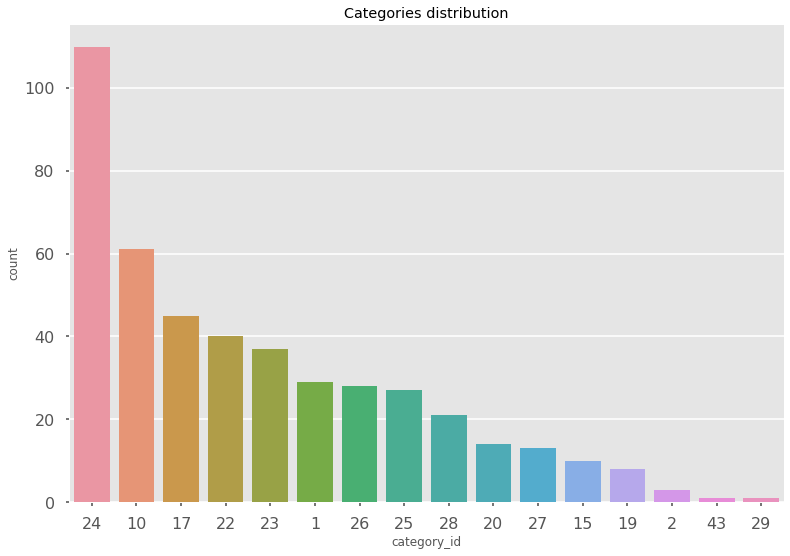

In [0]:
sns.countplot(df_cat.category_id, order=df_cat.category_id.value_counts().index).set_title('Categories distribution');

Data is strongly inballanced with respect to category.

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
def show_plots(data, col, ids, ticks=False, hist=False, rotate=None):
  fig=plt.figure()
  fig.suptitle('Distribution of attribute ' + col + ' by categories', fontsize=16, y=1.0)
  columns = 4
  rows = 4
  for i, id in enumerate(ids):
    data_cat = data.loc[data.category_id == id]
    fig.add_subplot(rows, columns, i+1)
    if hist:
      data_cat[col].hist()
    else:
      sns.countplot(data_cat[col])
    if not ticks:
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
      plt.tick_params(axis='x', labelsize=8)
    if rotate:
      plt.xticks(rotation=rotate)
    plt.tick_params(axis='y', labelsize=12)
    plt.xlabel('')
    plt.title(str(id))
  fig.tight_layout(pad=1.5)
  plt.show()

In [0]:
cats = list(df_cat.category_id.value_counts().keys())

We will analyze distributions of some attributes for categories keeping in mind semi-supervised learning task.




## publish_month

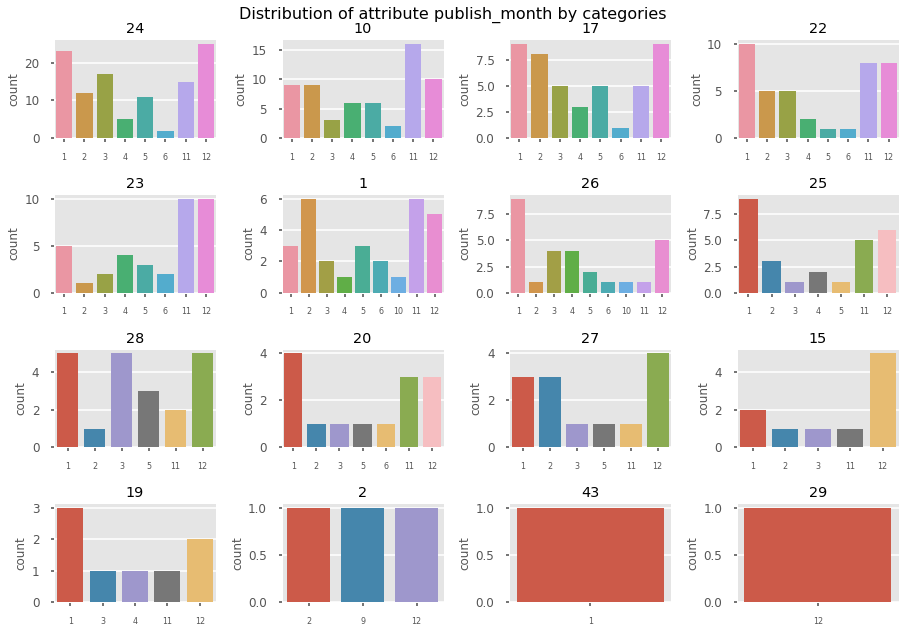

In [0]:
show_plots(df_cat, 'publish_month', cats, ticks=True)

The first, most visible conclusion is quite obvious fact, that along with data amount growth, it's variety also grows. Most categories are quite similar to the global trend when it comes to publish month. Looking further, we can see that there are some differences between categories, so information about publish month could be useful for predicting categories. For example, great majority of films in category 23 was published in late fall and winter months - November, December and January. This category can be related to winter or maybe Christmas. In spite of the fact, that in other categories, a lot of videos comes from November and December, in this category, the dominance is unusually strong. Category number 1 is characteristic because of dominance of February.  The lack of July, August, September and October is not surprising - there were liitle videos from these months in the whole dataset.

## publish_hour

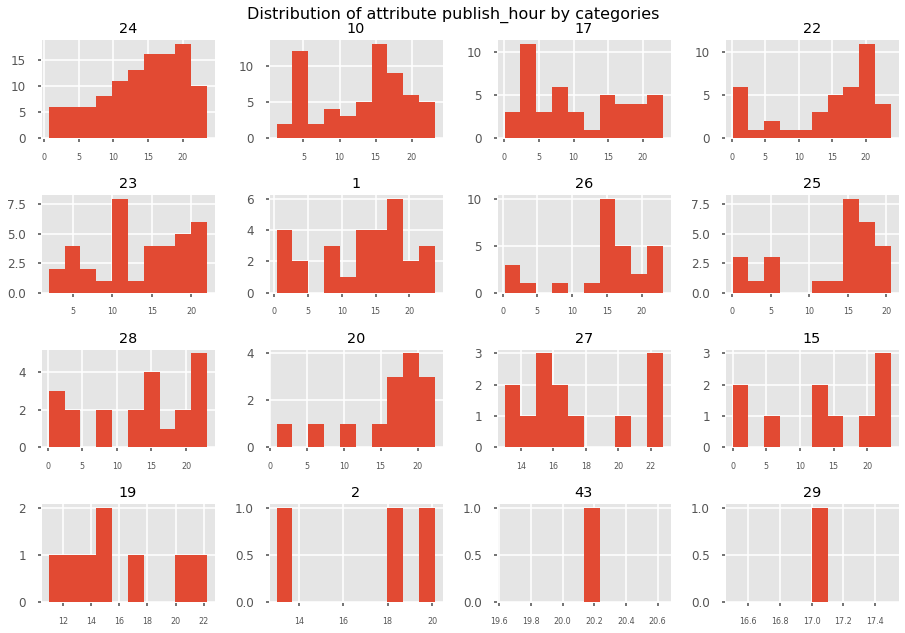

In [0]:
show_plots(df_cat, 'publish_hour', cats, hist=True, ticks=True)

Comparing distributions of publication hours among categories with global distribution, we can observe some intesresting aberrations. The first one is dominance of night hours for category number 17. The second one - the presence of peak around noon hours for category 23. For category 15 the characteristic factor is very little amount of videos published between 15 and 20 o'clock. Hence, we conclude that the time of publication can be an informative premise for the categorization of films.

## publish_day

In [0]:
show_plots(df_cat, 'publish_day', cats, ticks=True)

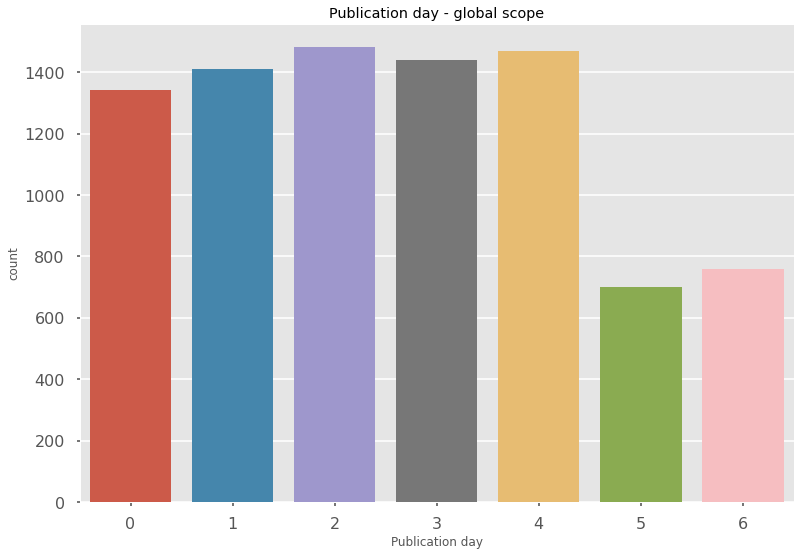

In [0]:
sns.countplot(df_all.publish_day)
plt.xlabel("Publication day");
plt.title('Publication day - global scope');

The publication day also seems to be a good discriminator for the category. It is worth paying attention to category 17, for which films published on Friday and Sunday have the largest share, which is particularly characteristic in the light of the low share of Sunday in the overall trend. Films in category 25 were most often published on Monday, Tuesday and Friday, category 1 on Wednesday and 26 on Thursday.

## trend_pub_diff

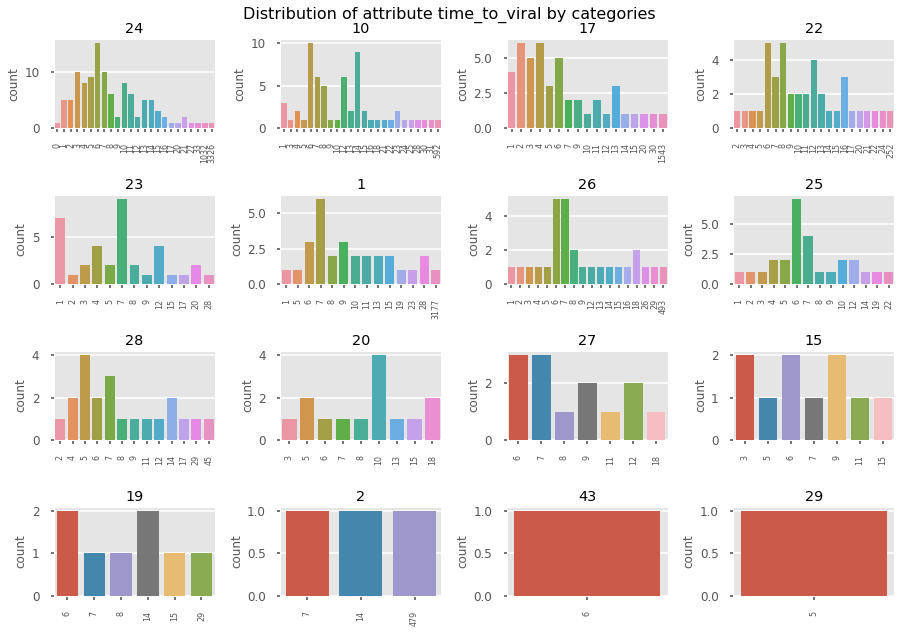

In [0]:
show_plots(df_cat, 'trend_pub_diff', cats, ticks=True, rotate=90)

## title_num_words

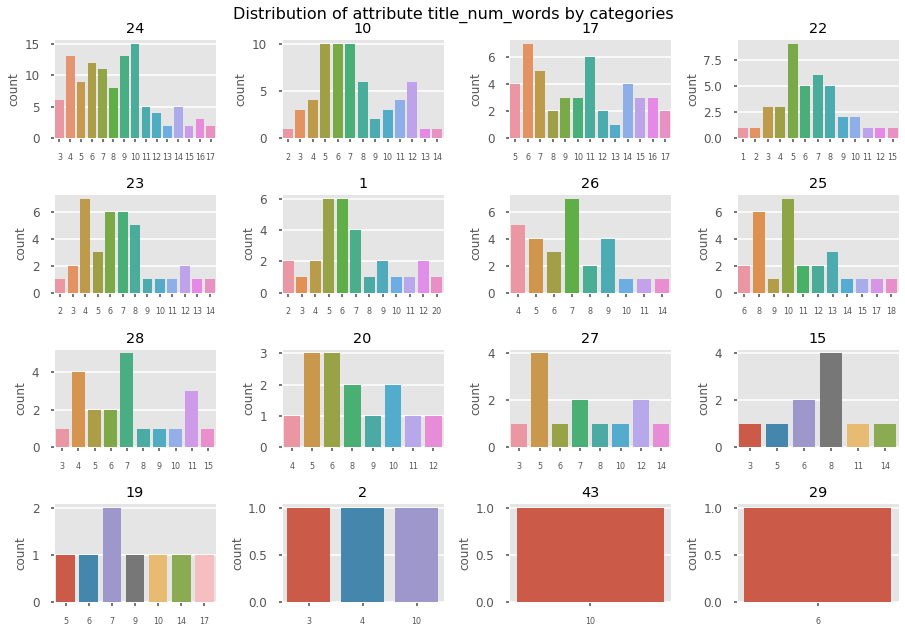

In [0]:
show_plots(df_cat, 'title_num_words', cats, ticks=True)

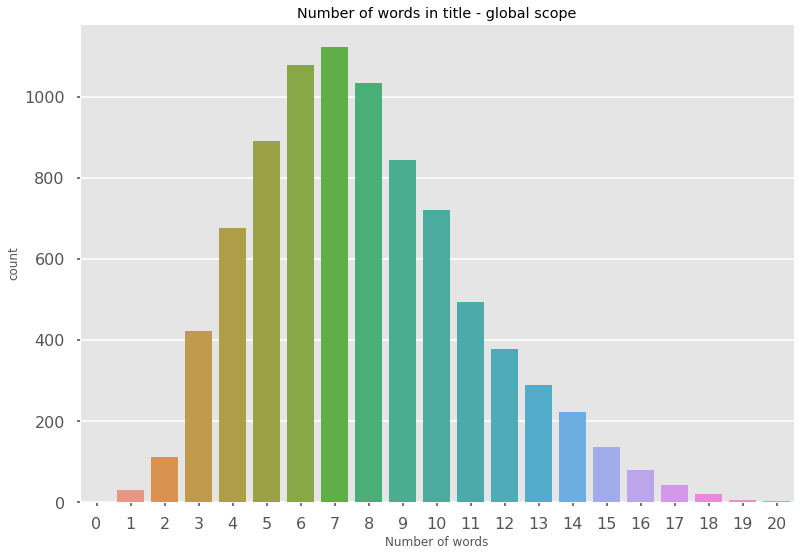

In [0]:
sns.countplot(df_all.title_num_words)
plt.xlabel("Number of words");
plt.title('Number of words in title - global scope');

The most charcteristic category in terms of the length of the movie title is the number 25. Note that movies in this category are from 6 to 18 lengths, and titles between 8 and 10 words are most popular. Perhaps 25 is a category that refers to the topic in need of descriptive, longer titles. Category 26, on the other hand, has relatively short titles - most movies have a length of 4 to 7 words, and only sporadically there are movies with a length exceeding 9.

## views

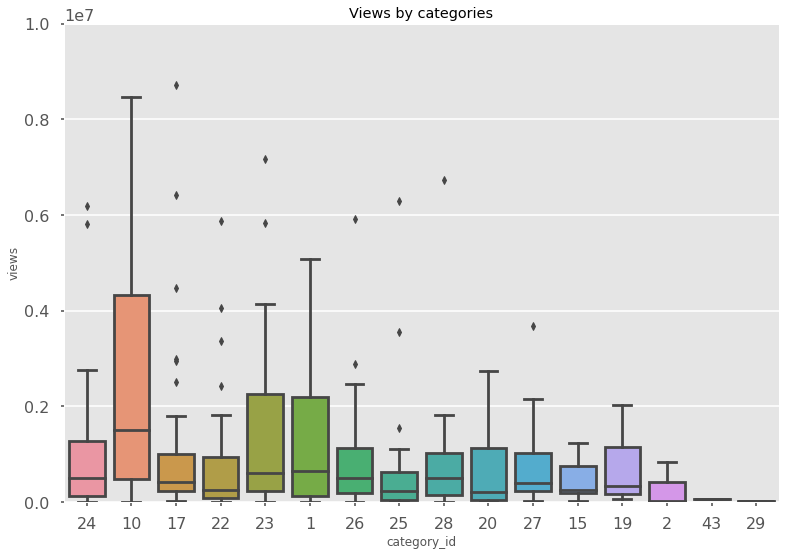

In [0]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['views'], order=cats);
axes = plot.axes
axes.set_ylim(0,1e7);
plt.title("Views by categories");

The differences in the number of views for different categories are immediately visible. One of the categories is distinguished by a very high number of views. This is probably a category related to music. Categories 43 and 29 are very little popular. It may also be related to the fact that they are very poorly represented among the data with the completed category and perhaps in the entire data set.

## likes

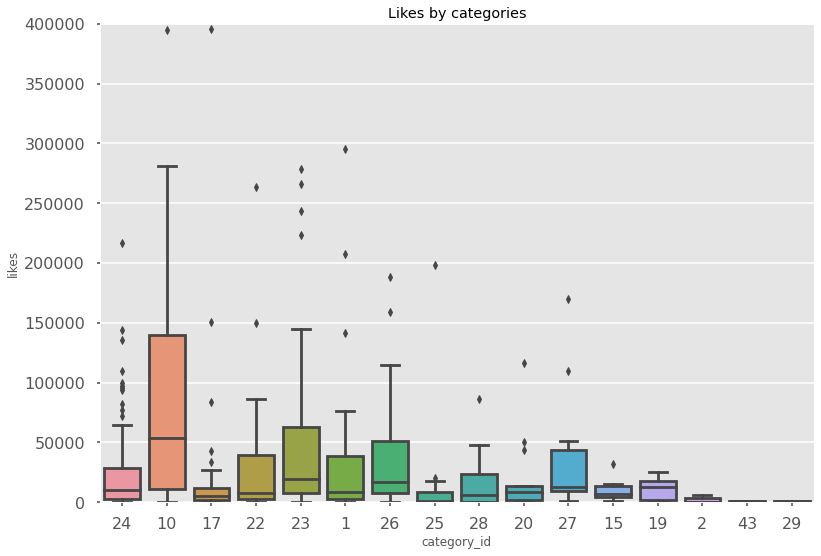

In [0]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['likes'], order=cats);
axes = plot.axes
axes.set_ylim(0,4e5);
plt.title("Likes by categories");

Note the relationship between the number of views and the number of likes. For example: category 10 is the most popular and also receives the most positive reactions - this is not surprising, while category 1, which ranks together with category 23 in second place among popular categories, has relatively fewer likes than category 23 which is more likable. Also movies in category 22 seem more liked than in category 17.

## dislikes

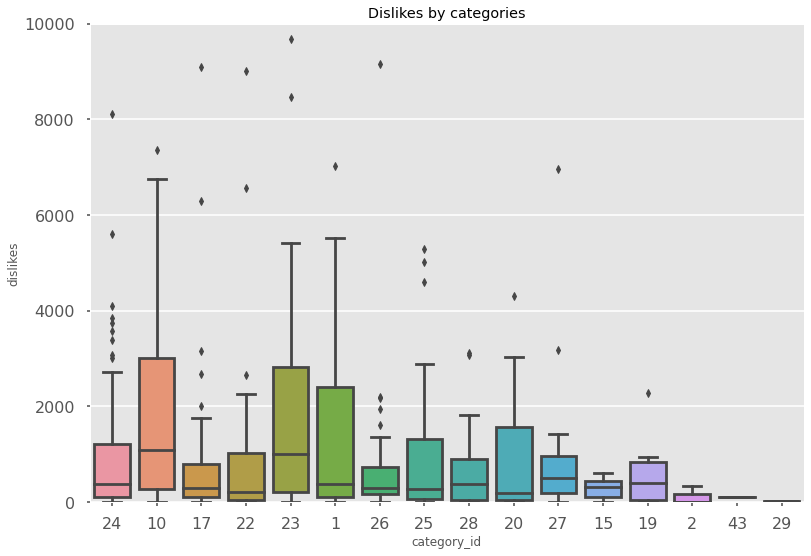

In [0]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['dislikes'], order=cats);
axes = plot.axes
axes.set_ylim(0,1e4);
plt.title("Dislikes by categories");

In the case of negative reactions, one can also notice a relative disproportion for categories 23 and 1. Probably films in category 23 arouse more emotions than in category 1. Perhaps it is related to politics.

All **views, likes, dislikes and comments** seem to be somehow correlated

## comment_count

In [0]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['comment_count'], order=cats);
axes = plot.axes
axes.set_ylim(0,4e4);
axes.set_title('comment_count by categories')

Text(0.5, 1.0, 'comment_count by categories')

The distribution of the number of comments between categories is similar to the distribution of the number of views.

## links_count

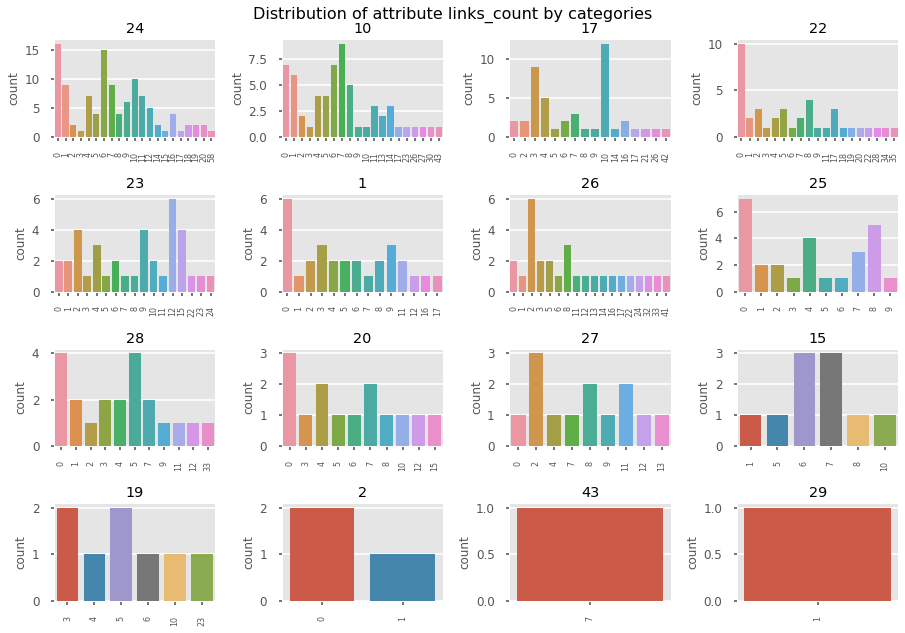

In [0]:
show_plots(df_cat, 'links_count', cats, ticks=True, rotate=90)

The categories are very diverse in terms of the number of links in the description. Films in category 25 have few links, up to a maximum of 9, while those in category 17 rarely have no links, and their number reaches even 42.





## social_links

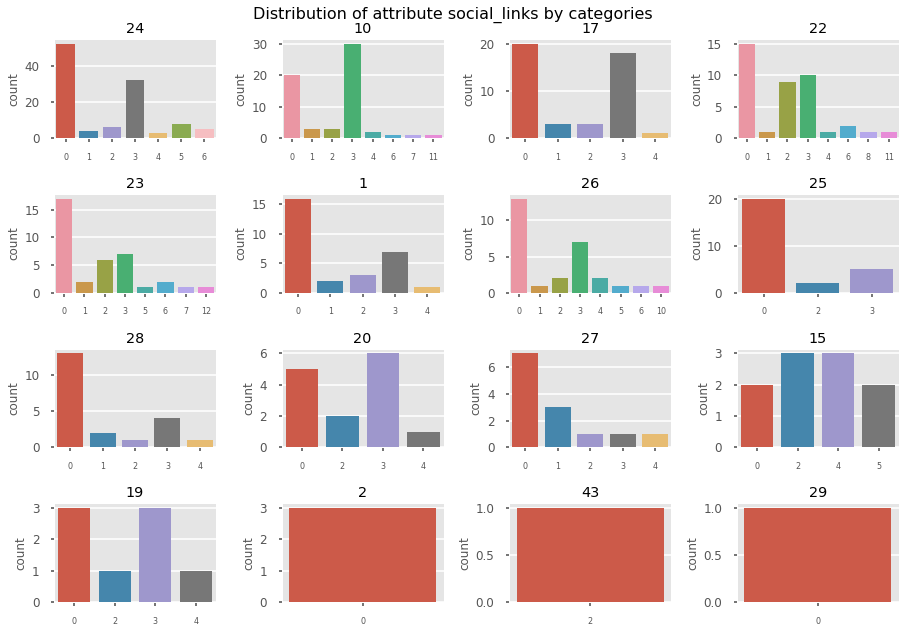

In [0]:
show_plots(df_cat, 'social_links', cats, ticks=True)

Links to social networks are present in some categories more often than in others - for example, for category 25, the presence of links is very little popular, and if they are already, then a maximum of 3. However, movies in category 10 usually have 3 links. It is worth paying attention to the number 3 - almost all charts have a noticeable peak for 3 links. These are probably links to the creator's account on three of the most popular social networking sites: Facebook, Instagram and Twitter.

## fb_links

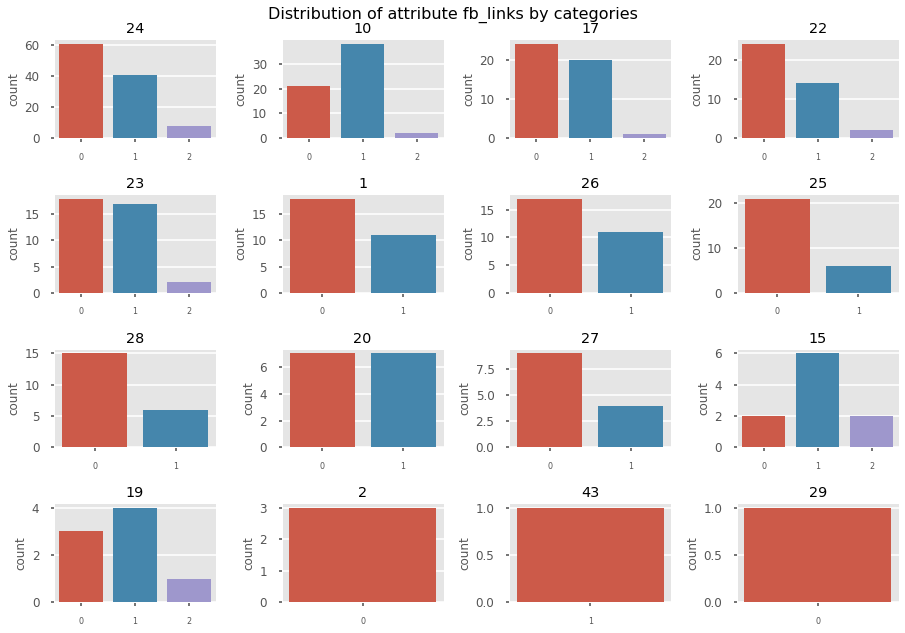

In [0]:
show_plots(df_cat, 'fb_links', cats, ticks=True)

## tt_links

In [0]:
show_plots(df_cat, 'tt_links', cats, ticks=True)

## ig_links

In [0]:
show_plots(df_cat, 'ig_links', cats, ticks=True)

It is worth comparing the distribution of the number of links to individual social networks within the category. In descriptions for category 22, you'll find links to Twitter and Instagram more often than Facebook. It happens that there are several times more Instagram links than links to other websites. For category 10, the distribution of data is similar for all 3 portals.



## desc_num_words

In [0]:
show_plots(df_cat, 'desc_num_words', cats, ticks=True, hist=True)

## brightness

In [0]:
show_plots(df_cat, 'brightness', cats, ticks=True, hist=True)

# Features

## Preeliminary work

In [0]:
df = data
df.trending_date = pd.to_datetime(df.trending_date)
df.publish_time = pd.to_datetime(df.publish_time)
df.trend_pub_date_diff = pd.to_timedelta(df.trend_pub_date_diff)
df.publish_date = pd.to_datetime(df.publish_date)

### Convert to numbers and remove unused

In [0]:
df.loc[:, 'category_id'] = pd.Categorical(df.category_id)
df.trending_date = df.trending_date.astype(int)
df.publish_time = df.publish_time.astype(int)
df.publish_date = df.publish_date.astype(int)
df.trend_pub_date_diff = df.trend_pub_date_diff.apply(lambda d: d.total_seconds())
df.channel_atr = pd.Categorical(df.channel_atr)
df = df.drop(columns=['channel_title', 'title', 'tags', 'thumbnail_link', 
                      'description', 'links'])

### Remove clearly irrelevant

In [0]:
df.head()

video_id        trending_date  ...       value  brightness
0  2kyS6SvSYSE  1510617600000000000  ...   85.561667   77.575833
1  lY_0mkYDZDU  1510617600000000000  ...   47.178056   42.662037
2  abGCYPCk294  1510617600000000000  ...   90.014259   69.746852
3  cccyOn99s4Y  1510617600000000000  ...   65.818426   58.986759
4  UFYCTJlayS4  1510617600000000000  ...  125.987130  114.002407

[5 rows x 103 columns]

### Missing value imputation

In [0]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.loc[missing_value_df.percent_missing != 0].iloc[:,[1]]

percent_missing
category_id               95.363700
most_common_tags           4.729259
uses_previous_tags        11.038810
dominant_color_r           7.878224
dominant_color_g           7.878224
dominant_color_b           7.878224
palette1_r                 7.878224
palette1_g                 7.878224
palette1_b                 7.878224
palette2_r                 7.878224
palette2_g                 7.878224
palette2_b                 7.878224
palette3_r                 7.878224
palette3_g                 7.878224
palette3_b                 7.878224
palette4_r                 7.878224
palette4_g                 7.878224
palette4_b                 7.878224
palette5_r                 7.878224
palette5_g                 7.878224
palette5_b                 7.878224
palette6_r                 7.878224
palette6_g                 7.878224
palette6_b                 7.878224
hue                        7.878224
saturation                 7.878224
value                      7.878224
brightness                 7.878224

In [0]:
num_cols = df.select_dtypes(['float64', 'int64']).columns
df_num = df.loc[:,num_cols]
df.loc[:,num_cols] = df_num.fillna(df_num.mean())

In [0]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.loc[missing_value_df.percent_missing != 0].iloc[:,[1]]

percent_missing
category_id          95.3637

### Remove clearly irrelevant

Object detections

In [0]:
df.loc[:,df.columns[41:78]].apply(lambda x: x.value_counts())

person     tie      tv     dog  ...  keyboard  motorcycle  fire hydrant  handbag
0   4019.0  8365.0  8481.0  8548.0  ...    8604.0      8604.0        8604.0   8604.0
1   3204.0   223.0   125.0    56.0  ...       2.0         2.0           2.0      2.0
2    974.0    18.0     NaN     2.0  ...       NaN         NaN           NaN      NaN
3    264.0     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN
4     82.0     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN
5     36.0     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN
6     17.0     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN
7      6.0     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN
8      4.0     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN
10     NaN     NaN     NaN     NaN  ...       NaN         NaN           NaN      NaN

[10 rows x 37 columns]

We will keep: **person**, **tie**, **tv**. Other ones are marginal.

In [0]:
df.drop(columns=df.columns[44:78], inplace=True)

We drop palette. It was decided it's already reflected in dominant color.

In [0]:
df.drop(columns=df.columns[47:-4], inplace=True)

### Feature scaling

All the features will be scaled/normalized by subtraction of the mean and division by standard deviation.

In [0]:
def normalize(column):
  std = column.std()
  mean = column.mean()
  return (column - mean)/std

to_normalize = list(df.select_dtypes(['float64', 'int64']).columns)
df[to_normalize] = df[to_normalize].apply(normalize)
df.head()

video_id  trending_date category_id  ...  saturation     value  brightness
0  2kyS6SvSYSE      -1.394077         NaN  ...   -0.470565 -0.374489   -0.138605
1  lY_0mkYDZDU      -1.394077         NaN  ...   -1.052028 -1.551762   -1.281048
2  abGCYPCk294      -1.394077         NaN  ...    0.804104 -0.237922   -0.394784
3  cccyOn99s4Y      -1.394077         NaN  ...   -0.041479 -0.980038   -0.746873
4  UFYCTJlayS4      -1.394077         NaN  ...   -0.887554  0.865410    1.053337

[5 rows x 69 columns]

## Data dump -  Data preprocessed (features still not selected)

In [0]:
LAST_DATA = 'data_preproc_final.csv'

In [0]:
df.to_csv(path.join(data_path, LAST_DATA), index=False)

In [0]:
df = pd.read_csv(path.join(data_path, LAST_DATA))

## Correlations

### Numeric features

In [0]:
corrs = df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corrs, annot=True)
plt.tick_params(axis='both', labeltop=True);
plt.xticks(rotation=90);

Attributes to be removed:
* `publish_date`:  
we have `publish_time`
* `trending_month`:  
  perfectly correlated with `publish_month`. It might be the same feature with a wrong name
* `publish_hour`, `publish_day`, `publish_month`:  
  we have `_cos`, `_sin` versions of those
* `brightness`:  
Strongly correlated (_0.95_) with `value`

#### `publish_date`

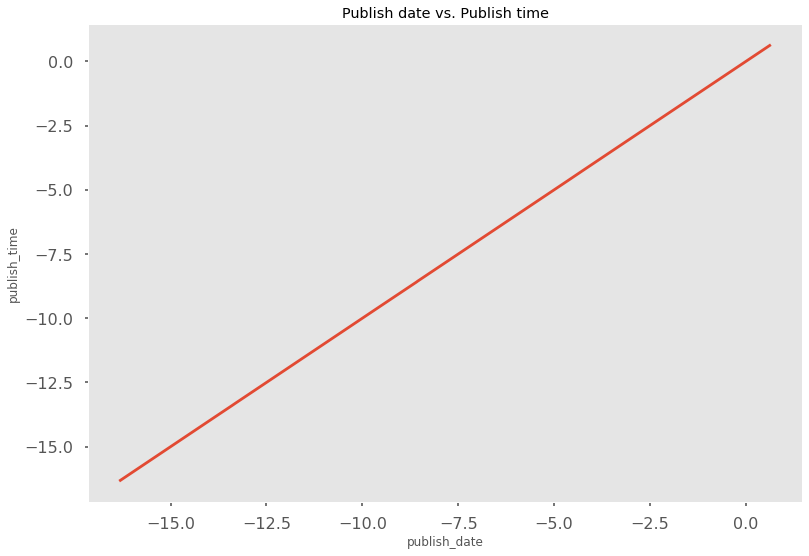

In [0]:
sns.lineplot(df.publish_date, df.publish_time);
plt.title('Publish date vs. Publish time');

We can clearly see the correlation on the plot. We can remove the feature.

In [0]:
df.drop(columns=['publish_date'], inplace=True)

#### `trending_month`

In [0]:
sns.lineplot(df.trending_month, df.publish_month)
plt.title('Trending month vs. Publish month');

As it was supposed it's the same feature, we can remove it.

In [0]:
df.drop(columns=['trending_month'], inplace=True)

#### `publish_hour`, `publish_day`, `publish_month`

We've already represented those features using `_sin` and `_cos` versions.

In [0]:
df.drop(columns=['publish_hour', 'publish_day', 'publish_month'], inplace=True)

#### `brightness`

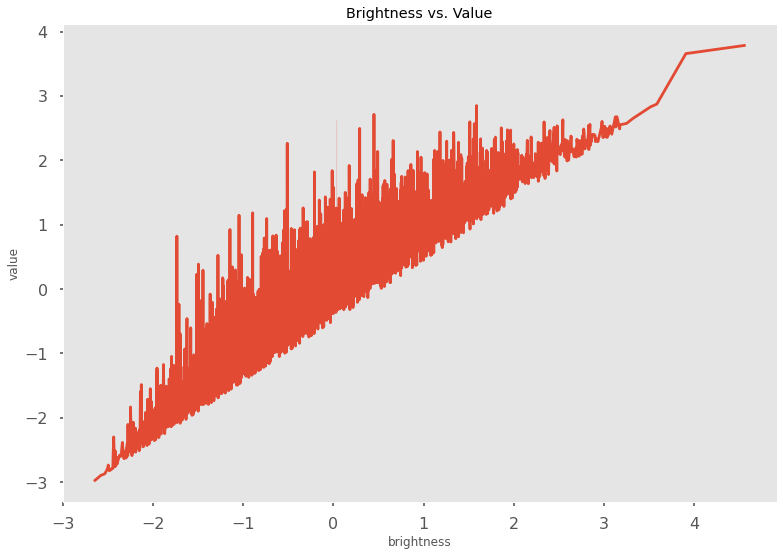

In [0]:
sns.lineplot(df.brightness, df.value);
plt.title('Brightness vs. Value');

A correlation can be seen, but there is also some nonlinear relation here. We will leave the feature.

Other features, despite sometimes beeing correlated, were left. They can still provide usefull information.

In [0]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                8606 non-null   object 
 1   trending_date           8606 non-null   float64
 2   category_id             399 non-null    float64
 3   publish_time            8606 non-null   float64
 4   views                   8606 non-null   float64
 5   likes                   8606 non-null   float64
 6   dislikes                8606 non-null   float64
 7   comment_count           8606 non-null   float64
 8   comments_disabled       8606 non-null   bool   
 9   ratings_disabled        8606 non-null   bool   
 10  video_error_or_removed  8606 non-null   bool   
 11  trending_no             8606 non-null   float64
 12  channel_atr             8606 non-null   object 
 13  publish_year            8606 non-null   float64
 14  publish_month           8606 non-null   

In [0]:
LAST_DATA = 'data_after_selection.csv'

In [0]:
df.to_csv(path.join(data_path, LAST_DATA), index=False)

# Filling the missing categories using semi-supervised learning

In [0]:
vid_cat = pd.read_csv(path.join(data_path,'trending_cat_map_final.csv'))
df = pd.read_csv(path.join(data_path, 'data_after_selection.csv'))
df.channel_atr = pd.Categorical(df.channel_atr)
df = df.set_index('video_id')
vid_cat = vid_cat.set_index('video_id')

df.shape

(8606, 50)

We work with:
 * 8k examples
 * 50 features
 

In [0]:
df_cat = df.loc[df.category_id.notna()]
print("%.2f%% of examples have category" % (len(df_cat)/len(df) * 100))

4.64% of examples have category


In [0]:
subset = df.index.intersection(vid_cat.index)
df.loc[subset, ['category_id']] = vid_cat.loc[subset].category_id

df_cat = df.loc[df.category_id.notna()]
print("%.2f%% of examples have category" % (len(df_cat)/len(df) * 100))
df.category_id = pd.Categorical(df.category_id)

25.15% of examples have category


Apparently we've just managed to retrieve **1765** missing categories.

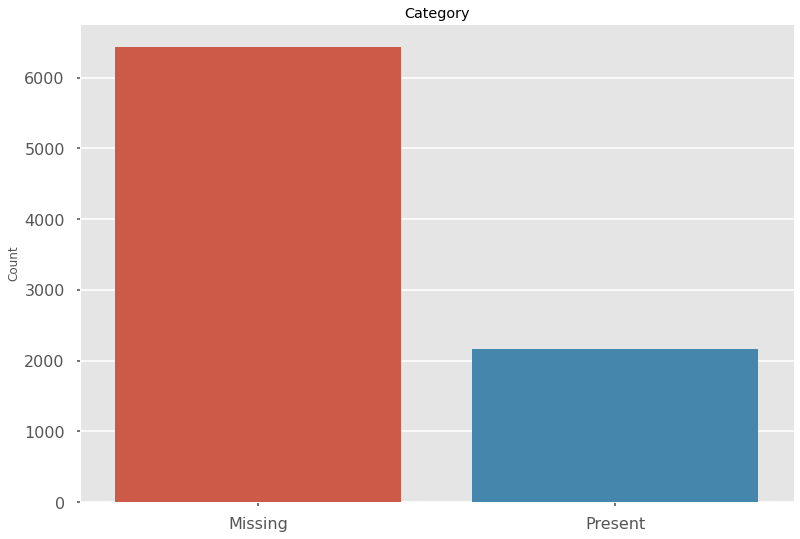

In [0]:
sns.barplot(['Missing', 'Present'], 
            [df.category_id.isna().sum(), df.category_id.notna().sum()]);
plt.title('Category');
plt.ylabel('Count');

In [0]:
cat_map = pd.read_csv(path.join(data_path, 'categories_names.csv'), sep=';')
cat_map = cat_map.set_index('id')
df.category_id = df.category_id.astype('float64')
df.loc[df.category_id.notna(), 'category_id'] = df.loc[df.category_id.notna()].category_id.apply(lambda x: cat_map.loc[x, 'name'])
df.category_id = pd.Categorical(df.category_id)

In [0]:
def show_values_on_bars(axs, h_v="v", space=0.4, fontsize=15):
  def _none_to_zero(val):
    return val if not(np.isnan(val)) else 0

  def _show_on_single_plot(ax):
    if h_v == "v":
      for p in ax.patches:
        _x = _none_to_zero(p.get_x() + p.get_width() / 2)
        _y = _none_to_zero(p.get_y() + p.get_height())
        value = int(_none_to_zero(p.get_height()))
        ax.text(_x, _y, value, ha="center", fontsize=fontsize) 
    elif h_v == "h":
      for p in ax.patches:
        _x = _none_to_zero(p.get_x() + p.get_width() + float(space))
        _y = _none_to_zero(p.get_y() + p.get_height())
        value = int(_none_to_zero(p.get_width()))
        ax.text(_x, _y, value, ha="left", fontsize=fontsize)

  if isinstance(axs, np.ndarray):
    for idx, ax in np.ndenumerate(axs):
        _show_on_single_plot(ax)
  else:
    _show_on_single_plot(axs)

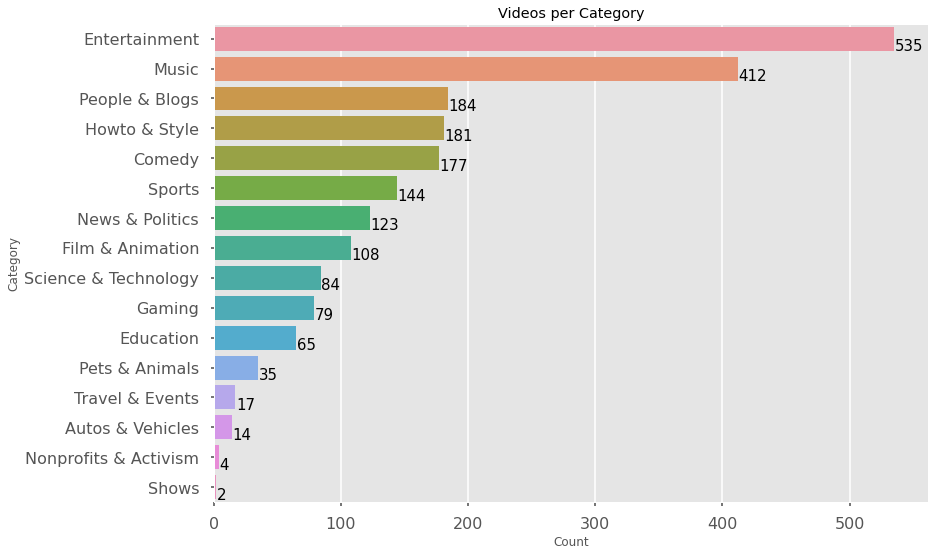

In [0]:
ax = sns.countplot(y='category_id', 
              data=df, 
              orient='v',
              order=df.category_id.value_counts().index);
show_values_on_bars(ax, h_v='h')
plt.ylabel('Category')
plt.xlabel('Count')
plt.title('Videos per Category');

The following categories will be merged:
* **Shows** to **Entertainmnent**
* **Nonprofits & Activism** to **News & Politics**

In [0]:
df.loc[df.category_id == 'Shows', 'category_id'] = 'Entertainment'
df.loc[df.category_id == 'Nonprofits & Activism', 'category_id'] = 'News & Politics'
df.category_id = df.category_id.cat.remove_unused_categories()

## EDA for categories

## Test-Train split

We need to convert categorical features to **dummies**

In [0]:
df_cat = df[df.category_id.notna()]
df_cat.drop(columns=['category_id'], inplace=True)

categorical_columns = df_cat.select_dtypes(include=['category']).columns
categorical = pd.get_dummies(df_cat.loc[:,categorical_columns])

df_cat.drop(columns=categorical_columns, inplace=True)
df_cat = pd.concat([df_cat, categorical], axis=1)

In [0]:
X = df_cat
y = df[df.category_id.notna()].loc[:,'category_id']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.4)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                  stratify=y_test,
                                                  test_size=0.5)

In [0]:
def compare_cat_dist(y_train, y_test, y_valid=None, order=None):
  y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

  if not(y_valid is None):
    y_valid = y_valid.to_numpy()

  plt.figure(figsize=(25,15))

  df_train = pd.DataFrame(y_train, columns=['category'])
  df_train['data_set'] = 'train'

  df_test = pd.DataFrame(y_test, columns=['category'])
  df_test['data_set'] = 'test'

  df_valid = None
  if np.any(y_valid != None):
    df_valid = pd.DataFrame(y_valid, columns=['category'])
    df_valid['data_set'] = 'valid'

  df_y = df_train.append(df_test)
  if np.any(df_valid != None):
    df_y = df_y.append(df_valid)

  ax = sns.countplot(data=df_y, y='category', hue='data_set', order=order, orient='h')
  ax.set_title('Category distribution');
  show_values_on_bars(ax, h_v='h');

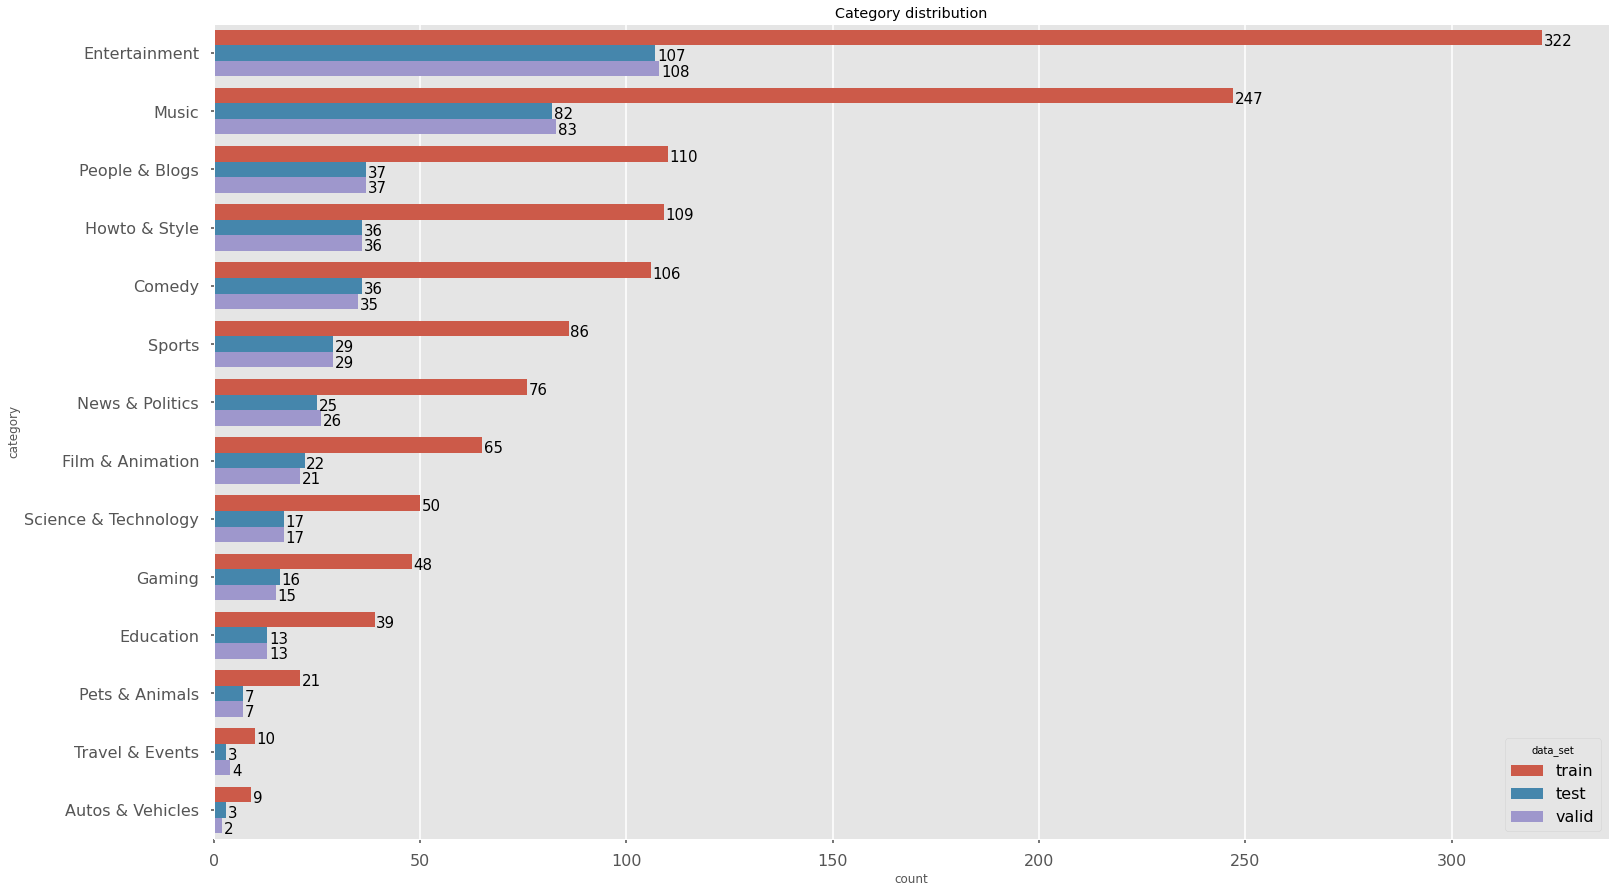

In [0]:
compare_cat_dist(y_train, y_test, y_val, order=df.category_id.value_counts().index)

## Imbalanced learning
Simple **Logistic regression** will be used as a reference classifier

In [0]:
class ClfScorer:
  
  SINGLE_SCORE_AVG = 'weighted avg'
  SINGLE_SCORE_MEASURE = 'f1-score'
  BENCHMARK_CLF = LogisticRegression(max_iter=1000)

  def __init__(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test
  
  def score_report(self, clf):
    print(type(clf))
    y_pred = clf.predict(self.X_test)
    report = classification_report(
        self.y_test, 
        y_pred,
        zero_division=0)
    print(report)
    
  def score_number(self, clf, ret=False, X=None, y=None):
    if X is None or y is None:
      X, y = self.X_test, self.y_test
    if not(ret): 
      print(type(clf))
    y_pred = clf.predict(X)
    report = classification_report(
        y,
        y_pred,
        zero_division=0,
        output_dict=True
    )
    score = report[self.SINGLE_SCORE_AVG][self.SINGLE_SCORE_MEASURE]
    if not(ret): 
      print('%s %s: %.2f' % (self.SINGLE_SCORE_AVG, 
                           self.SINGLE_SCORE_MEASURE, 
                           score))
    return score

  def train_and_score(self, X_train, y_train, clf=None):
    clf = clf if clf != None else self.BENCHMARK_CLF
    clf = self.BENCHMARK_CLF.fit(X_train, y_train)
    self.score_number(clf)

In [0]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

                      precision    recall  f1-score   support

    Autos & Vehicles       0.00      0.00      0.00         3
              Comedy       0.29      0.19      0.23        36
           Education       0.12      0.08      0.10        13
       Entertainment       0.36      0.57      0.44       108
    Film & Animation       0.00      0.00      0.00        21
              Gaming       0.20      0.07      0.10        15
       Howto & Style       0.48      0.42      0.45        36
               Music       0.52      0.62      0.57        82
     News & Politics       0.28      0.32      0.30        25
      People & Blogs       0.14      0.08      0.10        37
      Pets & Animals       0.00      0.00      0.00         7
Science & Technology       0.12      0.12      0.12        17
              Sports       0.68      0.45      0.54        29
     Travel & Events       0.00      0.00      0.00         4

            accuracy                           0.38       433
      

### SMOTE

In order to perform **SMOTE** first all the minority classes are randomly oversampled to 6.

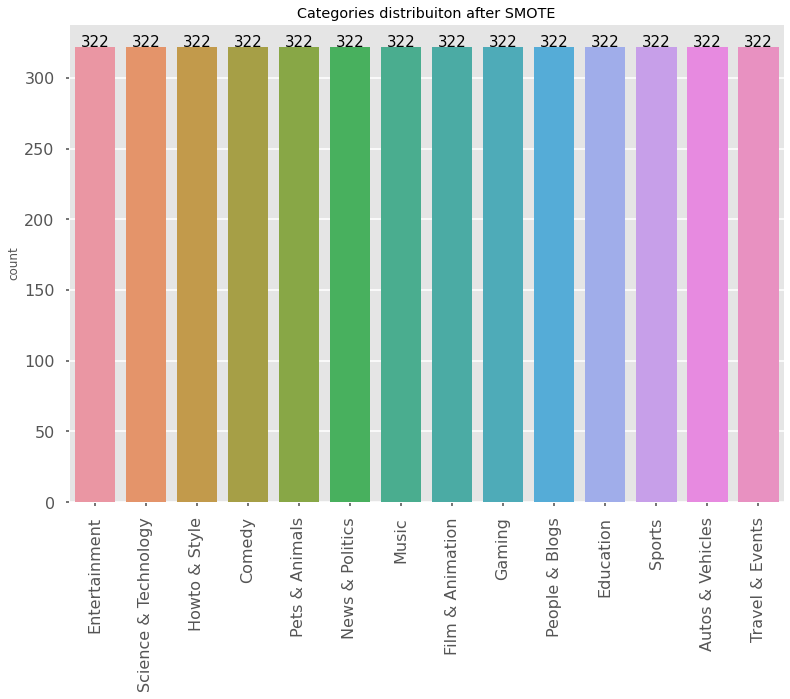

In [0]:
X_res, y_res = SMOTE().fit_resample(X_train, y_train);
ax = sns.countplot(y_res);
show_values_on_bars(ax);
ax.set_title('Categories distribuiton after SMOTE');
plt.xticks(rotation=90);

In [0]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_res, y_res)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

                      precision    recall  f1-score   support

    Autos & Vehicles       0.04      0.33      0.07         3
              Comedy       0.24      0.28      0.26        36
           Education       0.11      0.15      0.13        13
       Entertainment       0.63      0.24      0.35       108
    Film & Animation       0.00      0.00      0.00        21
              Gaming       0.14      0.27      0.18        15
       Howto & Style       0.48      0.39      0.43        36
               Music       0.72      0.46      0.56        82
     News & Politics       0.24      0.36      0.29        25
      People & Blogs       0.16      0.14      0.14        37
      Pets & Animals       0.04      0.14      0.06         7
Science & Technology       0.11      0.24      0.15        17
              Sports       0.61      0.59      0.60        29
     Travel & Events       0.00      0.00      0.00         4

            accuracy                           0.30       433
      

**SMOTE** deteriorated the score by **5%**, so we will not use it.

## Semi-Supervised Learning

The first _semi-supervised_ method that will be aplied is **self-learning**.
The method was chosen for the following purposes:
 * Ease of implementation
 * Low number of _hyperparameters_
 * Classifier independence

Because of very high **feature space** it was decided to use relatively simple classifier - **Logistic Regression**. In order to combat overfitting which is surely to happen **l2 regularization** will be applied.

**Self learning** will be applied in the following manner:
* Every iteration some of the most sure predictions by the terms of **softmax outputs** and determined by the **threshold** will be added to the training set
* Meanwhile the **validation** score will be measured. 
* The iterations will be executed until the _validation score_ drops. 
* The best saved classifier will be returned. 

The two _hyperparameters_:
* _l2_ regularization **C**
* _self learning's_ **threshold** 
will be crossvalidated on the _validation set_.

After selecting the best set of hyperparameters the _validation_ and _training_ sets will be merged and the final classifier will be trained and the performance will be measured on the _test_ set.


### Self-Learning

In [0]:
class SelfLearning:
  def __init__(self, clf, X, y, unlabeled, threshold=0.99, verbose=True,
               scorer=None, score=False, max_iter=None, max_decreasing=3):
    self.clf = clf
    self.X = X.copy()
    self.y = y.copy()
    self.unlabeled = unlabeled.copy()
    self.threshold = threshold
    self.new_confident = True
    self.verbose = verbose
    self.scorer = scorer
    self.score = scorer != None
    self.scores = {
        'valid': [],
        'train': []
    }
    self.max_iter = max_iter
    self.n_iter = 0
    self.max_decreasing = max_decreasing
    self._n_decreased = 0
    self._best_clf = None

    if score and scorer == None:
      raise RuntimeError("Set scorer")

  def self_learn(self, n_iter=None):
    self._log('Self learning with %s' % str(type(clf)))
    self._fit()
    self._best_clf = deepcopy(self.clf)
    self._log()
    while self.new_confident:
      self.n_iter += 1
      self._log('Iteration %3d:' % self.n_iter, end=' ')
      self._fit()
      self._add_confident()
      self._log('', end='\n')
      if self.max_iter == self.n_iter:
        break
      if self._reached_max_dec():
        break
    return self._best_clf

  def _reached_max_dec(self):
    return self.max_decreasing and self._n_decreased >= self.max_decreasing

  def _fit(self):
    self.clf.fit(self.X, self.y)
    self._add_score()

  def _log(self, msg='', end='\n'):
    if self.verbose:
      print(msg, end=end)

  def _add_score(self):
    if not(self.score):
      return
    valid_metric = self.scorer.score_number(self.clf, ret=True)
    if len(self.scores['valid']) > 0 and self.scores['valid'][-1] > valid_metric:
      self._n_decreased +=1
    else:
      self._n_decreased = 0
      self._best_clf = deepcopy(self.clf) 
    self.scores['valid'].append(valid_metric)
    train_metric = self.scorer.score_number(self.clf, 
                                            ret=True, 
                                            X=self.X, 
                                            y=self.y)
    self.scores['train'].append(train_metric)
    self._log('train_score: %.2f val_score: %.2f' 
              % (train_metric, valid_metric), end= ' ')

  def _add_confident(self):
    probs = self.clf.predict_proba(self.unlabeled)
    index = np.argmax(probs, axis=1)
    rows = np.choose(index, probs.T) > self.threshold
    self.new_confident = np.any(rows)
    if not(self.new_confident):
      self._log('learning finished')
      return
    if self.verbose: print('new examples: %3d' % sum(rows), end=' ')
    X_new = self.unlabeled[rows,:]
    y_new = self.clf.predict(self.unlabeled)[rows]
    self.X = np.append(self.X, X_new, axis=0)
    self.y = np.append(self.y, y_new)
    self.unlabeled = np.delete(self.unlabeled, np.where(rows), axis=0) 
  
  def plot_scores(self, title=''):
    plt.plot(self.scores['train']);
    plt.plot(self.scores['valid'])
    plt.legend(['train', 'valid'])
    plt.xlabel('Iteration');
    plt.ylabel('F1-Score');
    plt.title(title);

#### Logistic Regression

In [0]:
unlabeled = df.loc[df.category_id.isna()].drop(columns=['category_id'])

categorical_columns = unlabeled.select_dtypes(include=['category']).columns
categorical = pd.get_dummies(unlabeled.loc[:,categorical_columns])

unlabeled.drop(columns=categorical_columns, inplace=True)
unlabeled = pd.concat([unlabeled, categorical], axis=1)
unlabeled = unlabeled.to_numpy()

scorer = ClfScorer(X_val, y_val)

parameters = {
  'C': 10.0**(-np.arange(0, 6)),
  'threshold': np.arange(0.6, 1, 0.05)
}
grid = ParameterGrid(parameters)
best_params = {'score': 0}

for params in grid:
  clf = LogisticRegression(max_iter=1000, 
                          n_jobs=cpu_count(), 
                          warm_start=True,
                          C=params['C'])
  
  selfLearning = SelfLearning(clf, 
                              X_train, 
                              y_train, 
                              unlabeled, 
                              scorer=scorer,
                              threshold=params['threshold'],
                              max_decreasing=1,
                              verbose=True)
  clf = selfLearning.self_learn()
  score = scorer.score_number(clf, ret=True)
  if score > best_params['score']:
    best_params['score'] = score
    best_params['params'] = params
    print('Best params: ', best_params)
  else:
    print(params, score)

Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 0.46 val_score: 0.35 
Iteration   1: train_score: 0.46 val_score: 0.35 new examples: 1294 
Iteration   2: train_score: 0.72 val_score: 0.34 new examples: 686 
Best params:  {'score': 0.347416140701052, 'params': {'C': 1.0, 'threshold': 0.6}}
Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 0.46 val_score: 0.35 
Iteration   1: train_score: 0.46 val_score: 0.35 new examples: 1063 
Iteration   2: train_score: 0.70 val_score: 0.35 new examples: 555 
Iteration   3: train_score: 0.75 val_score: 0.35 new examples: 336 
Iteration   4: train_score: 0.77 val_score: 0.35 new examples: 273 
Best params:  {'score': 0.3502513748164254, 'params': {'C': 1.0, 'threshold': 0.65}}
Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 0.46 val_score: 0.35 
Iteration   1: train_score: 0.46 val_score: 0.35 new examples: 834 
Iteration   

In [0]:
print(best_params)

{'score': 0.3502513748164254, 'params': {'C': 1.0, 'threshold': 0.65}}


Self learning with logistic regression achieved the average weighted f1 score of 52% with _C = 1.0_ and _threshold = 0.65_.  
At this stage _train_ and _validation_ sets will be merged and the whole pipeline will be applied to the merged set


In [0]:
X_all = np.append(X_train, X_val, axis=0)
y_all = np.append(y_train, y_val)

In [0]:
scorer = ClfScorer(X_test, y_test)

clf = LogisticRegression(max_iter=1000, 
                        n_jobs=cpu_count(), 
                        warm_start=True,
                        C=1.0)

selfLearning = SelfLearning(clf, 
                            X_all, 
                            y_all, 
                            unlabeled, 
                            scorer=scorer,
                            threshold=0.9,
                            max_decreasing=1,
                            verbose=True)
clf = selfLearning.self_learn()

Self learning with <class 'sklearn.linear_model._logistic.LogisticRegression'>
train_score: 0.45 val_score: 0.38 
Iteration   1: train_score: 0.45 val_score: 0.38 new examples: 200 
Iteration   2: train_score: 0.51 val_score: 0.38 new examples:  78 


In [0]:
print('Test set:')
test_scorer = ClfScorer(X_test, y_test)
test_scorer.score_number(clf)
print('Train set:')
train_scorer = ClfScorer(X_all, y_all)
train_scorer.score_number(clf);

Test set:
<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.38
Train set:
<class 'sklearn.linear_model._logistic.LogisticRegression'>
weighted avg f1-score: 0.45


We finally achieved _weighted averaged f1-score_ of **38%** on the _test set_.

#### Neural Network

In [0]:
from sklearn.neural_network import MLPClassifier

unlabeled = df.loc[df.category_id.isna()].drop(columns=['category_id'])

categorical_columns = unlabeled.select_dtypes(include=['category']).columns
categorical = pd.get_dummies(unlabeled.loc[:,categorical_columns])

unlabeled.drop(columns=categorical_columns, inplace=True)
unlabeled = pd.concat([unlabeled, categorical], axis=1)
unlabeled = unlabeled.to_numpy()

scorer = ClfScorer(X_val, y_val)

parameters = {
  'lr': [0.001, 0.01, 0.1, 0.15, 0.2],
  'alpha': 10.0**np.arange(-4,1),
  'threshold': np.arange(0.7, 1, 0.05)
}
grid = ParameterGrid(parameters)
best_params = {'score': 0}

for params in grid:
  clf = MLPClassifier(hidden_layer_sizes=(320),
                    solver='adam',
                    learning_rate_init=params['lr'],
                    activation='logistic',
                    alpha=params['alpha'],
                    max_iter=10)
  
  selfLearning = SelfLearning(clf, 
                              X_train, 
                              y_train, 
                              unlabeled, 
                              scorer=scorer,
                              threshold=params['threshold'],
                              max_decreasing=1,
                              verbose=True)
  clf = selfLearning.self_learn()
  score = scorer.score_number(clf, ret=True)
  if score > best_params['score']:
    best_params['score'] = score
    best_params['params'] = params
    print('Best params: ', best_params)
  else:
    print(params, score)

Self learning with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
train_score: 0.23 val_score: 0.23 
Iteration   1: train_score: 0.22 val_score: 0.22 new examples:  27 
Best params:  {'score': 0.2291814678289628, 'params': {'alpha': 0.0001, 'lr': 0.001, 'threshold': 0.7}}
Self learning with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
train_score: 0.23 val_score: 0.23 
Iteration   1: train_score: 0.22 val_score: 0.22 new examples:  13 
{'alpha': 0.0001, 'lr': 0.001, 'threshold': 0.75} 0.22531376351897633
Self learning with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
train_score: 0.23 val_score: 0.23 
Iteration   1: train_score: 0.22 val_score: 0.22 new examples:   6 
{'alpha': 0.0001, 'lr': 0.001, 'threshold': 0.8} 0.22841129366155433
Self learning with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
train_score: 0.22 val_score: 0.21 
Iteration   1: train_score: 0.24 val_score: 0.23 new exam

In [0]:
print(best_params)

{'score': 0.4205022931229638, 'params': {'alpha': 0.0001, 'lr': 0.1, 'threshold': 0.7}}


In [0]:
scorer = ClfScorer(X_test, y_test)

clf = MLPClassifier(hidden_layer_sizes=(320),
                    solver='adam',
                    learning_rate_init=0.1,
                    activation='logistic',
                    alpha=0.001,
                    max_iter=10)

selfLearning = SelfLearning(clf, 
                            X_all, 
                            y_all, 
                            unlabeled, 
                            scorer=scorer,
                            threshold=0.8,
                            max_decreasing=1,
                            verbose=True)
clf = selfLearning.self_learn()

Self learning with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
train_score: 0.63 val_score: 0.39 
Iteration   1: train_score: 0.66 val_score: 0.39 new examples: 1391 
Iteration   2: train_score: 0.90 val_score: 0.42 new examples: 910 
Iteration   3: train_score: 0.89 val_score: 0.40 new examples: 804 


In [0]:
print('Test set:')
test_scorer = ClfScorer(X_test, y_test)
test_scorer.score_number(clf)
print('Train set:')
train_scorer = ClfScorer(X_all, y_all)
train_scorer.score_number(clf);

Test set:
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
weighted avg f1-score: 0.42
Train set:
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
weighted avg f1-score: 0.83


Eventually, we achieved **42%** on the test set for Self Learning with Neural Network.

### Label Spreading

The second semi-supervised method is **Label Spreading**. This choice was motivated by:
 * fast training
 * few hyperparameters to set
 * ready-to-use implementation in *scikit* 

Label Spreading is an graph algotihm where a node’s labels propagate to all nodes according to their proximity. *LabelSpreading* minimizes a loss function that has regularization properties. The algorithm iterates on a modified version of the original graph and normalizes the edge weights by computing the normalized graph Laplacian matrix. - by [scikit](https://scikit-learn.org/stable/modules/label_propagation.html#label-propagation)

Parameters:
 * gamma - parameter for *rbf* kernel
 * max_iter - maximum number of iterations allowed
 * alpha - clamping factor - specifies the relative amount that an instance should adopt the information from its neighbors as opposed to its initial label

*Scikit* also allows to choose kernel - *RBF* or *KNN*. After performing few preparatory tests, it turned out that *KNN* gives much worse results and is much slower, so we chose to test further only *RBF*.



In [0]:
class LabelProp:
  def __init__(self, X_train, y_train, unlabeled):
    self.X_train = X_train
    self.y_train = y_train
    self.unlabeled = unlabeled.copy()
  
  def train(self, gamma, max_iter, alpha):
    self.model = LabelSpreading(gamma=gamma, max_iter=max_iter, alpha=alpha)
    self.model.fit(self.X_train, self.y_train)

  def predict(self, X_test):
    if self.model is None:
      print("ERROR. No model")
    else:
      return self.model.predict(X_test)

We will test some parameters with grid search and choose parameters, which give best results.


In [0]:
unlabeled = df[df.category_id.isna()]

categorical_columns = unlabeled.select_dtypes(include=['category']).columns
categorical = pd.get_dummies(unlabeled.loc[:,categorical_columns])
unlabeled.drop(columns=categorical_columns, inplace=True)
unlabeled = pd.concat([unlabeled, categorical], axis=1)
unlabeled = unlabeled.to_numpy()

parameters = {
  'gamma': np.arange(0.1, 0.75, 0.05),
  'max_iter': [5, 10, 30],
  'alpha': np.arange(0.1, 0.5, 0.1)
}
grid = ParameterGrid(parameters)
for params in grid:
  labelProp = LabelProp(X_train, y_train, unlabeled)
  labelProp.train(gamma=params['gamma'], max_iter=params['max_iter'], alpha=params['alpha'])
  y_pred = labelProp.predict(X_val)
  print(" gamma: ", params['gamma'], " max_iter: ", params['max_iter'], " alpha: ", params['alpha'], 
        " score: ", f1_score(y_val, y_pred, average='weighted'))

 gamma:  0.1  max_iter:  5  alpha:  0.1  score:  0.24883985016779472
 gamma:  0.1  max_iter:  10  alpha:  0.1  score:  0.24883985016779472
 gamma:  0.1  max_iter:  30  alpha:  0.1  score:  0.24883985016779472
 gamma:  0.15000000000000002  max_iter:  5  alpha:  0.1  score:  0.2872053021210753
 gamma:  0.15000000000000002  max_iter:  10  alpha:  0.1  score:  0.2872053021210753
 gamma:  0.15000000000000002  max_iter:  30  alpha:  0.1  score:  0.2872053021210753
 gamma:  0.20000000000000004  max_iter:  5  alpha:  0.1  score:  0.3327386309035497
 gamma:  0.20000000000000004  max_iter:  10  alpha:  0.1  score:  0.3327386309035497
 gamma:  0.20000000000000004  max_iter:  30  alpha:  0.1  score:  0.3327386309035497
 gamma:  0.25000000000000006  max_iter:  5  alpha:  0.1  score:  0.3283856564159659
 gamma:  0.25000000000000006  max_iter:  10  alpha:  0.1  score:  0.3283856564159659
 gamma:  0.25000000000000006  max_iter:  30  alpha:  0.1  score:  0.3283856564159659
 gamma:  0.30000000000000004 

We will train classifier with best parameters on the training + validation set and then test it on the test set.

In [0]:
labelProp = LabelProp(X_all, y_all, df.loc[df.category_id.isna()])
labelProp.train(gamma=0.3, max_iter=5, alpha=0.1)

In [0]:
print('Test set:')
y_test_pred = labelProp.predict(X_test)
print(f1_score(y_test, y_test_pred, average='weighted'))
print('Train set:')
y_train_pred = labelProp.predict(X_all)
print(f1_score(y_all, y_train_pred, average='weighted'));

Test set:
0.3270051624417399
Train set:
1.0


As we can see, in spite of regularization included in *LabelSpreading*, the classifier is strongly overfitted. Result achieved on the test set is equal to ~**33%**

### Method choice

The first method - **Self Learning** obtained better results for the test set - 42% in comparison to **Label Spreading** - only 33%. 

Label Spreading was much faster than Self Learning, however. 

Both methods use regularization, but still problem with overfitting is present. Self learning can be used with different classifiers, therefore it is more flexible.

With main criterion, which is weighted score on F1 metric, we choose to use **Self Learning with Neural Network** with **Logistic Regression** in further considerations.

### Verification with ground truth

We will check the classifier on the ground trurh data acquired by YouTube Data API

In [0]:
ground_truth = pd.read_csv(path.join(data_path, 'categories_gt.csv'), sep=";")

In [0]:
df_ = df.drop(columns=['category_id'])

categorical_columns = df_.select_dtypes(include=['category']).columns
categorical = pd.get_dummies(df_.loc[:,categorical_columns])

df_.drop(columns=categorical_columns, inplace=True)
df_ = pd.concat([df_, categorical], axis=1)

In [0]:
unlabeled = df.loc[df.category_id.isna()].drop(columns=['category_id'])

categorical_columns = unlabeled.select_dtypes(include=['category']).columns
categorical = pd.get_dummies(unlabeled.loc[:,categorical_columns])

unlabeled.drop(columns=categorical_columns, inplace=True)
unlabeled = pd.concat([unlabeled, categorical], axis=1)
unlabeled = unlabeled.to_numpy()

scorer = ClfScorer(X_test, y_test)

clf = MLPClassifier(hidden_layer_sizes=(320),
                    solver='adam',
                    learning_rate_init=0.1,
                    activation='logistic',
                    alpha=0.001,
                    max_iter=10)

selfLearning = SelfLearning(clf, 
                            X_all, 
                            y_all, 
                            unlabeled, 
                            scorer=scorer,
                            threshold=0.8,
                            max_decreasing=1,
                            verbose=True)
clf = selfLearning.self_learn()

Self learning with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
train_score: 0.63 val_score: 0.38 
Iteration   1: train_score: 0.64 val_score: 0.40 new examples: 1367 
Iteration   2: train_score: 0.87 val_score: 0.39 new examples: 1087 


Some videos in ground truth are missing cattegory. We will remove them.

In [0]:
gt = ground_truth.loc[ground_truth.category_id.notna()]
gt.loc[gt.category_id.notna(), 'category_id'] = gt.loc[gt.category_id.notna()].category_id.apply(lambda x: cat_map.loc[x, 'name'])
gt = gt.set_index('video_id')
df_ = df_.reindex(gt.index)

In [0]:
print('Whole dataset:')
train_scorer = ClfScorer(df_, gt)
train_scorer.score_number(clf);

Whole dataset:
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
weighted avg f1-score: 0.46


In [0]:
df_['category'] = clf.predict(df_)

In [0]:
df_.to_csv(os.path.join(data_path, "checkpoint4_final.csv"), sep=';')

We've achieved a _Weighted F1-score_ equal to **46%**.  
The value is higher than the one we reported on the _test set_: **42%**.

In [0]:
from sklearn.metrics import multilabel_confusion_matrix

predicted = pd.read_csv(os.path.join(data_path, "checkpoint4_final.csv"), sep=';')
predicted = predicted[['video_id', 'category']]
ground_truth = pd.read_csv(path.join(data_path, 'categories_gt.csv'), sep=";")

cat_map = pd.read_csv(path.join(data_path, 'categories_names.csv'), sep=';')
cat_map = cat_map.set_index('id')
#df.category_id = df.category_id.astype('float64')
ground_truth.loc[ground_truth.category_id.notna(), 'category_id'] = ground_truth.loc[ground_truth.category_id.notna()].category_id.apply(lambda x: cat_map.loc[x, 'name'])

In [0]:
conf_matrices = multilabel_confusion_matrix(ground_truth['category_id'], predicted['category'], labels=cat_map['name'])

In [40]:
cat_map

name
id                       
1        Film & Animation
2        Autos & Vehicles
10                  Music
15         Pets & Animals
17                 Sports
19        Travel & Events
20                 Gaming
22         People & Blogs
23                 Comedy
25        News & Politics
26          Howto & Style
27              Education
28   Science & Technology
43                  Shows
24          Entertainment
29  Nonprofits & Activism

In [47]:
print(cat_map.iloc[14]['name'], '\n', conf_matrices[14], '\n')
print(cat_map.iloc[2]['name'], '\n', conf_matrices[2], '\n')
print(cat_map.iloc[3]['name'], '\n', conf_matrices[3], '\n')
print(cat_map.iloc[5]['name'], '\n', conf_matrices[5])

Entertainment 
 [[4284 1650]
 [ 677 1321]] 

Music 
 [[5750  875]
 [ 382  925]] 

Pets & Animals 
 [[7767   19]
 [ 124   22]] 

Travel & Events 
 [[7869    0]
 [  57    6]]


As we can see, the prediction is biased towards majority classes - it makes more false positive than false negative misktakes, while for minority classes the behaviour is reversed.

# Non-trending data acquisition

Due to the fact, that YouTube Data API is not faultless, we acquired non-trending data in the following way:
 * considered publish time: 14.11.2017 - 14.06.2018
 * the timespace was divided into 7-days pieces
 * relevance language set to English
 * request for most popular videos (argument: order='viewCount) made for each timepiece and every category present in trending data

Following quieries were made to obtain needed data:

```
# to obtain video ids
youtube.search().list(part='snippet',
                      maxResults=50,
                      publishedAfter=start_times[i],
                      publishedBefore=end_times[i],
                      order='viewCount',
                      type='video',
                      relevanceLanguage='en',
                      videoCategoryId=cat_id
                      pageToken=page_token).execute()
```

```
# to obtain video statistics
youtube.videos().list(part='statistics', id=video_id).execute()
```

In [0]:
df = pd.read_csv(path.join(data_path, 'data_checkpoint5.csv'), sep=";")

In [0]:
df.head()

videoId               publishedAt  ...  dislikes commentCount
0  TyHvyGVs42U  2017-11-17T05:00:01.000Z  ...  663220.0     327170.0
1  YXSFMV8JOF4  2017-11-17T13:00:03.000Z  ...   83443.0      20456.0
2  T4dusvA1fi0  2017-11-18T12:00:01.000Z  ...  256359.0       1845.0
3  6uJf2IT2Zh8  2017-11-17T09:00:03.000Z  ...   53720.0     122379.0
4  UuCq8mtK8J4  2017-11-16T05:00:01.000Z  ...   32207.0      22809.0

[5 rows x 13 columns]

In [0]:
len(df)

58876

Firstly, we will filter out videos, which appeared on trending lists

In [0]:
df_trending = pd.read_hdf(path.join(data_path, 'data_c12.hdf'))
trending_ids = set(df_trending['video_id'])

In [0]:
df = df[~df.videoId.isin(trending_ids)]

In [0]:
len(df)

57591

Next, we will make sure that data fits in time bounds.

In [0]:
import datetime
import pytz
df['publishedAt'] = pd.to_datetime(df.publishedAt)
df = df[df.publishedAt < datetime.datetime(2018, 6, 15, tzinfo=pytz.utc) ]

In [0]:
len(df)

56594

We will delete incomplete data - rows with empty views count

In [0]:
df = df[~df.views.isna()]

In [0]:
len(df)

55734

The next step is deleting rows with views count lower than lower bound of views count in trending data

In [0]:
df = df[df.views>=min(list(df_trending['views']))]

In [0]:
len(df)

53973

YouTube Data API is not ideal. In spite of getting only videos with relevance language set to English, there are a lot of videos, which actually don't have any word in title or description written in Eglish. We will filter out those films based on language detected in title

In [0]:
from langdetect import lang_detect_exception
def detect_lang(text):
  try:
    lang = langdetect.detect(text)
  except:
    lang = None
  return lang

In [0]:
df['language'] = df.apply(lambda row: detect_lang(row['title']), axis=1)

In [0]:
df[df.language!='en'].head(5)

videoId               publishedAt  ... commentCount language
1   YXSFMV8JOF4 2017-11-17 13:00:03+00:00  ...      20456.0       it
2   T4dusvA1fi0 2017-11-18 12:00:01+00:00  ...       1845.0       es
6   xb06CqeSgCQ 2017-11-15 14:04:25+00:00  ...      52840.0       so
8   dq6G2YWoRqA 2017-11-15 12:07:54+00:00  ...      17987.0       nl
10  9cpR2Vs0j90 2017-11-18 12:00:02+00:00  ...        200.0       es

[5 rows x 14 columns]

In [0]:
df = df[df.language=='en']
len(df)

39812

Some videos are live broadcasts - we don't want to consider them

In [0]:
df = df[df.liveBcast=='none']

In [0]:
len(df)

39808

We can now delete this column, as well as 'language' column

In [0]:
df = df.drop(['liveBcast', 'language'], axis=1)

In [0]:
df.sort_values(by='views', ascending=False).head()

videoId               publishedAt  ...   dislikes commentCount
43095  020g-0hhCAU 2017-11-21 08:00:01+00:00  ...  1547717.0        118.0
44722  1GDFa-nEzlg 2018-02-22 15:30:01+00:00  ...  1228569.0       3955.0
2837   mfJhMfOPWdE 2018-05-18 12:28:39+00:00  ...   128450.0      72739.0
3025   fOrPSLkuI54 2018-05-30 18:32:55+00:00  ...   165746.0      63177.0
43226  ubmiT8JKeRU 2017-12-01 23:00:08+00:00  ...   312424.0          0.0

[5 rows x 12 columns]

Values corresponding to video_error_or_removed, comments_disabled and ratings_disabled were not directly accessible - we will assume, that video_error_or_removed is equal to False for every video and comments_disabled and ratings_disabled will be equal to True if comment count or sum of likes and dislikes is equal to 0, respectively. We are aware, that this solution is not perfect, but it seems to be the best approach to this kind of data.

In [0]:
df['video_error_or_removed'] = df.apply(lambda row: False, axis=1)

In [0]:
df['comments_disabled'] = df.apply(lambda row: True if row.commentCount==0 else False, axis=1)

In [0]:
df['ratings_disabled'] = df.apply(lambda row: True if row.likes + row.dislikes == 0 else False, axis=1)

In [0]:
df.head()

videoId               publishedAt  ... comments_disabled ratings_disabled
5   BZT8jqsc8lQ 2017-11-17 05:00:00+00:00  ...             False            False
7   QuSEbo03fc4 2017-11-14 22:04:50+00:00  ...             False            False
12  oOlmtJRB8oI 2017-11-17 08:06:16+00:00  ...             False            False
14  JPp-oLkQPQQ 2017-11-17 05:00:01+00:00  ...             False            False
16  tMui4IVW0BM 2017-11-15 08:00:03+00:00  ...             False            False

[5 rows x 15 columns]

In [0]:
df.to_csv(path.join(drive_path,"non_trending_data.csv"), sep=';', index=False)

It is important to point out, that acquired data is not perfect because of two main reasons: API faults and some assumptions, which were made - for example getting data from given time period - we cannot be sure if data from the end of this period didn't or wouldn't become trending in past or future.

Eventually, we acquired data about 39812 videos. It is a large number compared to videos coming from trending lists - 8606. Nevertheless, we will not limit non-trending data at this point - we will postpone dealing with data imbalance to the next step where we will be building a classifier.

## Short EDA for non-trending data

In [0]:
style.use('seaborn-poster')
style.use('ggplot')

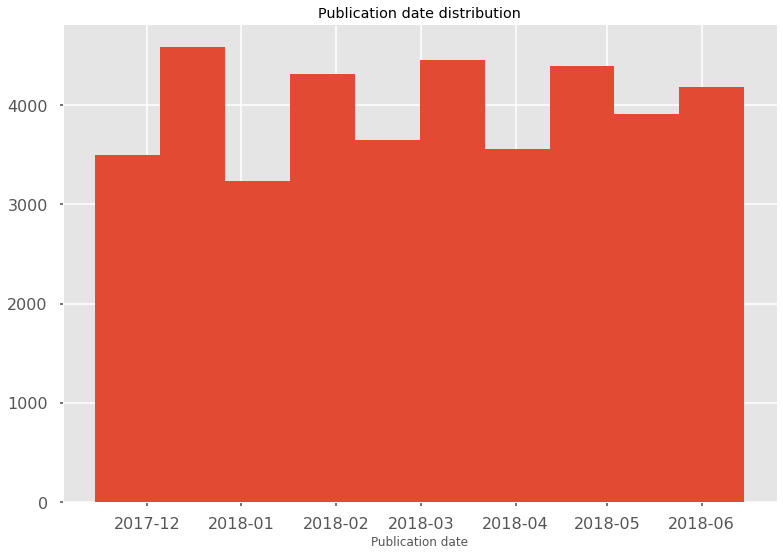

In [0]:
df.publishedAt.hist()
plt.xlabel('Publication date')
plt.title('Publication date distribution');

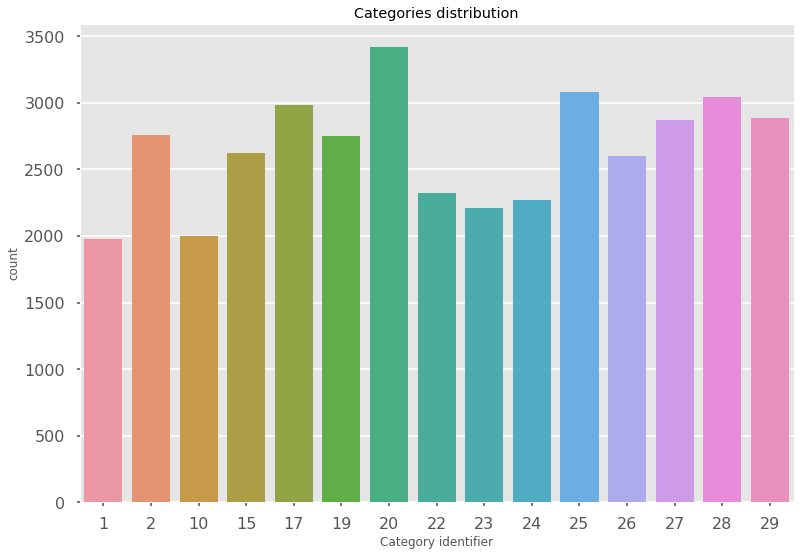

In [0]:
df.categoryId = df.categoryId.astype(int)
sns.countplot(df.categoryId)
plt.xlabel('Category identifier');
plt.title('Categories distribution');

The data aquisition technique determines that data is evenly distributed. The lack of category number 43 is the rseult of lack of data obtained by API for this category.

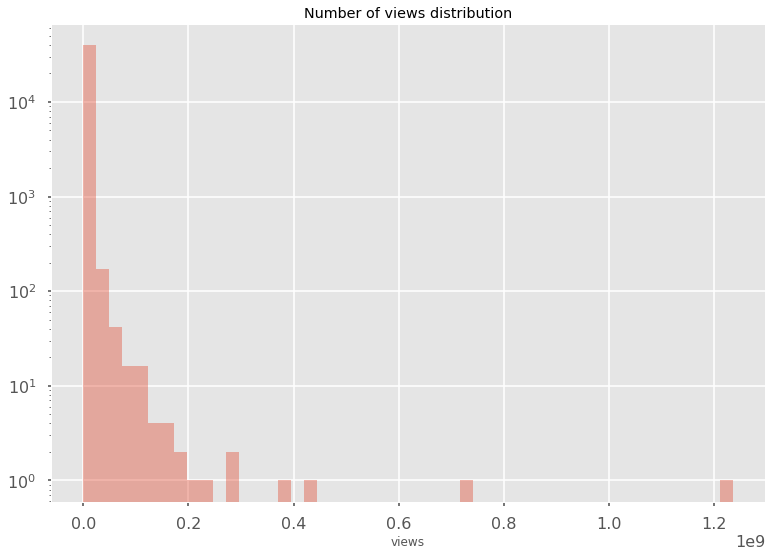

In [0]:
ax = sns.distplot(df.views, kde=False)
ax.set_yscale('log')
ax.set_title('Number of views distribution');

In [0]:
ax = sns.distplot(df.likes, kde=False);
ax.set_yscale('log');

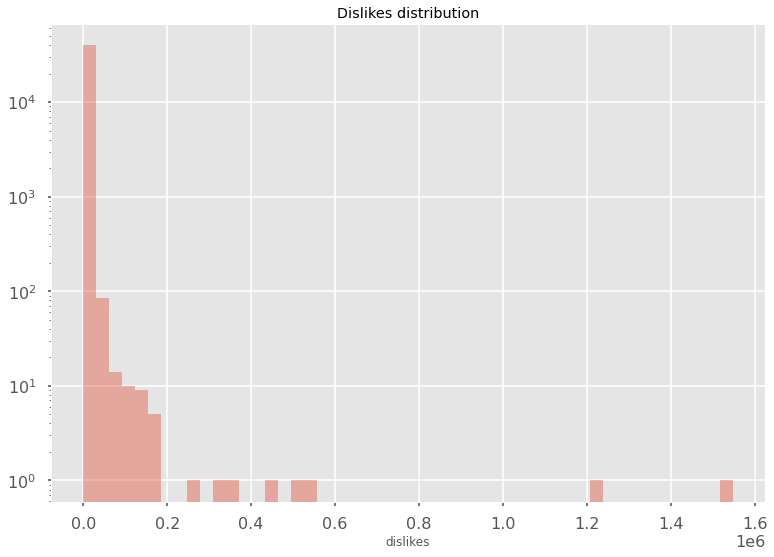

In [0]:
ax = sns.distplot(df.dislikes, kde=False)
ax.set_title('Dislikes distribution')
ax.set_yscale('log');

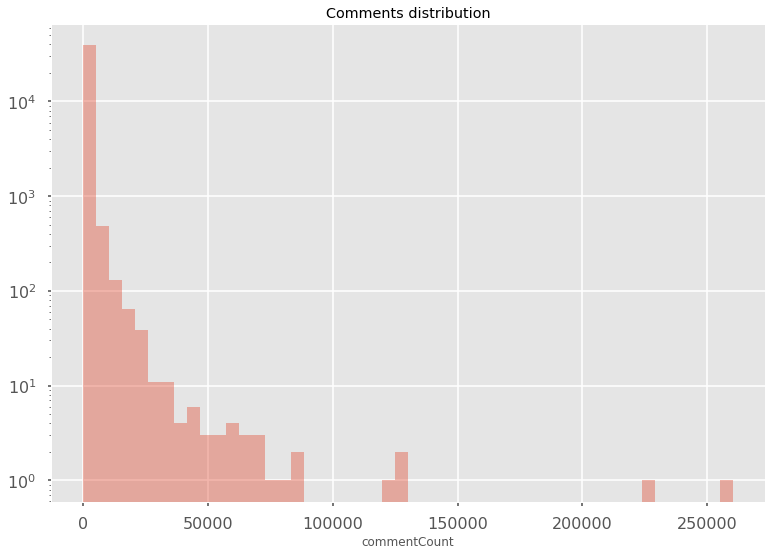

In [0]:
ax = sns.distplot(df.commentCount, kde=False);
ax.set_title('Comments distribution');
ax.set_yscale('log');

Views, ratings and comments distribution is natural consequence of excluding trending videos - there are only a few extremely viewed, liked and commented videos.

# Trending and non-trending prediction

## Constants

In [0]:
DATA_TRENDING = 'data_c12.hdf'
DATA_CAT = 'cat_mapping.csv'
DATA_NON_TRENDING = 'data_c6.hdf'
DATA_OBJ_TR = 'objects_tr.csv'
DATA_OBJ_NON_TR = 'objects_nontr.csv'
DATA_NT_BRT = 'non_brightness.csv'

## Prepare the data

In [0]:
df = pd.read_hdf(path.join(data_path, DATA_TRENDING))

time = ['publish_day', 'publish_hour', 'publish_month'] 
cos = [x + '_cos' for x in time]
sin = [x + '_sin' for x in time]

to_remove = ['trending_date', 'title', 'channel_title', 'tags', 
             'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 
             'description', 'publish_date', 'time_to_viral', 'tags_split',
             'title_split', 'title_alpha', 'trend_pub_date_diff', 'desc_clean',
             'desc_split', 'links', 'tokens', 'desc_preproc', 'tf_idf_vector', 
             'palette', 'resNet_vec', 'hog_vec', 'dominant_color', 
             'publish_time', 
             'trending_date_conv', 'trending_month', 'obj_vec']
to_remove += cos
to_remove += sin
df = df.drop(to_remove, axis=1)

Fill the categories in trending

In [0]:
df_cat = pd.read_csv(path.join(data_path, DATA_CAT))
def find_cat(x):
  cat = df_cat[df_cat.video_id == x].true_cat.values
  if len(cat) == 0:
    return None
  if len(cat) == 1:
    return cat[0]
  else:
    raise ValueError("More than one category matching")
df.category_id = df.video_id.apply(find_cat)

Add detected objects data

In [0]:
df_t_obj = pd.read_csv(path.join(data_path, DATA_OBJ_TR), 
                       sep=';', 
                       error_bad_lines=False)
df = df.merge(df_t_obj, on='video_id')

Load non-trending and remove unused

In [0]:
df_n = pd.read_hdf(path.join(data_path, DATA_NON_TRENDING))
to_remove_nt = set(df_n.columns) & set(to_remove)
df_n = df_n.drop(columns=to_remove_nt)

Add detected objects to non-trending

In [0]:
df_nt_obj = pd.read_csv(path.join(data_path, DATA_OBJ_NON_TR), 
                       sep=';', 
                       error_bad_lines=False)
df_n = df_n.merge(df_nt_obj, on='video_id')

Add brightness to non_trending

In [0]:
df_nt_br = pd.read_csv(path.join(data_path, DATA_NT_BRT),
                       sep=';',
                       error_bad_lines=False)
df_n = df_n.merge(df_nt_br, on='video_id')
df_n['trending'] = False
df['trending'] = True
df = df.append(df_n)
df = df.drop(columns=['video_id'])
df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df.shape
df.loc[:, 'category_id'] = pd.Categorical(df.category_id)
cat_vars = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
for var in cat_vars:
  cont_tab = pd.crosstab(index=df['trending'], columns=df[var])
  test = chi2_contingency(cont_tab)
  print('Var: %s\tp_value: %.2E' % (var, test[1]))

Var: comments_disabled	p_value: 1.09E-239
Var: ratings_disabled	p_value: 1.20E-50
Var: video_error_or_removed	p_value: 8.62E-07


The boolean variables are statistically significant

## Classifiers

### Splitting the dataset

In [0]:
df.category_id = df.category_id.astype(int)
X = df.drop(columns=['trending'])
y = df.trending
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4,
                                                    stratify=y, 
                                                    random_state=1996)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5,
                                                    stratify=y_test, 
                                                    random_state=1996)

In [0]:
def score(clf, data='valid', number=True):
  if data == 'valid':
    y_true = y_valid
    X = X_valid
  elif data =='test':
    y_true = y_test
    X = X_test
  else:
    y_true = y_train
    X = X_train
  y_pred = clf.predict(X)
  print(metrics.classification_report(y_true, y_pred))

### Logistic regression

In [0]:
clf = LogisticRegression(max_iter=1000, 
                         n_jobs=cpu_count(), 
                         penalty='none', 
                         multi_class='ovr')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=2, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
score(clf, data='train')

              precision    recall  f1-score   support

       False       0.87      0.98      0.92     23697
        True       0.71      0.29      0.41      4756

    accuracy                           0.86     28453
   macro avg       0.79      0.63      0.67     28453
weighted avg       0.85      0.86      0.84     28453



In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.87      0.98      0.92      7899
        True       0.72      0.27      0.39      1586

    accuracy                           0.86      9485
   macro avg       0.79      0.62      0.66      9485
weighted avg       0.84      0.86      0.83      9485



We have very low _recall_ on the trending (**1**, _positive_) class. The dataset is imbalanced. We will apply naive undersampling on the majority class.

### Undersampling

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
rus = RandomUnderSampler(random_state=1996)

In [0]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [0]:
clf.fit(X_under, y_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=2, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
score(clf, data='train')

              precision    recall  f1-score   support

       False       0.95      0.75      0.84     23697
        True       0.39      0.79      0.52      4756

    accuracy                           0.76     28453
   macro avg       0.67      0.77      0.68     28453
weighted avg       0.85      0.76      0.79     28453



In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.94      0.75      0.84      7899
        True       0.38      0.77      0.51      1586

    accuracy                           0.76      9485
   macro avg       0.66      0.76      0.68      9485
weighted avg       0.85      0.76      0.78      9485



Naive undersampling improved the _recall_ but dropped the _precision_. We will try _SMOTE_ and _Tomek Links_

### TomekLinks

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [0]:
Counter(y_train)

Counter({False: 23697, True: 4756})

In [0]:
tm = TomekLinks(random_state=1996, sampling_strategy='majority')
X_tomek, y_tomek = tm.fit_resample(X_train, y_train)
Counter(y_tomek)

In [0]:
sm = SMOTE(random_state=1996)
X_smote, y_smote = sm.fit_resample(X_tomek, y_tomek)
Counter(y_smote)

In [0]:
clf.fit(X_smote, y_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=2, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
score(clf, data='train')

              precision    recall  f1-score   support

       False       0.95      0.76      0.84     23697
        True       0.39      0.78      0.52      4756

    accuracy                           0.76     28453
   macro avg       0.67      0.77      0.68     28453
weighted avg       0.85      0.76      0.79     28453



In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.94      0.76      0.84      7899
        True       0.39      0.77      0.52      1586

    accuracy                           0.76      9485
   macro avg       0.67      0.76      0.68      9485
weighted avg       0.85      0.76      0.79      9485



Precision on the _trending_ class imporoved by **1%**. We are clearly underfitting. Neural network classifier will be tried.

### Neural Network

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid

In [0]:
params = {
    'lr': 10.0**np.arange(-6,0),
    'alpha': 10.0**np.arange(-4,1)
}

best_params = None
best_score = 0

for param in ParameterGrid(params):
  print(param)
  lr = param['lr']
  alpha = param['alpha']
  clf = MLPClassifier(hidden_layer_sizes=(1024),
                    solver='adam',
                    learning_rate_init=lr,
                    activation='logistic',
                    alpha=alpha,
                    max_iter=10)
  clf.fit(X_smote, y_smote)
  y_pred = clf.predict(X_valid)
  score = metrics.f1_score(y_pred, y_valid)
  if score > best_score:
    best_params = param
    best_score = score

In [0]:
print('Best validation score: %.2f %%' % (best_score*100))
print(best_params)

Best validation score: 69.44 %
{'alpha': 0.001, 'lr': 0.01}


In [0]:
learning_rate = 0.01
alpha = 0.001 # regularization lambda

clf = MLPClassifier(hidden_layer_sizes=(1024),
                  solver='adam',
                  learning_rate_init=learning_rate,
                  activation='logistic',
                  alpha=alpha,
                  max_iter=300,
                  verbose=True)

clf.fit(X_smote, y_smote)

In [0]:
score(clf, data='valid')

              precision    recall  f1-score   support

       False       0.97      0.88      0.92      7899
        True       0.59      0.87      0.70      1586

    accuracy                           0.88      9485
   macro avg       0.78      0.87      0.81      9485
weighted avg       0.91      0.88      0.88      9485



We can see a big improvement comparing to **Logistic regression**.
Using a shallow **Neural Network** with **1** hidden layer of **1024** units we've achieved **70%** _f1-score_ on _trending_ class. 

In [0]:
import joblib
joblib.dump(clf, path.join(data_path, 'clf_nn.joblib'))
#clf = joblib.load(path.join(data_path, 'clf_nn.joblib'))

['/content/drive/My Drive/datasets/youtube_data/clf_nn.joblib']

### CatBoost

CatBoost is a machine learning algorithm that uses gradient boosting on decision trees. It is available as an open source library. Judging on our previous experiences, it is powerful and relatively fast. It also offers ready to use methods for explainig the model.

In [0]:
!pip install catboost
!pip install shap
from catboost import CatBoostClassifier, Pool
import shap

In [0]:
xgb = CatBoostClassifier(iterations=500,
                           depth=10,
                           learning_rate=0.05,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=[df.columns.get_loc("category_id")],
                           use_best_model=True)

In [0]:
y_valid = y_valid
y_test = y_test
y_train = y_train
eval_pool = Pool(X_valid, y_valid, cat_features=[df.columns.get_loc("category_id")])
test_pool = Pool(X_test,  y_test, cat_features=[df.columns.get_loc("category_id")])
train_pool = Pool(X_train, y_train, cat_features=[df.columns.get_loc("category_id")])

In [0]:
xgb.fit(X_train, y_train, eval_set=eval_pool)

0:	learn: 0.6284033	test: 0.6284313	best: 0.6284313 (0)	total: 106ms	remaining: 52.7s
1:	learn: 0.5671833	test: 0.5676888	best: 0.5676888 (1)	total: 201ms	remaining: 49.9s
2:	learn: 0.5136501	test: 0.5141904	best: 0.5141904 (2)	total: 306ms	remaining: 50.7s
3:	learn: 0.4680655	test: 0.4688569	best: 0.4688569 (3)	total: 405ms	remaining: 50.2s
4:	learn: 0.4315165	test: 0.4323727	best: 0.4323727 (4)	total: 498ms	remaining: 49.3s
5:	learn: 0.3956282	test: 0.3971749	best: 0.3971749 (5)	total: 604ms	remaining: 49.7s
6:	learn: 0.3700315	test: 0.3720896	best: 0.3720896 (6)	total: 699ms	remaining: 49.2s
7:	learn: 0.3461965	test: 0.3486330	best: 0.3486330 (7)	total: 801ms	remaining: 49.3s
8:	learn: 0.3220445	test: 0.3246119	best: 0.3246119 (8)	total: 903ms	remaining: 49.2s
9:	learn: 0.3038084	test: 0.3071959	best: 0.3071959 (9)	total: 1s	remaining: 49.1s
10:	learn: 0.2872845	test: 0.2909095	best: 0.2909095 (10)	total: 1.09s	remaining: 48.7s
11:	learn: 0.2719023	test: 0.2757318	best: 0.2757318 (1

In [0]:
valid_pred = xgb.predict(X_valid)
valid_pred = np.where(valid_pred=='True', 1, 0)
print(metrics.classification_report(valid_pred, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8210
           1       0.78      0.97      0.86      1275

    accuracy                           0.96      9485
   macro avg       0.89      0.96      0.92      9485
weighted avg       0.97      0.96      0.96      9485



We achieved quite good results for CatBoost with depth 10 on validation dataset - **86%** on F1 measure for trending class. Therefore, we choose this classifier as a final solution.

In [0]:
test_pred = xgb.predict(X_test)
test_pred = np.where(test_pred=='True', 1, 0)
print(metrics.classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8188
           1       0.79      0.97      0.87      1297

    accuracy                           0.96      9485
   macro avg       0.89      0.96      0.92      9485
weighted avg       0.97      0.96      0.96      9485



The results on test set are even better.

## Explanation - Neural Network

The **Neural Network** explanation will be performed using _SHAP_.
> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

In [0]:
import shap
import warnings
shap.initjs()

In [0]:
def predict(X):
  return clf.predict_proba(X)[:,1]

array([0.16023455, 0.00499579, 0.05570258, ..., 0.10729287, 0.0009743 ,
       0.15658926])

In [0]:
explainer = shap.KernelExplainer(predict, 
                                 shap.kmeans(X_test, 10), 
                                 link="logit")

In [0]:
warnings.filterwarnings('ignore')
shap_values = explainer.shap_values(X_test.astype(float), nsamples=100)

In [0]:
joblib.dump(clf, path.join(data_path, 'clf_nn.joblib'))

### General impact

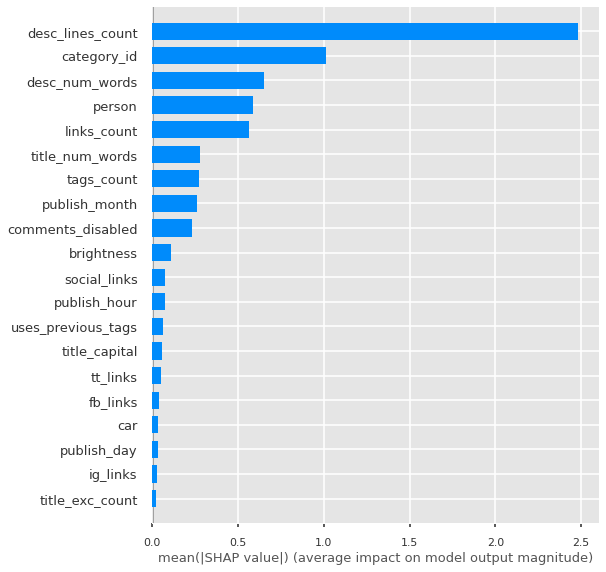

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

On the figure above, we can see the most important features for the model.
We can clearly see the significance of the **description length**. Category is also considered important.

After those two we have a set of 3 next ones:
 * Number of words in the descriptions
 * Number of people identified on the thumbnail
 * Number of links in the description  

Later on we could extract another _cluster_:
 * Number of words in title
 * Number of tags
 * The publish month
 * If the comments are disabled

### Direction-oriented analysis

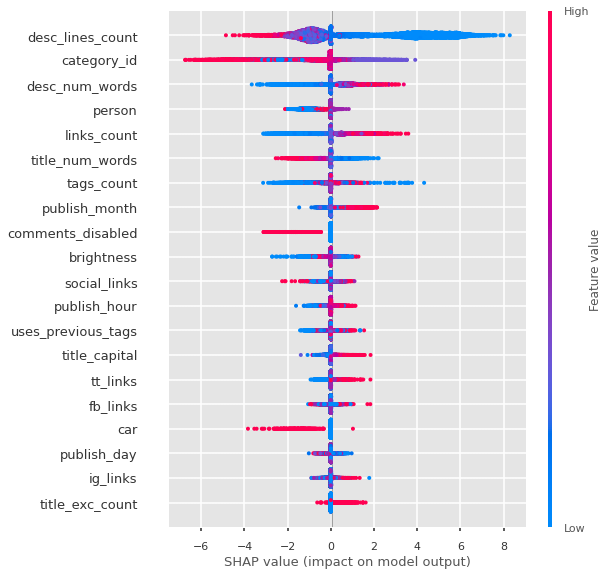

In [0]:
shap.summary_plot(shap_values, X_test, 
                  plot_type='dot', 
                  max_display=20)

On the figure above, we can see how does a feature value (in terms of color), directs the output either in _non-trending_ (left) or _trending_ (right) side.

#### Comments

One of the clearest examples is _comments\_disabled_ feature. We can see, that **disabling comments** is a bad idea, because it always directs a video into the _non-trending_ category.

#### Description length

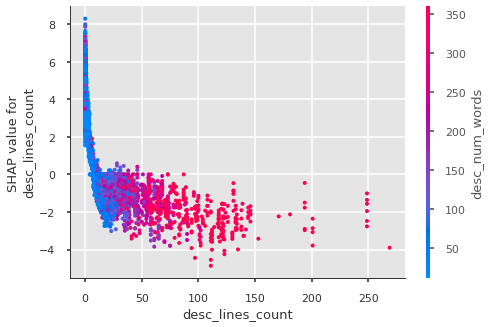

In [0]:
shap.dependence_plot('desc_lines_count', shap_values, X_test, interaction_index='desc_num_words')

Description has the greatest impact on the model's output. As we can see on the plot above, a **short description with a very few lines and a small number of wrods** is the best option to direct the prediction into _trending_ zone (positive _SHAP_ values). The longer the description, the lower the odds of getting into training.

#### Category

It's a matter of the discusion if the category is manipulable when thinking about increasing videos chances to get trending. It is clear however, that category is a important factor in the prediction.

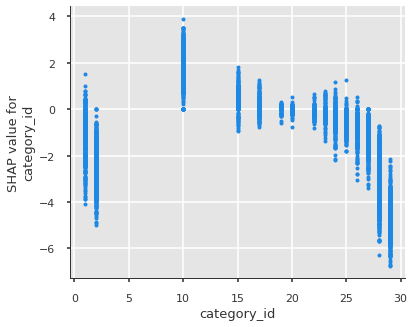

In [0]:
shap.dependence_plot('category_id', shap_values, X_test, 
                     interaction_index=None)

#### Person

In [0]:
shap.dependence_plot('person', shap_values, X_test, 
                     interaction_index=None)

Having no person on the thumbnail directs the odds towards _non-trending_.
It's good to have exactly one person to increase the odds of getting _trending_.

#### Links

In [0]:
shap.dependence_plot('links_count', 
                     shap_values, 
                     X_test, 
                     interaction_index='social_links')

The general conclusion is:
* A moderate number of links (more than 20) shouldn't direct the prediction into non-trending area.
* Social links could sometimes help

#### Title

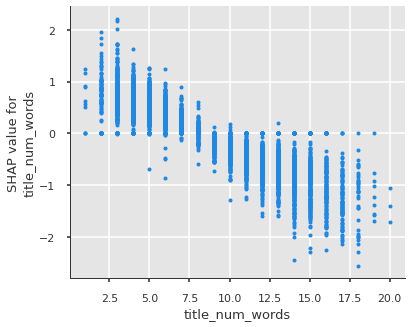

In [0]:
shap.dependence_plot('title_num_words', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

A short title (up to ~7 words) directs the prediction towards _trending_. Longer titles seem to be a bad idea.

#### Number of tags

In [0]:
shap.dependence_plot('tags_count', 
                     shap_values, 
                     X_test)

The impact of the numbers of the tags is less clear, but can be grasped, when compared to the number of links in description. Using a high number of tags and high number of links in description, helps to direct the prediction towards _treidning_.

#### Publish month

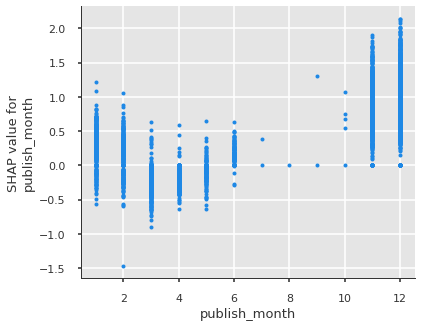

In [0]:
shap.dependence_plot('publish_month', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

We can see a strong bias of some months towards _trending_. This needs to be interpreted carefully - the distribution of the _publish\_month_ across the classes should be checked.

#### Publish hour

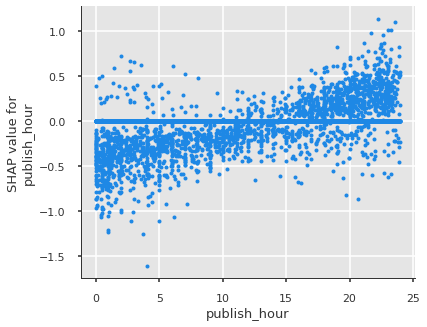

In [0]:
shap.dependence_plot('publish_hour', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

We can see, that publishin the video in the late evening hours, directs the prediction towards _trending_.  

#### Title capital

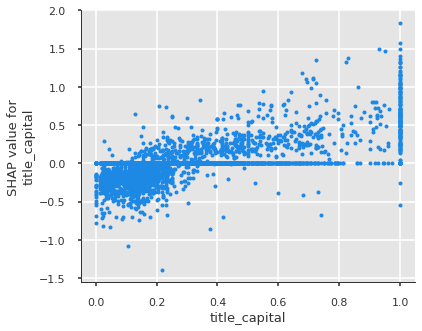

In [0]:
shap.dependence_plot('title_capital', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

It is a good idea to use a lot of capital letters in title.

#### Car

In [0]:
shap.dependence_plot('car', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

It's better not to have a car on thumbnail - a strange conclusion that seems to hold in most of the cases.

## General conclusions from Neural Network analysis

We can draw the following advices from the _Neural Network_ analysis to increase the video's chances to get trending:
 * Don't disable comments
 * Use short description
 * If the content fits more than one category, choose the one increasing the odds of gettin trending
 * Including some social links can be helpful
 * Title should be short (definitely shouldn't extend ~7 words)
 * Using a lot of capitals in the title is a good idea
 * Have exactly one person on the thumbnail (and avoid cars)
 * Publish the video in the middle of the night

## Explanation - CatBoost

In [0]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### General impact

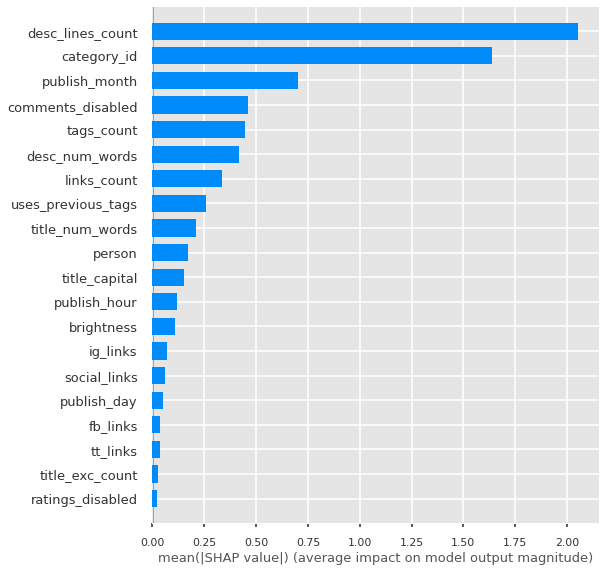

In [0]:
shap.summary_plot(shap_values, X, plot_type="bar")

In XGB model th most significant is also number of lines in the description. Category is also very important. The third significant feature is month of publication. Then, there are three features, which have similar impact:
 * if the comments are disabled
 * number of tags 
 * number of words in description

Number of links in descrpition and using tags popular in other trending videos are also worth mentioning. Other features don't have big impact on the output.  


### Direction-oriented analysis

In [0]:
shap.summary_plot(shap_values, X_test, 
                  plot_type='dot', 
                  max_display=20)

#### Description length - lines


In [0]:
shap.dependence_plot('desc_lines_count', shap_values, X_test, interaction_index='desc_num_words')

Number of lines in the description seems is the most important feature in prediction - we can observe, that descriptions with only a few lines are pushing prediction into trending videos - probably constructing concise description is vital for getting into trending list.

Category

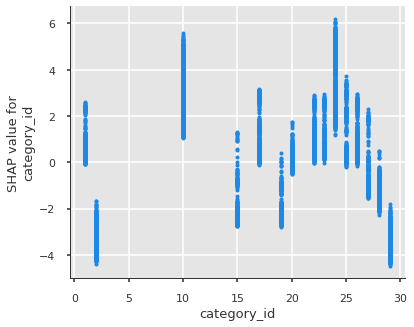

In [0]:
shap.dependence_plot('category_id', shap_values, X_test, interaction_index=None)

We can state that videos belonging to some categories are more supposed to get viral, because some of them concern more people, while others are viewed only by specific groups of people - e.g. with very specific intersets.

The most trending category seems to be 24 - Entertainment and 10 - Music.

#### Publish month

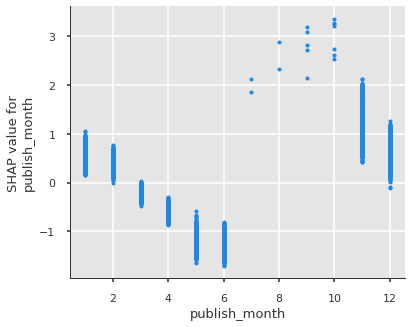

In [0]:
shap.dependence_plot('publish_month', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

We should chcek the distribution of months across the classes. It is hard to explain why videos published in November and December bias the classifier into trending class.

#### Disabling comments

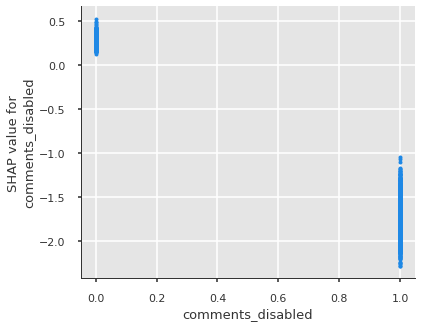

In [0]:
shap.dependence_plot('comments_disabled', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

As we could see from general plot, disabling comment doesn't have a good impact being trendy.

#### Number of tags

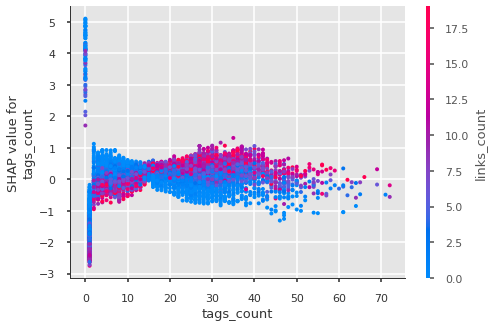

In [0]:
shap.dependence_plot('tags_count', 
                     shap_values, 
                     X_test)

The impact of tags is not so easy to interpret, but we can observe, that having a good balance between tags and links can be helpful - either several links and tags or many tags and many links.

#### Description length - words

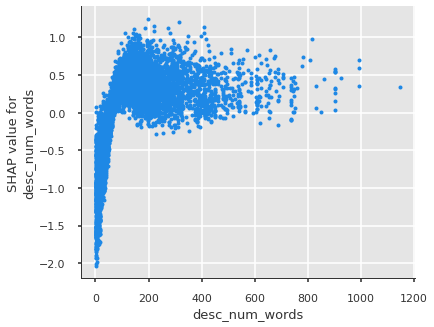

In [0]:
shap.dependence_plot('desc_num_words', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

Having in mind the plot of number of lines in the description, we can observe quite unexpected dependence - for getting trending it is good to have small number of lines in the description, but on the other hand - a lot of words. So we can state, that the description should be short in terms of lines and longs in terms of words - it should be constructed of few long lines.

#### Links

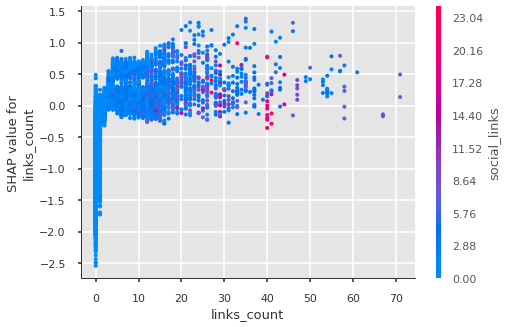

In [0]:
shap.dependence_plot('links_count', 
                     shap_values, 
                     X_test, 
                     interaction_index='social_links')

Not having any links or very small number of them seems to bias classifier into non-trending videos. It is good to place at least several in the description. This phenomenon can be explained also in wider view: if you want to be popular, build your popularity not only on YouTube, but also in other places, especially social media.

#### Using popular tags

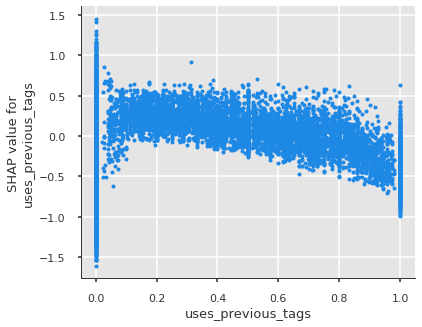

In [0]:
shap.dependence_plot('uses_previous_tags', 
                     shap_values, 
                     X_test, 
                     interaction_index=None)

Using tags popular in other trending videos can be helpful sometimes, but not always. Probably some videos followed latest trends and were popular because of that, but the majority must have been somehow innovative and outstanding to catch watchers attention.

#### Title length

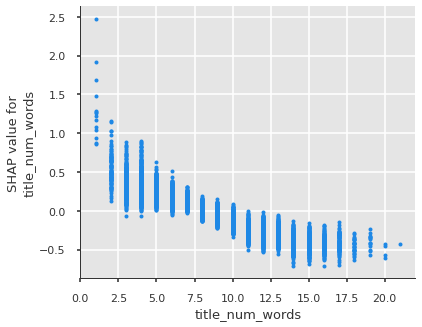

In [0]:
shap.dependence_plot('title_num_words', 
                     shap_values, 
                     X_test,
                     interaction_index=None)

Short, eye-catching titles are more likely to catch the viewer eye.

#### Person

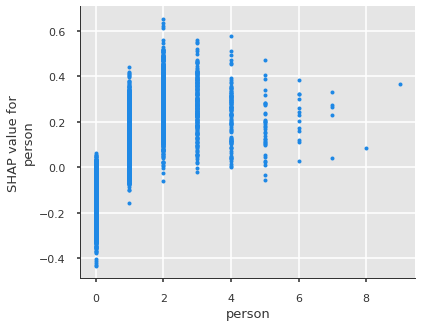

In [0]:
shap.dependence_plot('person', shap_values, X_test, 
                     interaction_index=None)

People occuring on video miniature can help in drawing attention to the video. 

#### Capital letters in title

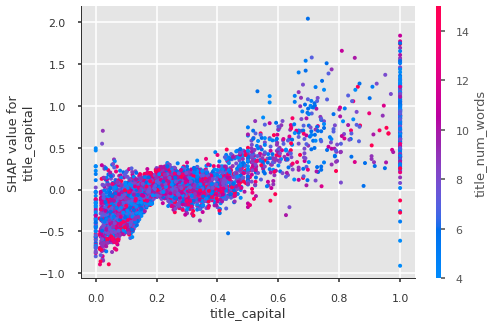

In [0]:
shap.dependence_plot('title_capital', shap_values, X_test, 
                     interaction_index='title_num_words')

Using a lot of capital letters in title seems to draw attention to the video.

#### Publish hour


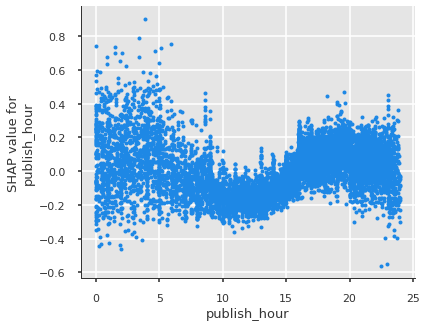

In [0]:
shap.dependence_plot('publish_hour', shap_values, X_test, 
                     interaction_index=None)

Popular videos were uploaded more often in the night

#### Social links

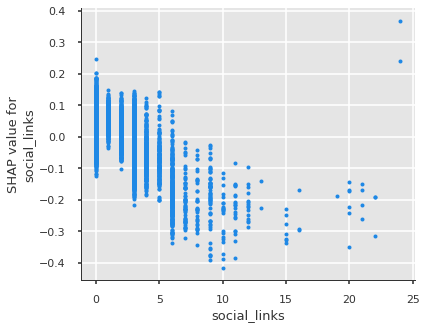

In [0]:
shap.dependence_plot('social_links', shap_values, X_test, 
                     interaction_index=None)

Including too many links to social media could hinder getting the video into trending list.

#### Thumbnail brightness

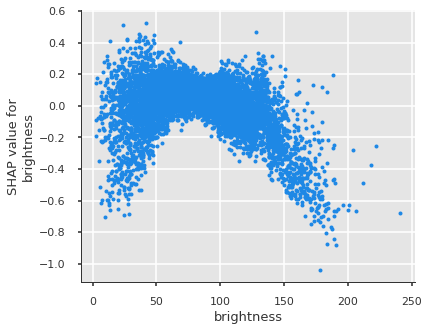

In [0]:
shap.dependence_plot('brightness', shap_values, X_test, 
                     interaction_index=None)

Using too bright thumbnails can be dissuasive for potential viewers. Maybe very bright films are considered as low-quality.

## Knowledge for the YouTuber

We can draw the following advices to increase the video's chances to get trending:
 * Don't disable comments
 * Use short, but informative description
 * If the content fits more than one category, choose the one increasing the odds of getting trending. If you are the beginner and don't have strict vision for the channel - make videos associated with entertainment.
 * Build popularity not only on YouTube, but across the whole Internet,  
 * Including links in description can be helpful, but don't use too many links to social media
 * Title should be short (definitely shouldn't extend ~7 words)
 * Using a lot of capitals in the title is a good idea
 * Take care of the quality of thumbnail - don't use too bright ones 
 * Publish the video in the middle of the night
 * Be innovative in terms of using tags



# Changelog

* Corrected some plots' labels
* Filtered out duplicates for Exploratory Data Analysis
* Corrected `uses_previous_tags` attribute for boundary data
* Reduced the number of attributes - deleted HOG vectors, ElmO, ResNet, Tf-Idf representations
* Added attributes for HSV representation of thumbnail
* Retrieved attribute for channel title
* Retrieved more data with completed category
* Merged some rare cases into other, similar categories
* Resigned from using PCA and SMOTE for new set of attributes
* Added Self Learning with Neural Network for categories prediction
* Tested Label Propagation on more dense grid of parameters
* Analyzed confusion matrix for categories prediction
